# Network analysis of Telegram chats and channels 

## Overlapping links and overlapping users in general and across three time periods (between 2017/03/18 - 2021/06/18)

In [1]:
import urllib.request
%matplotlib inline
import matplotlib.pyplot as plt
import networkx as nx
import networkx.algorithms.community as nxcom
import community # from python-louvain package
import pandas as pd
import numpy as np
from collections import Counter
import igraph as ig
import leidenalg as la
import random
import datetime as dt
random.seed(10)
import seaborn as sns

In [2]:
d = pd.read_csv('/Users/m.simonuva.nl/GitHub/FYP/cleaned_data.csv', parse_dates = ['date'])

In [3]:
d.sort_values(by='date', ascending=True)

date  \
2021618 2017-03-18 18:38:00+00:00   
2021617 2017-03-18 18:40:54+00:00   
2021616 2017-03-18 18:41:14+00:00   
2021615 2017-03-18 18:41:49+00:00   
2021614 2017-03-18 18:43:08+00:00   
...                           ...   
1892663 2021-06-18 16:45:11+00:00   
1847599 2021-06-18 16:45:19+00:00   
1892662 2021-06-18 16:49:57+00:00   
1947647                       NaT   
1947648                       NaT   

                                                       url  \
2021618                         https://t.me/thierrybaudet   
2021617                         https://t.me/thierrybaudet   
2021616                         https://t.me/thierrybaudet   
2021615                         https://t.me/thierrybaudet   
2021614                         https://t.me/thierrybaudet   
...                                                    ...   
1892663                https://t.me/coronavaccinschatgroep   
1847599                 https://t.me/mondkapjesverzetgroep   
1892662                https://t.me/coronavaccinschatgroep   
1947647  Het word nu toch echt tijd om actie te gaan on...   
1947648  https://www.telegraaf.nl/nieuws/421248130/ook-...   

                                                    source     type  \
2021618                                      thierrybaudet  channel   
2021617                                      thierrybaudet  channel   
2021616                                      thierrybaudet  channel   
2021615                                      thierrybaudet  channel   
2021614                                      thierrybaudet  channel   
...                                                    ...      ...   
1892663                             coronavaccinschatgroep  channel   
1847599                              mondkapjesverzetgroep     chat   
1892662                             coronavaccinschatgroep  channel   
1947647  Het word nu toch echt tijd om actie te gaan on...      NaN   
1947648  https://www.telegraaf.nl/nieuws/421248130/ook-...      NaN   

                                                 user_data           ids  \
2021618  Channel(id=1102958542, title='Thierry Baudet',...  1.102959e+09   
2021617  Channel(id=1102958542, title='Thierry Baudet',...  1.102959e+09   
2021616  Channel(id=1102958542, title='Thierry Baudet',...  1.102959e+09   
2021615  Channel(id=1102958542, title='Thierry Baudet',...  1.102959e+09   
2021614  Channel(id=1102958542, title='Thierry Baudet',...  1.102959e+09   
...                                                    ...           ...   
1892663  User(id=1187005152, is_self=False, contact=Fal...  1.187005e+09   
1847599  User(id=1067769489, is_self=False, contact=Fal...  1.067769e+09   
1892662  User(id=1757393767, is_self=False, contact=Fal...  1.757394e+09   
1947647                                                NaN           NaN   
1947648                                                NaN           NaN   

         message_id                              text_clean links  \
2021618         1.0                                     NaN   NaN   
2021617         2.0                                     NaN   NaN   
2021616         3.0                                     NaN   NaN   
2021615         4.0                                     NaN   NaN   
2021614         5.0                                     NaN   NaN   
...             ...                                     ...   ...   
1892663      8071.0  truth\n\nyellow_circle  tmehopenotfear   NaN   
1847599     52304.0                                     NaN   NaN   
1892662      8072.0                                     NaN   NaN   
1947647         NaN                                     NaN   NaN   
1947648         NaN                                     NaN   NaN   

         link_frequency                          text  \
2021618             NaN                           NaN   
2021617             NaN                           NaN   
2021616             NaN                           NaN   
2021615         

In [4]:
#drop the last two rows due to errors
df = d.drop([df.index[1947647] , df.index[1947648]])
#len(df['source'].unique())

NameError: name 'df' is not defined

In [8]:
#save the clean file 
df.to_csv('/Users/m.simonuva.nl/GitHub/FYP/clean_df.csv')

In [11]:
#drop nans on date
df = df[df['date'].notna()]

In [13]:
#unique users
unique_users = df['ids'].unique()
#number of unique users
len(unique_users)

55331

In [14]:
#number of unique chats/channels
unique_groups = df['source'].unique()
len(unique_groups)
#number of unique links shared in messages
len(df['links'].unique())

217428

In [20]:
#reorganize dataset so that data is gruped by daily frequncy per chat/channel
df1 = pd.DataFrame(df.groupby([pd.Grouper(freq ="D", key = 'date'), 'type'])['source'].agg(lambda x: "  ".join(x))) 
df1


source
date                      type                                                      
2017-03-18 00:00:00+00:00 channel  thierrybaudet  thierrybaudet  thierrybaudet  t...
2017-03-19 00:00:00+00:00 channel        thierrybaudet  thierrybaudet  thierrybaudet
2017-03-20 00:00:00+00:00 channel  thierrybaudet  thierrybaudet  thierrybaudet  t...
2017-03-21 00:00:00+00:00 channel        thierrybaudet  thierrybaudet  thierrybaudet
2017-03-22 00:00:00+00:00 channel  thierrybaudet  thierrybaudet  thierrybaudet  t...
...                                                                              ...
2021-06-16 00:00:00+00:00 chat     fvd_nl  fvd_nl  fvd_nl  fvd_nl  fvd_nl  fvd_nl...
2021-06-17 00:00:00+00:00 channel  DeBataafseRepubliek  DeBataafseRepubliek  DeBa...
                          chat     fvd_nl  fvd_nl  fvd_nl  fvd_nl  fvd_nl  fvd_nl...
2021-06-18 00:00:00+00:00 channel  DeBataafseRepubliek  DeBataafseRepubliek  DeBa...
                          chat     fvd_nl  fvd_nl  Forumvoordemocratiefvd  wilder...

[2122 rows x 1 columns]

In [32]:
#does not work anymore
df1['unique_source'] = df1['source'].str.split().apply(lambda x: ' , '.join(list(set(x))))
df1['unique_source'] = df1['unique_source'].str.strip(',') 

df1['unique_source'].iloc[79]

df1['unique_source_count'] = df1['unique_source'].str.count(r" , ")+1 #show number of unique sources- +1 added since if the source is unique no comma available
df1['unique_source_count'].max()

66

In [33]:
#df1

source  \
date                      type                                                         
2017-03-18 00:00:00+00:00 channel  thierrybaudet  thierrybaudet  thierrybaudet  t...   
2017-03-19 00:00:00+00:00 channel        thierrybaudet  thierrybaudet  thierrybaudet   
2017-03-20 00:00:00+00:00 channel  thierrybaudet  thierrybaudet  thierrybaudet  t...   
2017-03-21 00:00:00+00:00 channel        thierrybaudet  thierrybaudet  thierrybaudet   
2017-03-22 00:00:00+00:00 channel  thierrybaudet  thierrybaudet  thierrybaudet  t...   
...                                                                              ...   
2021-06-16 00:00:00+00:00 chat     fvd_nl  fvd_nl  fvd_nl  fvd_nl  fvd_nl  fvd_nl...   
2021-06-17 00:00:00+00:00 channel  DeBataafseRepubliek  DeBataafseRepubliek  DeBa...   
                          chat     fvd_nl  fvd_nl  fvd_nl  fvd_nl  fvd_nl  fvd_nl...   
2021-06-18 00:00:00+00:00 channel  DeBataafseRepubliek  DeBataafseRepubliek  DeBa...   
                          chat     fvd_nl  fvd_nl  Forumvoordemocratiefvd  wilder...   

                                                                       unique_source  \
date                      type                                                         
2017-03-18 00:00:00+00:00 channel                                      thierrybaudet   
2017-03-19 00:00:00+00:00 channel                                      thierrybaudet   
2017-03-20 00:00:00+00:00 channel                                      thierrybaudet   
2017-03-21 00:00:00+00:00 channel                                      thierrybaudet   
2017-03-22 00:00:00+00:00 channel                                      thierrybaudet   
...                                                                              ...   
2021-06-16 00:00:00+00:00 chat     Nederland_in_het_verzet , deelwatjeweet , oude...   
2021-06-17 00:00:00+00:00 channel  FvDMedia , gezondheidineigenhand , joumij , wr...   
                          chat     Nederland_in_het_verzet , deelwatjeweet , oude...   
2021-06-18 00:00:00+00:00 channel  FvDMedia , gezondheidineigenhand , onafhankeli...   
                          chat     Nederland_in_het_verzet , deelwatjeweet , oude...   

                                   unique_source_count  
date                      type                          
2017-03-18 00:00:00+00:00 channel                    1  
2017-03-19 00:00:00+00:00 channel                    1  
2017-03-20 00:00:00+00:00 channel                    1  
2017-03-21 00:00:00+00:00 channel                    1  
2017-03-22 00:00:00+00:00 channel                    1  
...                                                ...  
2021-06-16 00:00:00+00:00 chat                      59  
2021-06-17 00:00:00+00:00 channel                   41  
                          chat                      55  
2021-06-18 00:00:00+00:00 channel                   22  
                          chat                      46  

[2122 rows x 3 columns]

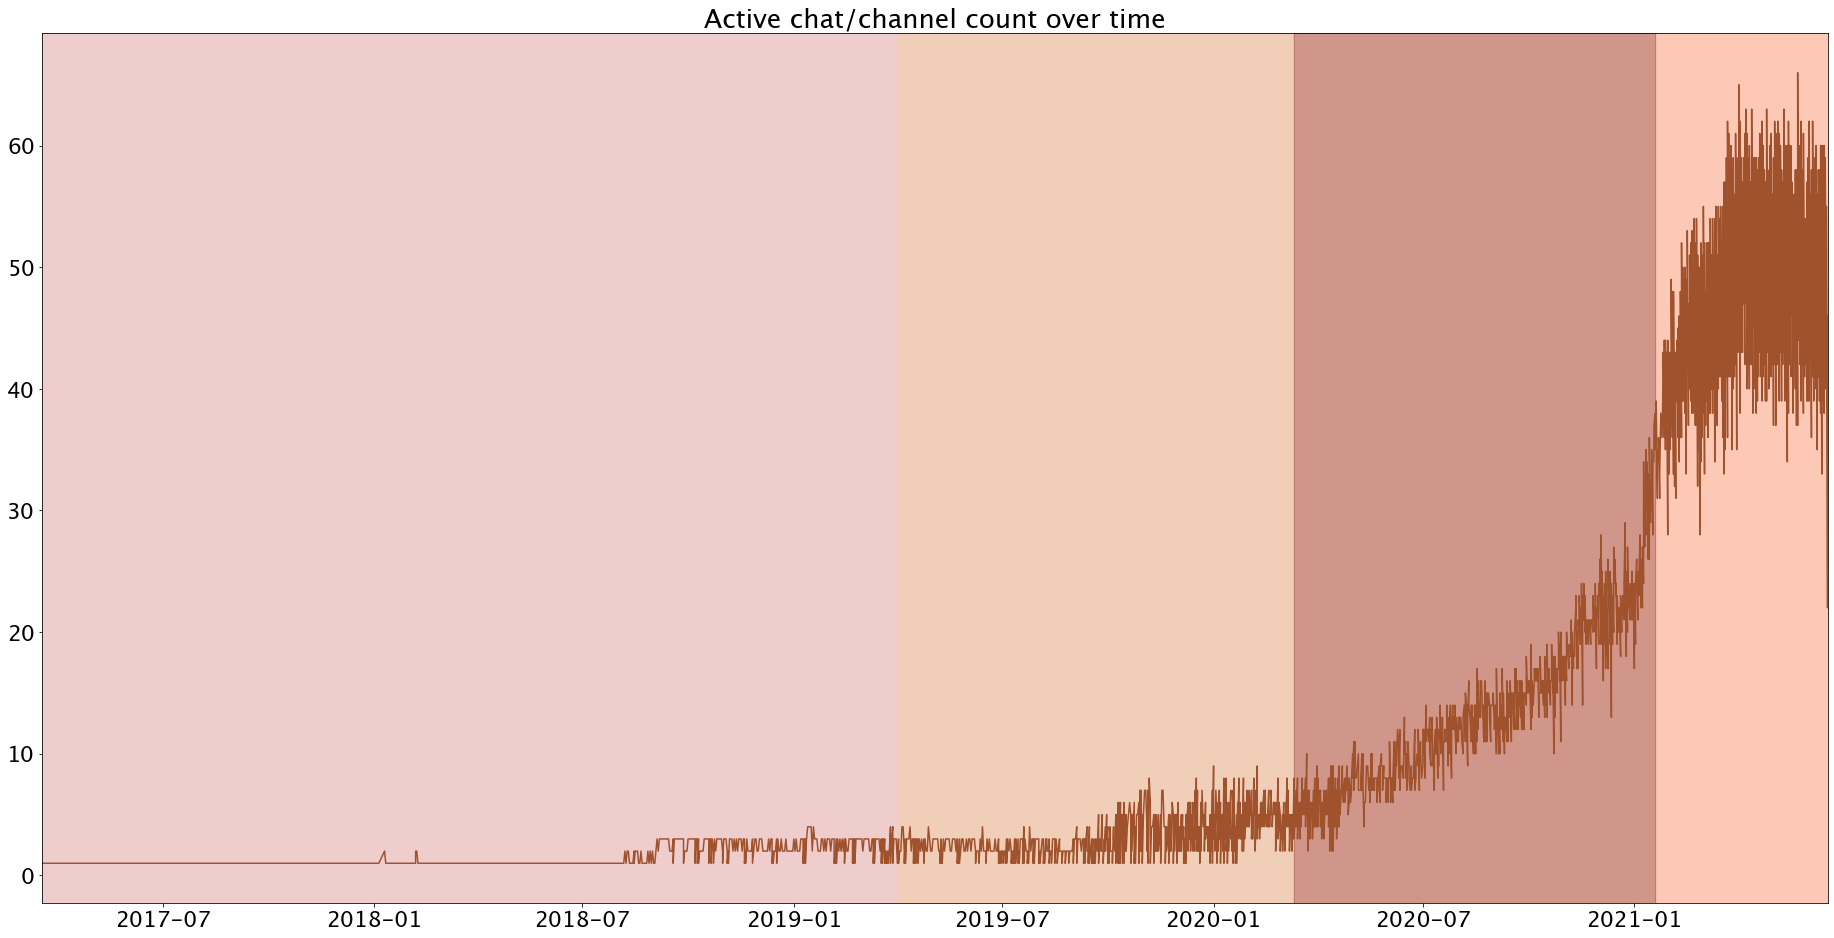

In [46]:
#plot active chats/channels over time
plt.rcParams.update({'font.size': 22})
node_plot = df1.reset_index()
plt.figure(figsize=(32,16))
plt.margins(0.00, 0.05)
plt.axvspan(dt.date(2017,3,18), dt.date(2020,3,10), color='indianred', alpha=0.3,linestyle = '-')
plt.axvspan(dt.date(2019,4,1), dt.date(2021,6,18), color='gold', alpha=0.1, linestyle = '-')
plt.axvspan(dt.date(2020,3,11), dt.date(2021,1,19), color='darkred', alpha=0.4, linestyle = '-')
plt.axvspan(dt.date(2021,1,20), dt.date(2021,6,18), color='salmon', alpha=0.4, linestyle = '-')
plt.plot(node_plot.date, node_plot.unique_source_count, color = 'sienna')
plt.title('Active chat/channel count over time')
plt.savefig('/Users/m.simonuva.nl/Studies/Study_1/NL-Telegram-nets/figures/chat_channel_count_overtime.png')
plt.show()

In [41]:
#change the type of ids from float to str
df['ids'] = df['ids'].astype(str)
df2 = pd.DataFrame(df.groupby([pd.Grouper(freq ="D", key = 'date'), 'type'])['ids'].agg(lambda x: "  ".join(x))) 
df2['unique_ids'] = df2['ids'].str.split().apply(lambda x: ' , '.join(list(set(x))))
df2['unique_ids'] = df2['unique_ids'].str.lstrip(',') 
df2['unique_ids'].iloc[79]

df2['unique_id_count'] = df2['unique_ids'].str.count(r" , ")+1 #show number of unique sources- +1 added since if the source is unique no comma available
df2['unique_id_count'].max()

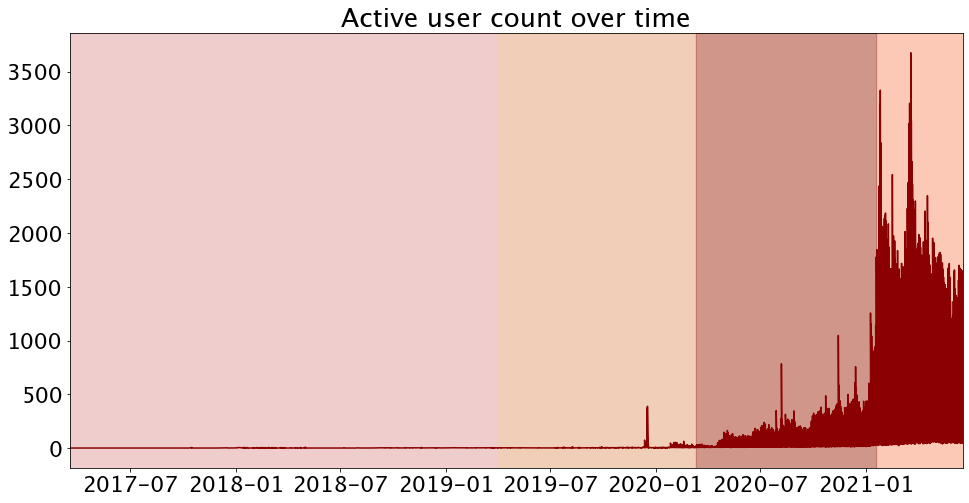

In [47]:
plt.rcParams.update({'font.size': 22})
user_plot = df2.reset_index()
plt.figure(figsize=(16,8))
plt.margins(0.00, 0.05)
plt.axvspan(dt.date(2017,3,18), dt.date(2020,3,10), color='indianred', alpha=0.3,linestyle = '-')
plt.axvspan(dt.date(2019,4,1), dt.date(2021,6,18), color='gold', alpha=0.1, linestyle = '-')
plt.axvspan(dt.date(2020,3,11), dt.date(2021,1,19), color='darkred', alpha=0.4, linestyle = '-')
plt.axvspan(dt.date(2021,1,20), dt.date(2021,6,18), color='salmon', alpha=0.4, linestyle = '-')
plt.plot(user_plot.date, user_plot.unique_id_count, color = 'darkred')
plt.title('Active user count over time')
plt.savefig('/Users/m.simonuva.nl/Studies/Study_1/NL-Telegram-nets/figures/user_count_overtime.png')
plt.show()

In [50]:
#change the type of links from float to str
df['links'] = df['links'].astype(str)

df3 = pd.DataFrame(df.groupby([pd.Grouper(freq ="D", key = 'date'), 'type'])['links'].agg(lambda x: "  ".join(x))) 
df3['unique_links'] = df3['links'].str.split().apply(lambda x: ' , '.join(list(set(x))))
df3['unique_links'] = df3['unique_links'].str.lstrip(',') 

df3['unique_links'].iloc[79]

df3['unique_link_count'] = df3['unique_links'].str.count(r" , ") #show number of unique sources- +1 added since if the source is unique no comma available
df3['unique_link_count'].max()

1104

In [1273]:
df = df.reset_index()

#### Time series plot of users and links over time


In [54]:
df['month'] = df['date'].dt.month

In [56]:
df4 = pd.DataFrame(df.groupby([pd.Grouper(freq ="D", key = 'date'), 'source'])['ids'].agg(lambda x: "  ".join(x))) #hourly sharing of urls per channel/chat
#df2['ids'].iloc[0]
df4['unique_ids'] = df4['ids'].str.split().apply(lambda x: ' , '.join(list(set(x))))
df4['unique_ids'] = df4['unique_ids'].str.lstrip(',') 
df4['unique_ids'].iloc[79]
df4['unique_id_count'] = df4['unique_ids'].str.count(r" , ")+1 #show number of unique sources- +1 added since if the source is unique no comma available
df4['unique_id_count'].max()

1056

In [57]:
df5 = pd.DataFrame(df.groupby([pd.Grouper(freq ="D", key = 'date'), 'source'])['links'].agg(lambda x: "  ".join(x))) #hourly sharing of urls per channel/chat
#df5['ids'].iloc[0]
df5['unique_links'] = df5['links'].str.split().apply(lambda x: ' , '.join(list(set(x))))
df5['unique_links'] = df5['unique_links'].str.lstrip(',') 
df5['unique_links'].iloc[79]
df5['unique_link_count'] = df5['unique_links'].str.count(r" , ")+1 #show number of unique sources- +1 added since if the source is unique no comma available
df5['unique_link_count'].max()

532

In [61]:
df6 = df4.reset_index().set_index('date')['2019-12-15': '2019-12-31'] #find the reason why there's a spike in activity in Dec. 2019

In [62]:
df6

source  \
date                                             
2019-12-15 00:00:00+00:00             FvDgroup   
2019-12-15 00:00:00+00:00       beeldmateriaal   
2019-12-15 00:00:00+00:00  dagelijksestandaard   
2019-12-15 00:00:00+00:00           geenstijll   
2019-12-15 00:00:00+00:00           leefbewust   
...                                        ...   
2019-12-31 00:00:00+00:00           geenstijll   
2019-12-31 00:00:00+00:00           leefbewust   
2019-12-31 00:00:00+00:00           natuurlijf   
2019-12-31 00:00:00+00:00      natuurlijf_chat   
2019-12-31 00:00:00+00:00        thepostonline   

                                                                         ids  \
date                                                                           
2019-12-15 00:00:00+00:00                            202914644.0  14726745.0   
2019-12-15 00:00:00+00:00                           958528035.0  972680796.0   
2019-12-15 00:00:00+00:00  1168689277.0  1168689277.0  1168689277.0  1168...   
2019-12-15 00:00:00+00:00  1397555145.0  1397555145.0  1397555145.0  1397...   
2019-12-15 00:00:00+00:00           1312698622.0  1312698622.0  1312698622.0   
...                                                                      ...   
2019-12-31 00:00:00+00:00  1397555145.0  1397555145.0  1397555145.0  1397...   
2019-12-31 00:00:00+00:00  1312698622.0  1312698622.0  1312698622.0  1312...   
2019-12-31 00:00:00+00:00                                       1271082614.0   
2019-12-31 00:00:00+00:00                                       1271082614.0   
2019-12-31 00:00:00+00:00  1204290075.0  1204290075.0  1204290075.0  1204...   

                                          unique_ids  unique_id_count  
date                                                                   
2019-12-15 00:00:00+00:00   14726745.0 , 202914644.0                2  
2019-12-15 00:00:00+00:00  958528035.0 , 972680796.0                2  
2019-12-15 00:00:00+00:00               1168689277.0                1  
2019-12-15 00:00:00+00:00               1397555145.0                1  
2019-12-15 00:00:00+00:00               1312698622.0                1  
...                                              ...              ...  
2019-12-31 00:00:00+00:00               1397555145.0                1  
2019-12-31 00:00:00+00:00               1312698622.0                1  
2019-12-31 00:00:00+00:00               1271082614.0                1  
2019-12-31 00:00:00+00:00               1271082614.0                1  
2019-12-31 00:00:00+00:00               1204290075.0                1  

[116 rows x 4 columns]

In [63]:
df6.sort_values(by='unique_id_count', ascending=False)

source  \
date                                         
2019-12-18 00:00:00+00:00   beeldmateriaal   
2019-12-17 00:00:00+00:00   beeldmateriaal   
2019-12-19 00:00:00+00:00   beeldmateriaal   
2019-12-16 00:00:00+00:00   beeldmateriaal   
2019-12-24 00:00:00+00:00         FvDgroup   
...                                    ...   
2019-12-20 00:00:00+00:00         FvDgroup   
2019-12-19 00:00:00+00:00    thepostonline   
2019-12-19 00:00:00+00:00  natuurlijf_chat   
2019-12-19 00:00:00+00:00       leefbewust   
2019-12-31 00:00:00+00:00    thepostonline   

                                                                         ids  \
date                                                                           
2019-12-18 00:00:00+00:00  873281665.0  873281665.0  916665836.0  8732816...   
2019-12-17 00:00:00+00:00  989714888.0  954118703.0  944918635.0  6553510...   
2019-12-19 00:00:00+00:00  626163708.0  1054367675.0  1054367675.0  10514...   
2019-12-16 00:00:00+00:00  939625428.0  566709353.0  939625428.0  9396254...   
2019-12-24 00:00:00+00:00  915372338.0  14726745.0  14726745.0  14726745....   
...                                                                      ...   
2019-12-20 00:00:00+00:00                                       1069017886.0   
2019-12-19 00:00:00+00:00  1204290075.0  1204290075.0  1204290075.0  1204...   
2019-12-19 00:00:00+00:00                                        897327035.0   
2019-12-19 00:00:00+00:00                                       1312698622.0   
2019-12-31 00:00:00+00:00  1204290075.0  1204290075.0  1204290075.0  1204...   

                                                                  unique_ids  \
date                                                                           
2019-12-18 00:00:00+00:00  979108157.0 , 997547206.0 , 1056739281.0 , 101...   
2019-12-17 00:00:00+00:00  973164282.0 , 1028348133.0 , 1047991541.0 , 91...   
2019-12-19 00:00:00+00:00  967132823.0 , 873281665.0 , 656554919.0 , 9537...   
2019-12-16 00:00:00+00:00  966457619.0 , 918351822.0 , 1052926330.0 , 773...   
2019-12-24 00:00:00+00:00  646826166.0 , 991398466.0 , 14726745.0 , 91537...   
...                                                                      ...   
2019-12-20 00:00:00+00:00                                       1069017886.0   
2019-12-19 00:00:00+00:00                                       1204290075.0   
2019-12-19 00:00:00+00:00                                        897327035.0   
2019-12-19 00:00:00+00:00                                       1312698622.0   
2019-12-31 00:00:00+00:00                                       1204290075.0   

                           unique_id_count  
date                                        
2019-12-18 00:00:00+00:00              388  
2019-12-17 00:00:00+00:00              368  
2019-12-19 00:00:00+00:00               60  
2019-12-16 00:00:00+00:00               43  
2019-12-24 00:00:00+00:00                5  
...                                    ...  
2019-12-20 00:00:00+00:00                1  
2019-12-19 00:00:00+00:00                1  
2019-12-19 00:00:00+00:00                1  
2019-12-19 00:00:00+00:00                1  
2019-12-31 00:00:00+00:00                1  

[116 rows x 4 columns]

In [64]:
df7 = df4.reset_index().set_index('date')['2020-08-30': '2021-01-19']
df7.sort_values(by = 'unique_id_count', ascending = False)

source  \
date                                             
2020-11-14 00:00:00+00:00   nederlandsverzet21   
2021-01-09 00:00:00+00:00   nederlandsverzet21   
2021-01-10 00:00:00+00:00   nederlandsverzet21   
2021-01-19 00:00:00+00:00   nederlandsverzet21   
2021-01-19 00:00:00+00:00          klokkenchat   
...                                        ...   
2020-11-15 00:00:00+00:00       klokkenluiders   
2020-11-15 00:00:00+00:00    langefranspodcast   
2020-11-15 00:00:00+00:00           leefbewust   
2020-11-15 00:00:00+00:00  leefbewustnederland   
2021-01-19 00:00:00+00:00            zoektocht   

                                                                         ids  \
date                                                                           
2020-11-14 00:00:00+00:00  1489238293.0  15697090.0  1364982615.0  123190...   
2021-01-09 00:00:00+00:00  1055264928.0  1492700326.0  1459306167.0  7090...   
2021-01-10 00:00:00+00:00  676142259.0  1330776023.0  1433682747.0  14002...   
2021-01-19 00:00:00+00:00  1552508402.0  1313202040.0  587232073.0  58723...   
2021-01-19 00:00:00+00:00  919284579.0  1107051772.0  nan  1107051772.0  ...   
...                                                                      ...   
2020-11-15 00:00:00+00:00  1306353747.0  1306353747.0  1306353747.0  1306...   
2020-11-15 00:00:00+00:00                         1467672805.0  1467672805.0   
2020-11-15 00:00:00+00:00                         1312698622.0  1312698622.0   
2020-11-15 00:00:00+00:00  1468546663.0  1468546663.0  1468546663.0  1468...   
2021-01-19 00:00:00+00:00                         1028067693.0  1028067693.0   

                                                                  unique_ids  \
date                                                                           
2020-11-14 00:00:00+00:00  1167765537.0 , 990930100.0 , 852249976.0 , 436...   
2021-01-09 00:00:00+00:00  1018981887.0 , 1549507167.0 , 1390198421.0 , 1...   
2021-01-10 00:00:00+00:00  1111849264.0 , 1005265001.0 , 1566454871.0 , 1...   
2021-01-19 00:00:00+00:00  1424094539.0 , 1544822882.0 , 1378076338.0 , 1...   
2021-01-19 00:00:00+00:00  1567376588.0 , 1005323275.0 , 1543364036.0 , 1...   
...                                                                      ...   
2020-11-15 00:00:00+00:00                                       1306353747.0   
2020-11-15 00:00:00+00:00                                       1467672805.0   
2020-11-15 00:00:00+00:00                                       1312698622.0   
2020-11-15 00:00:00+00:00                                       1468546663.0   
2021-01-19 00:00:00+00:00                                       1028067693.0   

                           unique_id_count  
date                                        
2020-11-14 00:00:00+00:00              747  
2021-01-09 00:00:00+00:00              604  
2021-01-10 00:00:00+00:00              455  
2021-01-19 00:00:00+00:00              450  
2021-01-19 00:00:00+00:00              433  
...                                    ...  
2020-11-15 00:00:00+00:00                1  
2020-11-15 00:00:00+00:00                1  
2020-11-15 00:00:00+00:00                1  
2020-11-15 00:00:00+00:00                1  
2021-01-19 00:00:00+00:00                1  

[5168 rows x 4 columns]

In [65]:
df8 = df4.reset_index().set_index('date')['2021-01-10': '2021-06-18']

In [1650]:
df8.sort_values(by = 'unique_id_count', ascending = False).head(30)

source  \
date                                                  
2021-01-25 00:00:00+00:00               klokkenchat   
2021-01-26 00:00:00+00:00               klokkenchat   
2021-03-20 00:00:00+00:00               klokkenchat   
2021-01-24 00:00:00+00:00               klokkenchat   
2021-03-17 00:00:00+00:00               klokkenchat   
2021-01-27 00:00:00+00:00       DeBataafseRepubliek   
2021-03-20 00:00:00+00:00  vervoervoordemonstranten   
2021-03-18 00:00:00+00:00               klokkenchat   
2021-03-28 00:00:00+00:00               klokkenchat   
2021-03-24 00:00:00+00:00               klokkenchat   
2021-03-25 00:00:00+00:00       DeBataafseRepubliek   
2021-03-15 00:00:00+00:00               klokkenchat   
2021-03-23 00:00:00+00:00               klokkenchat   
2021-03-21 00:00:00+00:00               klokkenchat   
2021-04-05 00:00:00+00:00       DeBataafseRepubliek   
2021-02-20 00:00:00+00:00       DeBataafseRepubliek   
2021-04-03 00:00:00+00:00       DeBataafseRepubliek   
2021-03-17 00:00:00+00:00       DeBataafseRepubliek   
2021-02-06 00:00:00+00:00       DeBataafseRepubliek   
2021-03-24 00:00:00+00:00       DeBataafseRepubliek   
2021-03-14 00:00:00+00:00               klokkenchat   
2021-06-12 00:00:00+00:00       DeBataafseRepubliek   
2021-02-16 00:00:00+00:00       DeBataafseRepubliek   
2021-04-29 00:00:00+00:00               klokkenchat   
2021-02-16 00:00:00+00:00               klokkenchat   
2021-03-19 00:00:00+00:00       DeBataafseRepubliek   
2021-03-23 00:00:00+00:00       DeBataafseRepubliek   
2021-02-05 00:00:00+00:00       DeBataafseRepubliek   
2021-06-14 00:00:00+00:00       DeBataafseRepubliek   
2021-04-08 00:00:00+00:00       DeBataafseRepubliek   

                                                                         ids  \
date                                                                           
2021-01-25 00:00:00+00:00  1583842587.0  1470623637.0  1583842587.0  1549...   
2021-01-26 00:00:00+00:00  1504287119.0  557723222.0  716573888.0  141915...   
2021-03-20 00:00:00+00:00  293045212.0  914348208.0  1006396285.0  557723...   
2021-01-24 00:00:00+00:00  187988230.0  1227150771.0  1490315783.0  14903...   
2021-03-17 00:00:00+00:00  1205653032.0  1397928176.0  1427977829.0  1215...   
2021-01-27 00:00:00+00:00  nan  1339459357.0  1430563997.0  1430563997.0 ...   
2021-03-20 00:00:00+00:00  nan  1182535160.0  1610318323.0  1491037682.0 ...   
2021-03-18 00:00:00+00:00  1118427332.0  1582135400.0  1205653032.0  1008...   
2021-03-28 00:00:00+00:00  1520570704.0  1711039795.0  nan  1599187937.0 ...   
2021-03-24 00:00:00+00:00  968959562.0  1634857677.0  44836539.0  1563811...   
2021-03-25 00:00:00+00:00  262522840.0  1408708880.0  1197192589.0  13902...   
2021-03-15 00:00:00+00:00  1182958321.0  1299906998.0  nan  1043815401.0 ...   
2021-03-23 00:00:00+00:00  1205653032.0  1008261732.0  1357352893.0  9515...   
2021-03-21 00:00:00+00:00  1481262373.0  11495884.0  1319277005.0  135528...   
2021-04-05 00:00:00+00:00  1446531974.0  1377322132.0  1166256400.0  1377...   
2021-02-20 00:00:00+00:00  1276874892.0  1225895518.0  1225789196.0  9889...   
2021-04-03 00:00:00+00:00  1519609358.0  1519609358.0  1390236992.0  1578...   
2021-03-17 00:00:00+00:00  1225895518.0  1107051772.0  639276511.0  63927...   
2021-02-06 00:00:00+00:00  1426858934.0  1504210261.0  1519609358.0  1497...   
2021-03-24 00:00:00+00:00  1368129101.0  1390236992.0  1434329196.0  1390...   
2021-03-14 00:00:00+00:00  1583842587.0  1681947017.0  1681947017.0  9143...   
2021-06-12 00:00:00+00:00  1804615396.0  1804615396.0  1631012832.0  1284...   
2021-02-16 00:00:00+00:00  1225895518.0  1477255407.0  1295038497.0  1225...   
2021-04-29 00:00:00+00:00  931208423.0  1601108604.0  931208423.0  141395...   
2021-02-16 00:00:00+00:00  1503023072.0  1207261221.0  1570048567.0  1657...   
2021-03-19 00:00:00+00:00  1570048567.0  1023941081.0  1531036903.0  1531...   
2021-03-23 00:00:00+00:00  1288178468.0  145

In [66]:
df8.head(20)

source  \
date                                                         
2021-01-10 00:00:00+00:00                            FVDNL   
2021-01-10 00:00:00+00:00           Forumvoordemocratiefvd   
2021-01-10 00:00:00+00:00                         FvDMedia   
2021-01-10 00:00:00+00:00                         FvDgroup   
2021-01-10 00:00:00+00:00  Kletschat_burgers_tegen_onrecht   
2021-01-10 00:00:00+00:00                       NLPolitiek   
2021-01-10 00:00:00+00:00          Nederland_in_het_verzet   
2021-01-10 00:00:00+00:00               QPatriotsEindhoven   
2021-01-10 00:00:00+00:00   SpiritualiteitOpHollandseBodem   
2021-01-10 00:00:00+00:00                         SpoedWet   
2021-01-10 00:00:00+00:00                      WakkerWezen   
2021-01-10 00:00:00+00:00                    XRNLbroadcast   
2021-01-10 00:00:00+00:00                  boereninopstand   
2021-01-10 00:00:00+00:00               boereninopstand2_0   
2021-01-10 00:00:00+00:00                   c0r0naboelsjit   
2021-01-10 00:00:00+00:00                  cafeweltschmerz   
2021-01-10 00:00:00+00:00                   complotgekkies   
2021-01-10 00:00:00+00:00              dagelijksestandaard   
2021-01-10 00:00:00+00:00                 denhaaginopstand   
2021-01-10 00:00:00+00:00               donmaartenofficial   

                                                                         ids  \
date                                                                           
2021-01-10 00:00:00+00:00                         1472437937.0  1472437937.0   
2021-01-10 00:00:00+00:00  1098637298.0  923684250.0  1485990777.0  92368...   
2021-01-10 00:00:00+00:00  1381712797.0  1381712797.0  1381712797.0  1381...   
2021-01-10 00:00:00+00:00  1334185657.0  1334185657.0  1110223992.0  1334...   
2021-01-10 00:00:00+00:00  1131083046.0  711096950.0  1316752519.0  71109...   
2021-01-10 00:00:00+00:00  669987516.0  991624635.0  991624635.0  9916246...   
2021-01-10 00:00:00+00:00  449641773.0  1064627.0  815256566.0  815256566...   
2021-01-10 00:00:00+00:00  1287507107.0  1355814769.0  1407528636.0  1113...   
2021-01-10 00:00:00+00:00                                       1582203822.0   
2021-01-10 00:00:00+00:00  1152430756.0  1184798351.0  1316752519.0  1316...   
2021-01-10 00:00:00+00:00  1329066193.0  1329066193.0  1329066193.0  1329...   
2021-01-10 00:00:00+00:00                                       1433170732.0   
2021-01-10 00:00:00+00:00  1130861032.0  29517726.0  1116953813.0  135768...   
2021-01-10 00:00:00+00:00  1560408925.0  803826372.0  1048728282.0  85165...   
2021-01-10 00:00:00+00:00  1363514541.0  1363514541.0  1363514541.0  1363...   
2021-01-10 00:00:00+00:00             1338154315.0  131594309.0  131594309.0   
2021-01-10 00:00:00+00:00           1491258400.0  1435775745.0  1435775745.0   
2021-01-10 00:00:00+00:00  1168689277.0  1168689277.0  1168689277.0  1168...   
2021-01-10 00:00:00+00:00  1196868155.0  1196868155.0  992325190.0  11775...   
2021-01-10 00:00:00+00:00                         1487323885.0  1487323885.0   

                                                                  unique_ids  \
date                                                                           
2021-01-10 00:00:00+00:00                                       1472437937.0   
2021-01-10 00:00:00+00:00  1354456946.0 , 972096632.0 , 1098637298.0 , 14...   
2021-01-10 00:00:00+00:00                                       1381712797.0   
2021-01-10 00:00:00+00:00  1350560981.0 , 685287147.0 , 923684250.0 , 915...   
2021-01-10 00:00:00+00:00  913195457.0 , 1142872353.0 , 1274817401.0 , 10...   
2021-01-10 00:00:00+00:00             669987516.0 , 16367951.0 , 991624635.0   
2021-01-10 00:00:00+00:00  1450052780.0 , 611913863.0 , 918266325.0 , 126...   
2021-01-10 00:00:00+00:00  796124256.0 , 1074105946.0 , 815972256.0 , 148...   
2021-01-10 00:00:00+00:00                                       1582203822.0   
2021-01-10 00:00:00+00:00  1306954398.0 , 1481

<AxesSubplot:xlabel='date', ylabel='unique_id_count'>

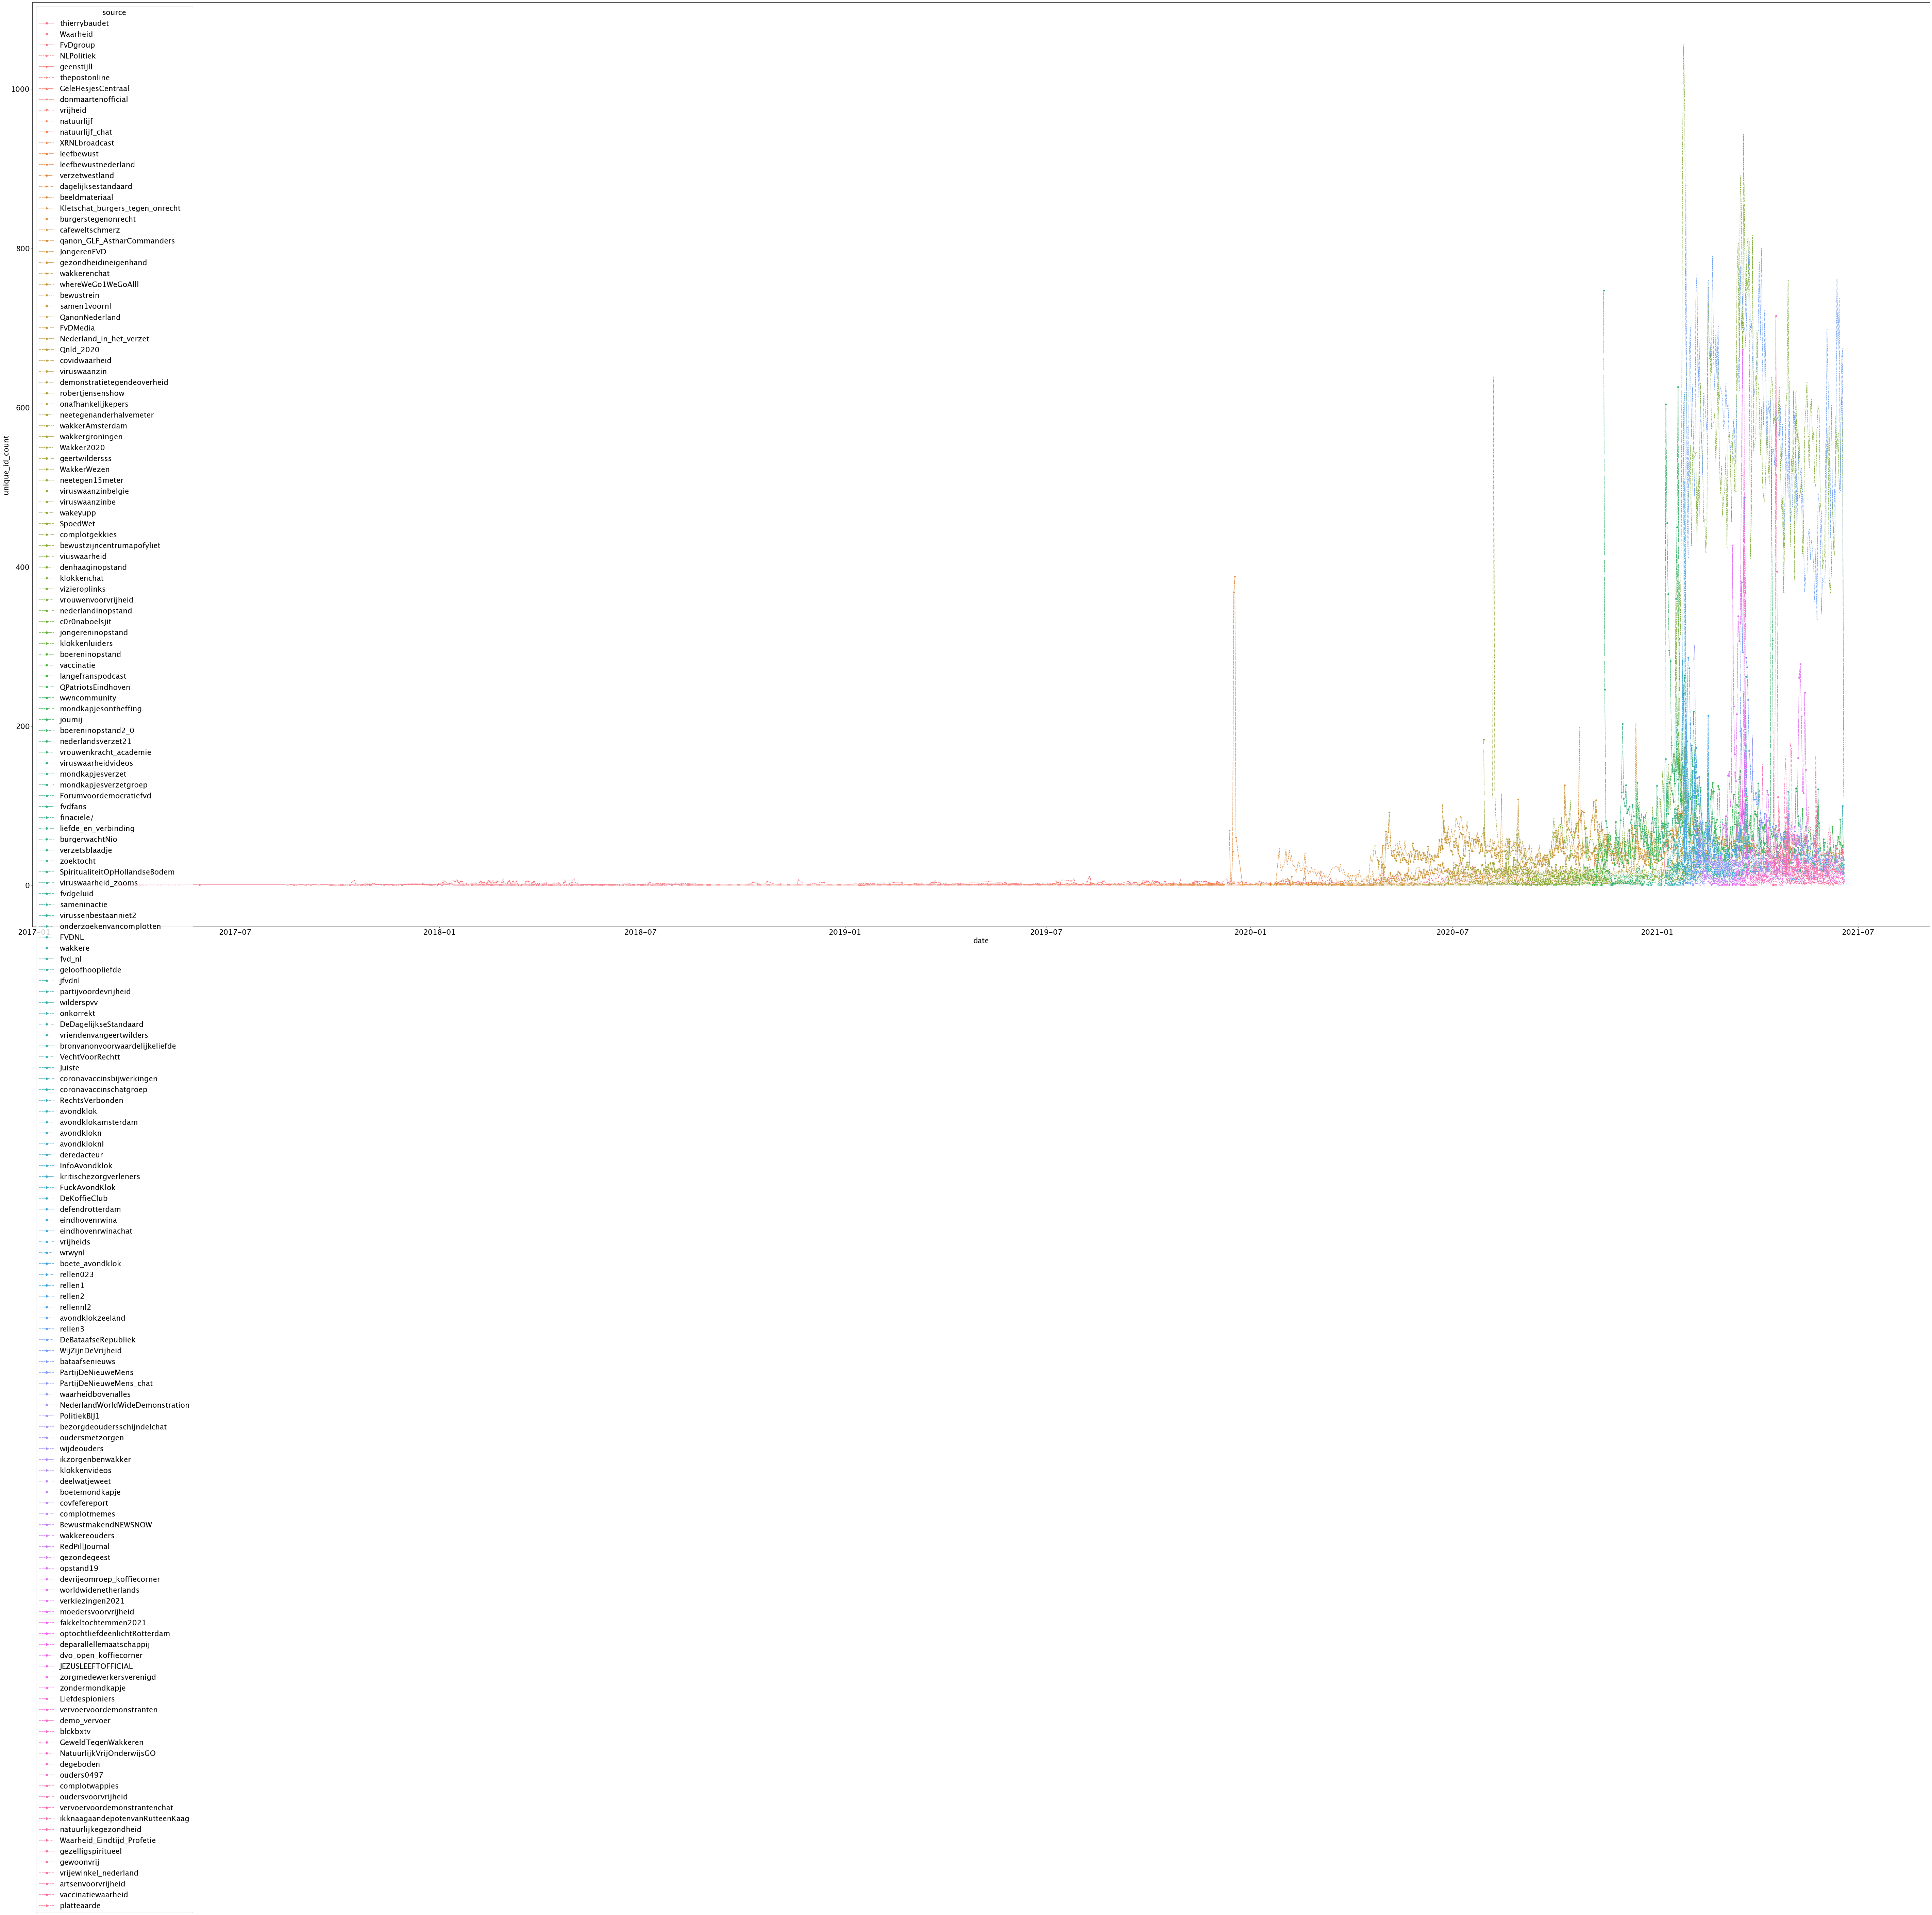

In [67]:
ax, fig = plt.subplots(figsize=[100, 50])
sns.lineplot(data=df4,  x="date", y="unique_id_count", hue="source", style="source", markers = True)

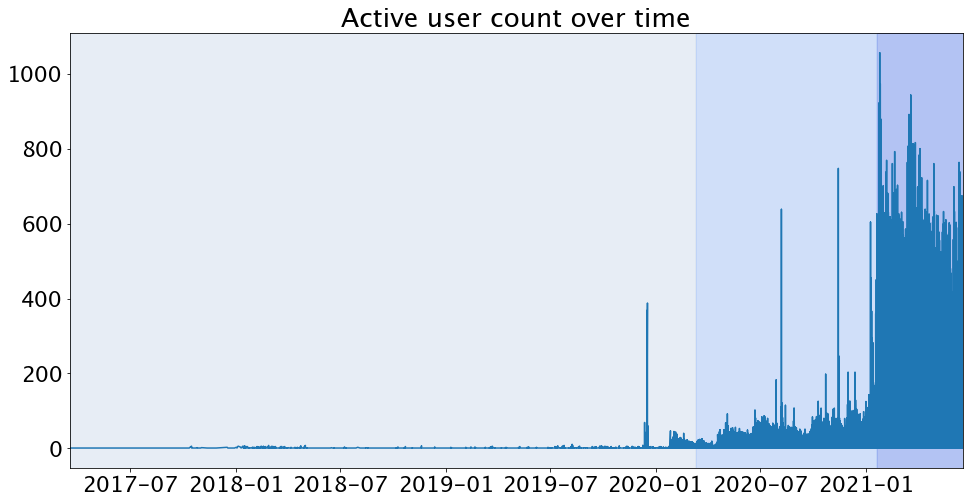

In [68]:
user_count_plot = df4.reset_index()
plt.figure(figsize=(16,8))
plt.margins(0.00, 0.05)
plt.axvspan(dt.date(2017,3,18), dt.date(2020,3,10), color='lightsteelblue', alpha=0.3)
plt.axvspan(dt.date(2020,3,11), dt.date(2021,1,19), color='cornflowerblue', alpha=0.3)
plt.axvspan(dt.date(2021,1,20), dt.date(2021,6,18), color='royalblue', alpha=0.4)
plt.plot(user_count_plot.date, user_count_plot.unique_id_count)
plt.title('Active user count over time')
plt.show()

In [69]:
df4.sort_values(by=['date','unique_id_count'],ascending=[False,False],inplace=True)
df4.reset_index().loc[df4.reset_index()['date'] == 2019-12-21, 'unique_ids']

Series([], Name: unique_ids, dtype: object)

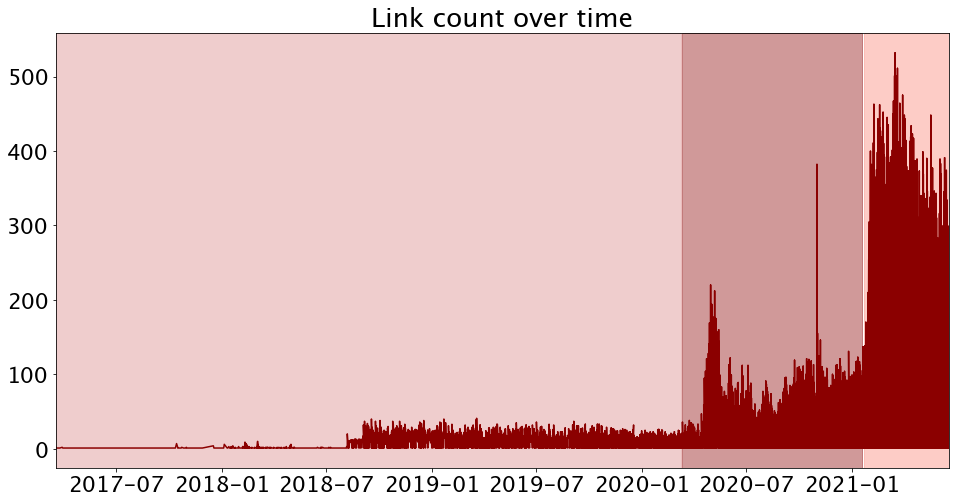

In [70]:
link_count_plot = df5.reset_index()
plt.figure(figsize=(16,8))
plt.margins(0.00, 0.05)
plt.axvspan(dt.date(2017,3,18), dt.date(2020,3,10), color='indianred', alpha=0.3)
plt.axvspan(dt.date(2020,3,11), dt.date(2021,1,19), color='darkred', alpha=0.4)
plt.axvspan(dt.date(2021,1,21), dt.date(2021,6,18), color='salmon', alpha=0.4)
plt.plot(link_count_plot.date, link_count_plot.unique_link_count, color = 'darkred')
plt.title('Link count over time')
plt.show()

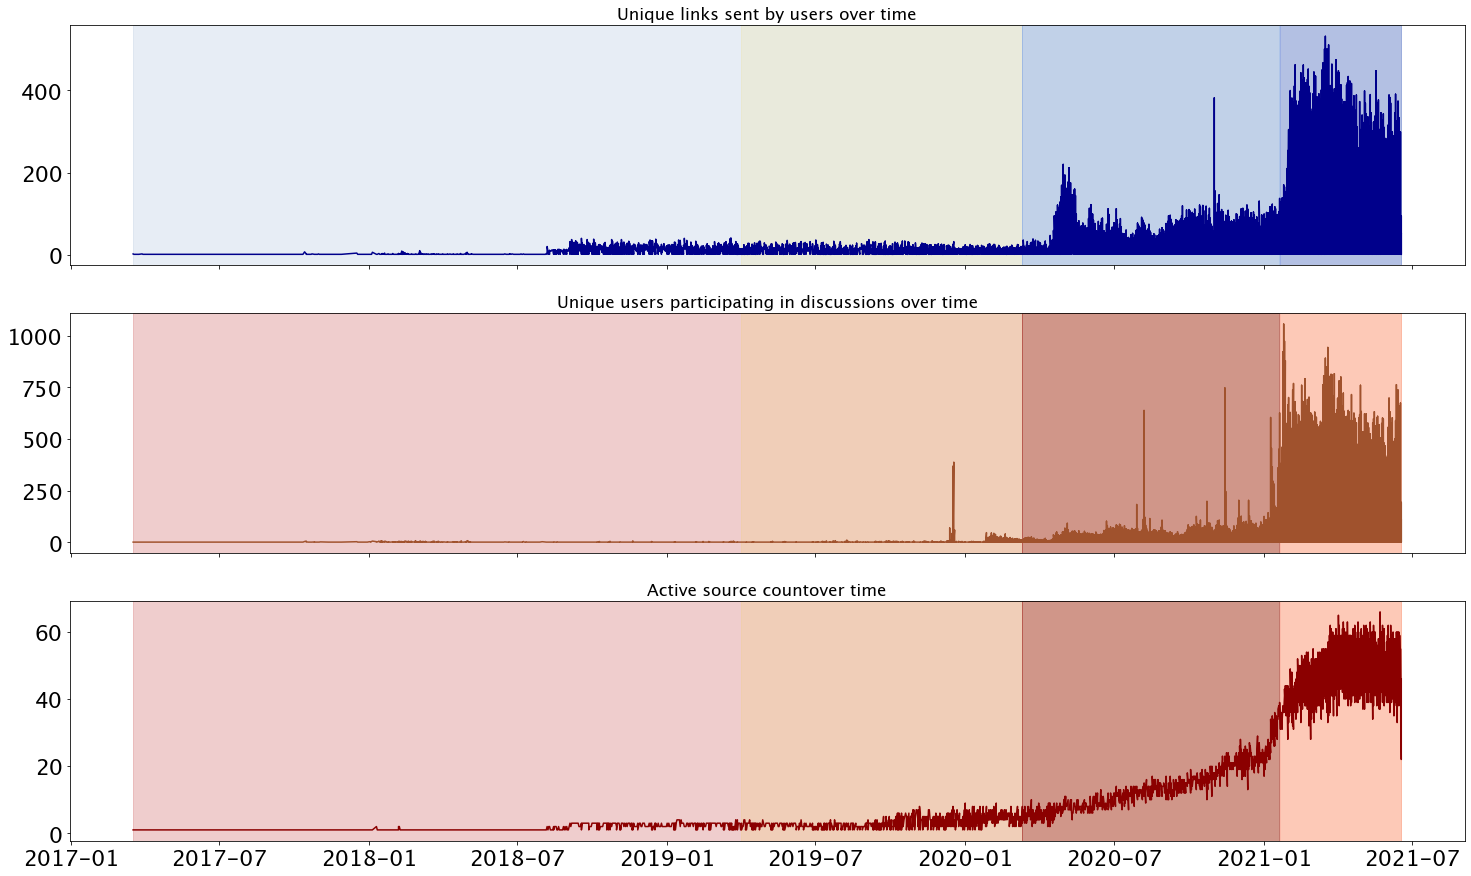

In [71]:
fig, (ax1, ax2, ax3) = plt.subplots(3,sharex=True, figsize = (25,15))
ax1.plot(link_count_plot.date, link_count_plot.unique_link_count, color = 'darkblue')
ax1.set_title('Unique links sent by users over time',fontsize = 17)
ax1.axvspan(dt.date(2017,3,18), dt.date(2020,3,10), color='lightsteelblue', alpha=0.3, linestyle = '-')
ax1.axvspan(dt.date(2019,4,1), dt.date(2021,6,18), color='gold', alpha=0.1, linestyle = '-')
ax1.axvspan(dt.date(2020,3,11), dt.date(2021,1,19), color='cornflowerblue', alpha=0.4, linestyle = '-')
ax1.axvspan(dt.date(2021,1,20), dt.date(2021,6,18), color='royalblue', alpha=0.4,linestyle = '-' )
ax2.plot(user_count_plot.date, user_count_plot.unique_id_count, color = 'sienna')
ax2.set_title('Unique users participating in discussions over time', fontsize = 17)
ax2.axvspan(dt.date(2017,3,18), dt.date(2020,3,10), color='indianred', alpha=0.3,linestyle = '-')
ax2.axvspan(dt.date(2019,4,1), dt.date(2021,6,18), color='gold', alpha=0.1, linestyle = '-')
ax2.axvspan(dt.date(2020,3,11), dt.date(2021,1,19), color='darkred', alpha=0.4, linestyle = '-')
ax2.axvspan(dt.date(2021,1,20), dt.date(2021,6,18), color='salmon', alpha=0.4, linestyle = '-')
ax3.plot(node_plot.date, node_plot.unique_source_count, color = 'darkred')
ax3.set_title('Active source countover time',fontsize = 17 )
ax3.axvspan(dt.date(2017,3,18), dt.date(2020,3,10), color='indianred', alpha=0.3,linestyle = '-')
ax3.axvspan(dt.date(2019,4,1), dt.date(2021,6,18), color='gold', alpha=0.1, linestyle = '-')
ax3.axvspan(dt.date(2020,3,11), dt.date(2021,1,19), color='darkred', alpha=0.4, linestyle = '-')
ax3.axvspan(dt.date(2021,1,20), dt.date(2021,6,18), color='salmon', alpha=0.4, linestyle = '-')
plt.savefig('/Users/m.simonuva.nl/Studies/Study_1/NL-Telegram-nets/figures/Users_links_sources_overtime.png')


## Network analysis trials

In [74]:
#create two dfs: one based on links one on users 
dfl = df[df['links'].notna()]
dfu = df[df['ids'].notna()]

In [1059]:
dfl.reset_index().drop(['url','user_data', 'link_frequency', 'text', 'nolink_text', 'noemoji_text', 'spaced_text'], axis = 1)
dfu.reset_index().drop(['url','user_data', 'link_frequency', 'text', 'nolink_text', 'noemoji_text', 'spaced_text'], axis = 1)

index                      date     source     type           ids  \
0              0 2021-06-18 04:55:38+00:00     fvd_nl     chat  1.036480e+09   
1              1 2021-06-18 01:05:45+00:00     fvd_nl     chat  1.396449e+09   
2              2 2021-06-17 18:22:11+00:00     fvd_nl     chat  1.808984e+09   
3              3 2021-06-17 17:38:00+00:00     fvd_nl     chat  1.697435e+09   
4              4 2021-06-17 13:57:04+00:00     fvd_nl     chat  3.002374e+08   
...          ...                       ...        ...      ...           ...   
2021090  2033658 2021-01-03 10:14:56+00:00  fvdgeluid  channel  1.390936e+09   
2021091  2033659 2021-01-03 09:56:09+00:00  fvdgeluid  channel  1.390936e+09   
2021092  2033660 2021-01-02 23:38:40+00:00  fvdgeluid  channel  1.390936e+09   
2021093  2033661 2021-01-02 23:20:50+00:00  fvdgeluid  channel  1.390936e+09   
2021094  2033662 2021-01-02 23:15:52+00:00  fvdgeluid  channel  1.390936e+09   

         message_id                                         text_clean  \
0           15706.0  wat een aparte namen hebben die zieke kinderen...   
1           15704.0  jufmaikenl doet aan kindermishandeling via psy...   
2           15702.0                                                NaN   
3           15701.0                                                NaN   
4           15700.0  red_exclamation_mark red_exclamation_mark red_...   
...             ...                                                ...   
2021090         7.0                                                NaN   
2021091         6.0  teken deze petitie om aandacht te vragen voor ...   
2021092         5.0                                                NaN   
2021093         2.0  wil je met andere fvd leden in discussie of on...   
2021094         1.0                                                NaN   

                                                     links  \
0                                                      NaN   
1                                                      NaN   
2                                                      NaN   
3                                                      NaN   
4                                                      NaN   
...                                                    ...   
2021090                                                NaN   
2021091  https://secure.avaaz.org/community_petitions/n...   
2021092                                                NaN   
2021093                           https://t.me/fvdgeluiden   
2021094                                                NaN   

                                                text_lower  
0        wat een aparte namen hebben die zieke kinderen...  
1        jufmaike.nl doet aan kindermishandeling via ps...  
2                                                      NaN  
3                                                      NaN  
4        ❗❗❗❗❗❗❗❗❗❗\norale vaccinaties door het drinkwa...  
...                                                    ...  
2021090                                                NaN  
2021091  teken deze petitie om aandacht te vragen voor ...  
2021092                                                NaN  
2021093  wil je met andere fvd leden in discussie of on...  
2021094                                                NaN  

[2021095 rows x 9 columns]

In [1060]:
dfu

date                     url     source     type  \
0       2021-06-18 04:55:38+00:00     https://t.me/fvd_nl     fvd_nl     chat   
1       2021-06-18 01:05:45+00:00     https://t.me/fvd_nl     fvd_nl     chat   
2       2021-06-17 18:22:11+00:00     https://t.me/fvd_nl     fvd_nl     chat   
3       2021-06-17 17:38:00+00:00     https://t.me/fvd_nl     fvd_nl     chat   
4       2021-06-17 13:57:04+00:00     https://t.me/fvd_nl     fvd_nl     chat   
...                           ...                     ...        ...      ...   
2033658 2021-01-03 10:14:56+00:00  https://t.me/fvdgeluid  fvdgeluid  channel   
2033659 2021-01-03 09:56:09+00:00  https://t.me/fvdgeluid  fvdgeluid  channel   
2033660 2021-01-02 23:38:40+00:00  https://t.me/fvdgeluid  fvdgeluid  channel   
2033661 2021-01-02 23:20:50+00:00  https://t.me/fvdgeluid  fvdgeluid  channel   
2033662 2021-01-02 23:15:52+00:00  https://t.me/fvdgeluid  fvdgeluid  channel   

                                                 user_data           ids  \
0        User(id=1036480136, is_self=False, contact=Fal...  1.036480e+09   
1        User(id=1396449004, is_self=False, contact=Fal...  1.396449e+09   
2        User(id=1808984447, is_self=False, contact=Fal...  1.808984e+09   
3        User(id=1697434758, is_self=False, contact=Fal...  1.697435e+09   
4        User(id=300237411, is_self=False, contact=Fals...  3.002374e+08   
...                                                    ...           ...   
2033658  Channel(id=1390936433, title='Forum voor Democ...  1.390936e+09   
2033659  Channel(id=1390936433, title='Forum voor Democ...  1.390936e+09   
2033660  Channel(id=1390936433, title='Forum voor Democ...  1.390936e+09   
2033661  Channel(id=1390936433, title='Forum voor Democ...  1.390936e+09   
2033662  Channel(id=1390936433, title='Forum voor Democ...  1.390936e+09   

         message_id                                         text_clean  \
0           15706.0  wat een aparte namen hebben die zieke kinderen...   
1           15704.0  jufmaikenl doet aan kindermishandeling via psy...   
2           15702.0                                                NaN   
3           15701.0                                                NaN   
4           15700.0  red_exclamation_mark red_exclamation_mark red_...   
...             ...                                                ...   
2033658         7.0                                                NaN   
2033659         6.0  teken deze petitie om aandacht te vragen voor ...   
2033660         5.0                                                NaN   
2033661         2.0  wil je met andere fvd leden in discussie of on...   
2033662         1.0                                                NaN   

                                                     links  link_frequency  \
0                                                      NaN             NaN   
1                                                      NaN             NaN   
2                                                      NaN             NaN   
3                                                      NaN             NaN   
4                                                      NaN             NaN   
...                                                    ...             ...   
2033658                                                NaN             NaN   
2033659  https://secure.avaaz.org/community_petitions/n...             1.0   
2033660                                                NaN             NaN   
2033661                           https://t.me/fvdgeluiden            23.0   
2033662                                                NaN             NaN   

                                                      text  \
0        Wat een aparte namen hebben die zieke kinderen...   
1        Jufmaike.nl doet aan kindermishandeling via ps...   
2                                                      NaN   
3                                                      NaN   
4      

In [1061]:
dfu['ids'] = dfu['ids'].astype(str)

In [1062]:
dfl1= pd.DataFrame(dfl.groupby([pd.Grouper(key = 'source'), 'type', 'message_id'])['links'].agg(lambda x: "  ".join(x))) 
dfu1= pd.DataFrame(dfu.groupby([pd.Grouper(key = 'source'), 'type', 'message_id'])['ids'].agg(lambda x: "  ".join(x))) #urls per channel/chat#urls per channel/chat

In [1063]:
dfl_wide = dfl1.reset_index().pivot("message_id", "source", "links")
dfl_wide.fillna(0)
dfu_wide = dfu1.reset_index().pivot("message_id", "source", "ids")
dfu_wide.fillna(0)

source     BewustmakendNEWSNOW DeBataafseRepubliek DeDagelijkseStandaard  \
message_id                                                                 
1.0                          0                   0          1452944449.0   
2.0               1545657347.0                   0          1452944449.0   
3.0               1460222733.0                   0          1452944449.0   
4.0               1460222733.0                   0          1452944449.0   
5.0               1460222733.0                   0          1452944449.0   
...                        ...                 ...                   ...   
454677.0                     0        1568977595.0                     0   
454678.0                     0        1482823488.0                     0   
454679.0                     0         448938535.0                     0   
454680.0                     0        1571822623.0                     0   
454681.0                     0        1443785553.0                     0   

source      DeKoffieClub         FVDNL Forumvoordemocratiefvd FuckAvondKlok  \
message_id                                                                    
1.0                    0  1472437937.0                      0  1181236877.0   
2.0         1540182723.0             0            923684250.0  1181236877.0   
3.0         1540182723.0  1472437937.0            923684250.0  1181236877.0   
4.0         1540182723.0             0            923684250.0  1181236877.0   
5.0         1527660506.0  1472437937.0            341690367.0  1181236877.0   
...                  ...           ...                    ...           ...   
454677.0               0             0                      0             0   
454678.0               0             0                      0             0   
454679.0               0             0                      0             0   
454680.0               0             0                      0             0   
454681.0               0             0                      0             0   

source          FvDMedia    FvDgroup GeleHesjesCentraal  ... wakkergroningen  \
message_id                                               ...                   
1.0         1381712797.0           0       1461087459.0  ...               0   
2.0         1381712797.0  14726745.0       1461087459.0  ...     904539995.0   
3.0         1381712797.0   1056843.0       1461087459.0  ...     672169751.0   
4.0         1381712797.0  14726745.0       1461087459.0  ...     770180696.0   
5.0         1381712797.0  14726745.0       1461087459.0  ...     770180696.0   
...                  ...         ...                ...  ...             ...   
454677.0               0           0                  0  ...               0   
454678.0               0           0                  0  ...               0   
454679.0               0           0                  0  ...               0   
454680.0               0           0                  0  ...               0   
454681.0               0           0                  0  ...               0   

source     whereWeGo1WeGoAlll   wijdeouders    wilderspvv  \
message_id                                                  
1.0                         0  1257866807.0             0   
2.0              1277268959.0  1257866807.0   527722890.0   
3.0               844034707.0  1257866807.0   527722890.0   
4.0                         0  1257866807.0  1486355599.0   
5.0                         0  1257866807.0  1561451257.0   
...                       ...           ...           ...   
454677.0                    0             0             0   
454678.0                    0             0             0   
454679.0                    0             0             0   
454680.0                    0             0             0   
454681.0                    0             0             0   

source     worldwidenetherlands        wrwynl  wwncommunity     zoektocht  \
message_id                                                             

In [1064]:
dfl_out = pd.DataFrame()

for col in dfl_wide.columns:
    # making a list of all column which has to be compared with col 
    other_col = [x for x in dfl_wide.columns if x!=col]
   #print(other_col)
    for oCol in other_col:
        #print(oCol)
        #using a set to find a intersection between 2 list and count them
        count = len(set(dfl_wide[col].values.tolist()).intersection(dfl_wide[oCol].values.tolist()))#these are unique links 
        normalized = count/len(dfl_wide[col].values)*100
        #storing all count with their respective column in separate df
        dfl_out = dfl_out.append([(col,oCol,count,normalized)],sort=True,ignore_index=True)


dfl_out.columns = ['group','compared_to','no_common_links', 'percentage_common_links']

dfl_out.sort_values(by=['group','no_common_links'],ascending=[False,False],inplace=True)
dfl_out

group                compared_to  no_common_links  \
25282  zorgmedewerkersverenigd        DeBataafseRepubliek                6   
25386  zorgmedewerkersverenigd         nederlandsverzet21                5   
25339  zorgmedewerkersverenigd  coronavaccinsbijwerkingen                4   
25372  zorgmedewerkersverenigd                klokkenchat                4   
25304  zorgmedewerkersverenigd         QPatriotsEindhoven                3   
...                        ...                        ...              ...   
135        BewustmakendNEWSNOW         viruswaanzinbelgie                1   
136        BewustmakendNEWSNOW               viuswaarheid                1   
137        BewustmakendNEWSNOW              vizieroplinks                1   
153        BewustmakendNEWSNOW       worldwidenetherlands                1   
158        BewustmakendNEWSNOW    zorgmedewerkersverenigd                1   

       percentage_common_links  
25282                 0.003530  
25386                 0.002941  
25339                 0.002353  
25372                 0.002353  
25304                 0.001765  
...                        ...  
135                   0.000588  
136                   0.000588  
137                   0.000588  
153                   0.000588  
158                   0.000588  

[25440 rows x 4 columns]

In [1065]:
dfu_out = pd.DataFrame()

for col in dfu_wide.columns:
    # making a list of all column which has to be compared with col 
    other_col = [x for x in dfu_wide.columns if x!=col]
   #print(other_col)
    for oCol in other_col:
        #print(oCol)
        #using a set to find a intersection between 2 list and count them
        count = len(set(dfu_wide[col].values.tolist()).intersection(dfu_wide[oCol].values.tolist()))#these are unique links 
        normalized = count/len(dfu_wide[col].values)*100
        #storing all count with their respective column in separate df
        dfu_out = dfu_out.append([(col,oCol,count,normalized)],sort=True,ignore_index=True)


dfu_out.columns = ['group','compared_to','no_common_users', 'percentage_common_users']

dfu_out.sort_values(by=['group','no_common_users'],ascending=[False,False],inplace=True)
dfu_out

group              compared_to  no_common_users  \
29929  zorgmedewerkersverenigd      BewustmakendNEWSNOW                1   
29930  zorgmedewerkersverenigd      DeBataafseRepubliek                1   
29931  zorgmedewerkersverenigd    DeDagelijkseStandaard                1   
29932  zorgmedewerkersverenigd             DeKoffieClub                1   
29933  zorgmedewerkersverenigd                    FVDNL                1   
...                        ...                      ...              ...   
166        BewustmakendNEWSNOW               wilderspvv                1   
168        BewustmakendNEWSNOW                   wrwynl                1   
170        BewustmakendNEWSNOW                zoektocht                1   
171        BewustmakendNEWSNOW          zondermondkapje                1   
172        BewustmakendNEWSNOW  zorgmedewerkersverenigd                1   

       percentage_common_users  
29929                 0.000224  
29930                 0.000224  
29931                 0.000224  
29932                 0.000224  
29933                 0.000224  
...                        ...  
166                   0.000224  
168                   0.000224  
170                   0.000224  
171                   0.000224  
172                   0.000224  

[30102 rows x 4 columns]

In [1206]:
res_1 = dfl_out[~dfl_out[['group', 'compared_to']].apply(frozenset, axis=1).duplicated()] #remove duplicates
res_2 = dfu_out[~dfu_out[['group', 'compared_to']].apply(frozenset, axis=1).duplicated()] #remove duplicates

In [1207]:
res_1['no_common_links'].max()
res_1[res_1['no_common_links'] == 4561] #wakkerenchat - wakker amsterdam

group      compared_to  no_common_links  percentage_common_links
23678  wakkerenchat  wakkerAmsterdam             4561                 2.683067

In [1208]:
res_2['no_common_users'].max()
res_2[res_2['no_common_users']==3542] #nederlandsverzet21	DeBataafseRepubliek, the two chats with the highest centrality meausures in general

group          compared_to  no_common_users  \
19550  nederlandsverzet21  DeBataafseRepubliek             3542   

       percentage_common_users  
19550                 0.793708

#### Backbone extraction

In [1210]:
bone = res_1[['group', 'compared_to', 'percentage_common_links']]
bone

group                compared_to  \
25282  zorgmedewerkersverenigd        DeBataafseRepubliek   
25386  zorgmedewerkersverenigd         nederlandsverzet21   
25339  zorgmedewerkersverenigd  coronavaccinsbijwerkingen   
25372  zorgmedewerkersverenigd                klokkenchat   
25304  zorgmedewerkersverenigd         QPatriotsEindhoven   
...                        ...                        ...   
477               DeKoffieClub        BewustmakendNEWSNOW   
479               DeKoffieClub      DeDagelijkseStandaard   
319      DeDagelijkseStandaard        DeBataafseRepubliek   
318      DeDagelijkseStandaard        BewustmakendNEWSNOW   
159        DeBataafseRepubliek        BewustmakendNEWSNOW   

       percentage_common_links  
25282                 0.003530  
25386                 0.002941  
25339                 0.002353  
25372                 0.002353  
25304                 0.001765  
...                        ...  
477                   0.000588  
479                   0.000588  
319                   0.102358  
318                   0.003530  
159                   0.354134  

[12720 rows x 3 columns]

In [1212]:
print(range(bone.shape[1]))

bone.columns = range(bone.shape[1])
bone

range(0, 3)


0                          1         2
25282  zorgmedewerkersverenigd        DeBataafseRepubliek  0.003530
25386  zorgmedewerkersverenigd         nederlandsverzet21  0.002941
25339  zorgmedewerkersverenigd  coronavaccinsbijwerkingen  0.002353
25372  zorgmedewerkersverenigd                klokkenchat  0.002353
25304  zorgmedewerkersverenigd         QPatriotsEindhoven  0.001765
...                        ...                        ...       ...
477               DeKoffieClub        BewustmakendNEWSNOW  0.000588
479               DeKoffieClub      DeDagelijkseStandaard  0.000588
319      DeDagelijkseStandaard        DeBataafseRepubliek  0.102358
318      DeDagelijkseStandaard        BewustmakendNEWSNOW  0.003530
159        DeBataafseRepubliek        BewustmakendNEWSNOW  0.354134

[12720 rows x 3 columns]

In [1213]:
new_header = bone.iloc[0] #grab the first row for the header
bone = bone[1:] #take the data less the header row
bone.columns = new_header #set the header row as the df header

In [1218]:
bone

25282  zorgmedewerkersverenigd        DeBataafseRepubliek  \
25386  zorgmedewerkersverenigd         nederlandsverzet21   
25339  zorgmedewerkersverenigd  coronavaccinsbijwerkingen   
25372  zorgmedewerkersverenigd                klokkenchat   
25304  zorgmedewerkersverenigd         QPatriotsEindhoven   
25364  zorgmedewerkersverenigd                 gewoonvrij   
...                        ...                        ...   
477               DeKoffieClub        BewustmakendNEWSNOW   
479               DeKoffieClub      DeDagelijkseStandaard   
319      DeDagelijkseStandaard        DeBataafseRepubliek   
318      DeDagelijkseStandaard        BewustmakendNEWSNOW   
159        DeBataafseRepubliek        BewustmakendNEWSNOW   

25282  0.0035295778624876467  
25386               0.002941  
25339               0.002353  
25372               0.002353  
25304               0.001765  
25364               0.001765  
...                      ...  
477                 0.000588  
479                 0.000588  
319                 0.102358  
318                 0.003530  
159                 0.354134  

[12719 rows x 3 columns]

In [1220]:
bone.set_index('zorgmedewerkersverenigd')

25282                          DeBataafseRepubliek  0.0035295778624876467
zorgmedewerkersverenigd                                                  
zorgmedewerkersverenigd         nederlandsverzet21               0.002941
zorgmedewerkersverenigd  coronavaccinsbijwerkingen               0.002353
zorgmedewerkersverenigd                klokkenchat               0.002353
zorgmedewerkersverenigd         QPatriotsEindhoven               0.001765
zorgmedewerkersverenigd                 gewoonvrij               0.001765
...                                            ...                    ...
DeKoffieClub                   BewustmakendNEWSNOW               0.000588
DeKoffieClub                 DeDagelijkseStandaard               0.000588
DeDagelijkseStandaard          DeBataafseRepubliek               0.102358
DeDagelijkseStandaard          BewustmakendNEWSNOW               0.003530
DeBataafseRepubliek            BewustmakendNEWSNOW               0.354134

[12719 rows x 2 columns]

In [1222]:
#test_sbb = sb.extract(bone, directed = False, significance_threshold = 2.576, vigor_threshold = (-0.1, 0.1))


In [1361]:
GL = nx.from_pandas_edgelist(res_1, 'group', 'compared_to', ['no_common_links', 'percentage_common_links'])
GU = nx.from_pandas_edgelist(res_2, 'group', 'compared_to', ['no_common_users', 'percentage_common_users'])

In [1362]:
print("Link Overlap Graph properties:")
print("Nodes:", GL.number_of_nodes(), "Edges: ", GL.
number_of_edges())
print("\nUser Overlap Graph properties:")
print("Nodes:", GU.number_of_nodes(), "Edges: ", GU.
number_of_edges())

Link Overlap Graph properties:
Nodes: 160 Edges:  12720

User Overlap Graph properties:
Nodes: 174 Edges:  15051


In [1363]:
group_attr = pd.read_csv('/Users/m.simonuva.nl/GitHub/Telegram-scraper/Telegram-scraper/node_attributes.csv')
group_attr = group_attr.loc[:, ~group_attr.columns.str.contains('^Unnamed')]
#group_attr
node_attributes = group_attr.to_dict('records')
#node_attributes

In [1364]:
# We create a dictionary with node names as key and another dict as value. 
# The second-order dict contains a mapping of a feature name (such as "size")
# to the corresponding value for the specific node
# We then merge these features into the graphs

node2attributemap = {n['source']: {'type': n['type'], 'size':n['size']} for n in node_attributes}
# print(node2attributemap)
nx.set_node_attributes(GL, node2attributemap)
nx.set_node_attributes(GU, node2attributemap)
#GT3L.nodes(data=True)

In [1365]:
#Without removing any edges
print("Density in Overlapping links TELEGRAM network : ", nx.density(GL))
print("Transitivity in Overlapping links TELEGRAM network: ", nx.transitivity(GL))
print("\nDensity in Overlapping users TELEGRAM network: ", nx.density(GU))
print("Transitivity in Overlapping users TELEGRAM network: ", nx.transitivity(GU))

Density in Overlapping links TELEGRAM network :  1.0
Transitivity in Overlapping links TELEGRAM network:  1.0

Density in Overlapping users TELEGRAM network:  1.0
Transitivity in Overlapping users TELEGRAM network:  1.0


In [1366]:
edge_weightsl = nx.get_edge_attributes(GL,'no_common_links')
edge_weightsu = nx.get_edge_attributes(GU,'no_common_users')

In [1367]:
#Remove edges below certain thresholf
GL.remove_edges_from((e for e, w in edge_weightsl.items() if w < 2)) #remove edges with less than 5 unique links in common
GU.remove_edges_from((e for e, w in edge_weightsu.items() if w < 2)) #remove edges with less than 5 unique users

In [1368]:
print("Density in Overlapping links TELEGRAM network : ", nx.density(GL))
print("Transitivity in Overlapping links TELEGRAM network: ", nx.transitivity(GL))
print("\nDensity in Overlapping users TELEGRAM network: ", nx.density(GU))
print("Transitivity in Overlapping users TELEGRAM network: ", nx.transitivity(GU))

Density in Overlapping links TELEGRAM network :  0.33773584905660375
Transitivity in Overlapping links TELEGRAM network:  0.7167363202049818

Density in Overlapping users TELEGRAM network:  0.16058733638960868
Transitivity in Overlapping users TELEGRAM network:  0.8320310961116728


In [1369]:
#Remove edges below certain thresholf
GL.remove_edges_from((e for e, w in edge_weightsl.items() if w < 3)) #remove edges with less than 5 unique links in common
GU.remove_edges_from((e for e, w in edge_weightsu.items() if w < 3)) #remove edges with less than 5 unique users

In [1370]:
print("Density in Overlapping links TELEGRAM network : ", nx.density(GL))
print("Transitivity in Overlapping links TELEGRAM network: ", nx.transitivity(GL))
print("\nDensity in Overlapping users TELEGRAM network: ", nx.density(GU))
print("Transitivity in Overlapping users TELEGRAM network: ", nx.transitivity(GU))

Density in Overlapping links TELEGRAM network :  0.2588050314465409
Transitivity in Overlapping links TELEGRAM network:  0.6988173686452357

Density in Overlapping users TELEGRAM network:  0.13347950302305495
Transitivity in Overlapping users TELEGRAM network:  0.8195552153909043


In [1371]:
#Remove edges below certain thresholf
GL.remove_edges_from((e for e, w in edge_weightsl.items() if w < 4)) #remove edges with less than 5 unique links in common
GU.remove_edges_from((e for e, w in edge_weightsu.items() if w < 4)) #remove edges with less than 5 unique users

In [1372]:
print("Density in Overlapping links TELEGRAM network : ", nx.density(GL))
print("Transitivity in Overlapping links TELEGRAM network: ", nx.transitivity(GL))
print("\nDensity in Overlapping users TELEGRAM network: ", nx.density(GU))
print("Transitivity in Overlapping users TELEGRAM network: ", nx.transitivity(GU))

Density in Overlapping links TELEGRAM network :  0.22044025157232705
Transitivity in Overlapping links TELEGRAM network:  0.6881905985674311

Density in Overlapping users TELEGRAM network:  0.11779948176200918
Transitivity in Overlapping users TELEGRAM network:  0.8067447474672935


In [1373]:
#Remove edges below certain thresholf
GL.remove_edges_from((e for e, w in edge_weightsl.items() if w < 5)) #remove edges with less than 5 unique links in common
GU.remove_edges_from((e for e, w in edge_weightsu.items() if w < 5)) #remove edges with less than 5 unique users

In [1704]:
print("Density in Overlapping links TELEGRAM network : ", nx.density(GL))
print("Transitivity in Overlapping links TELEGRAM network: ", nx.transitivity(GL))
print("\nDensity in Overlapping users TELEGRAM network: ", nx.density(GU))
print("Transitivity in Overlapping users TELEGRAM network: ", nx.transitivity(GU))

Density in Overlapping links TELEGRAM network :  0.19630503144654088
Transitivity in Overlapping links TELEGRAM network:  0.6849830517049479

Density in Overlapping users TELEGRAM network:  0.10889641884260182
Transitivity in Overlapping users TELEGRAM network:  0.7993693479295574


In [1375]:
print("Closeness centrality of the Overlapping link Telegram network: \n", nx.closeness_centrality(GL))
print("\nEigenvector centrality of the Overlapping link Telegram network): \n", nx.eigenvector_centrality(GL))
print("\nBetweenness centrality of the link Telegram network: \n", nx.betweenness_centrality(GL))

print("\nNumber of cliques: ", nx.graph_number_of_cliques(GL))
print("Cliques: ", list(nx.find_cliques(GL)))

Closeness centrality of the Overlapping link Telegram network: 
 {'zorgmedewerkersverenigd': 0.3722365161044407, 'DeBataafseRepubliek': 0.6969534769615059, 'nederlandsverzet21': 0.6141902515723271, 'coronavaccinsbijwerkingen': 0.5369969412654225, 'klokkenchat': 0.6824336128581412, 'QPatriotsEindhoven': 0.6381197418933269, 'gewoonvrij': 0.558354774156661, 'ikzorgenbenwakker': 0.4701934940266619, 'wakkerAmsterdam': 0.6639894611592726, 'wakkerenchat': 0.6777271741487747, 'bronvanonvoorwaardelijkeliefde': 0.5520811250088333, 'coronavaccinschatgroep': 0.5489968729138119, 'dvo_open_koffiecorner': 0.5552002274100132, 'fvdgeluid': 0.48409083867769626, 'neetegen15meter': 0.5919906039251346, 'onafhankelijkepers': 0.5091732655521882, 'oudersmetzorgen': 0.5713397689044902, 'samen1voornl': 0.6507976175600817, 'sameninactie': 0.6028861365127137, 'vaccinatiewaarheid': 0.5013797972018996, 'virussenbestaanniet2': 0.4963153548059208, 'vrouwenvoorvrijheid': 0.4466838193253288, 'BewustmakendNEWSNOW': 0.52

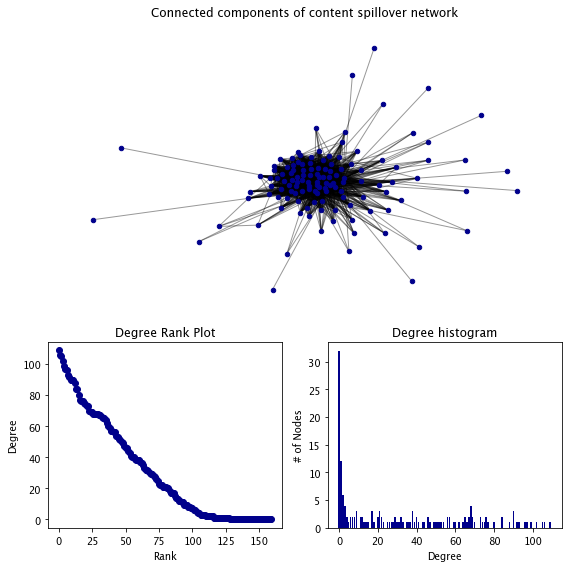

In [1771]:
Gl = GL

degree_sequence = sorted([d for n, d in Gl.degree()], reverse=True)
dmax = max(degree_sequence)

fig = plt.figure("Degree of a random graph", figsize=(8, 8))
# Create a gridspec for adding subplots of different sizes
axgrid = fig.add_gridspec(5, 4)

ax0 = fig.add_subplot(axgrid[0:3, :])
Gcc = Gl.subgraph(sorted(nx.connected_components(GL), key=len, reverse=True)[0])
pos = nx.spring_layout(Gcc, seed=10396953)
nx.draw_networkx_nodes(Gcc, pos, ax=ax0, node_size=20, node_color = 'darkblue')
nx.draw_networkx_edges(Gcc, pos, ax=ax0, alpha=0.4)
ax0.set_title("Connected components of content spillover network")
ax0.set_axis_off()

ax1 = fig.add_subplot(axgrid[3:, :2])
ax1.plot(degree_sequence, "b-", marker="o", color = 'darkblue')
ax1.set_title("Degree Rank Plot")
ax1.set_ylabel("Degree")
ax1.set_xlabel("Rank")

ax2 = fig.add_subplot(axgrid[3:, 2:])
ax2.bar(*np.unique(degree_sequence, return_counts=True), color = 'darkblue')
ax2.set_title("Degree histogram")
ax2.set_xlabel("Degree")
ax2.set_ylabel("# of Nodes")

fig.tight_layout()
#plt.show()
plt.savefig('degree_plots_GL.png')

In [1376]:
#groups that share less links are at disadvantage

{k: v for k, v in sorted(nx.betweenness_centrality(GL).items(), key=lambda item: item[1])}
#''DeBataafseRepubliek': 0.08440598309953515

{k: v for k, v in sorted(nx.closeness_centrality(GL).items(), key=lambda item: item[1])}
#DeBataafseRepubliek': 0.6969534769615059

{k: v for k, v in sorted(nx.eigenvector_centrality(GL).items(), key=lambda item: item[1])}
#'klokkenchat': 0.14821206090750522

{'FuckAvondKlok': 1.3420280707051542e-19,
 'GeleHesjesCentraal': 1.3420280707051542e-19,
 'InfoAvondklok': 1.3420280707051542e-19,
 'JongerenFVD': 1.3420280707051542e-19,
 'Juiste': 1.3420280707051542e-19,
 'Liefdespioniers': 1.3420280707051542e-19,
 'NatuurlijkVrijOnderwijsGO': 1.3420280707051542e-19,
 'QanonNederland': 1.3420280707051542e-19,
 'RechtsVerbonden': 1.3420280707051542e-19,
 'SpiritualiteitOpHollandseBodem': 1.3420280707051542e-19,
 'Waarheid': 1.3420280707051542e-19,
 'XRNLbroadcast': 1.3420280707051542e-19,
 'avondklok': 1.3420280707051542e-19,
 'avondklokn': 1.3420280707051542e-19,
 'bewustzijncentrumapofyliet': 1.3420280707051542e-19,
 'demo_vervoer': 1.3420280707051542e-19,
 'eindhovenrwina': 1.3420280707051542e-19,
 'fakkeltochtemmen2021': 1.3420280707051542e-19,
 'gezelligspiritueel': 1.3420280707051542e-19,
 'ikknaagaandepotenvanRutteenKaag': 1.3420280707051542e-19,
 'mondkapjesontheffing': 1.3420280707051542e-19,
 'onkorrekt': 1.3420280707051542e-19,
 'oudersvoor

In [1377]:
print("Closeness centrality of the Overlapping user Telegram network: \n", nx.closeness_centrality(GU))
print("Eigenvector centrality of the Overlapping user Telegram network): \n", nx.eigenvector_centrality(GU))
print("Betweenness centrality of the user Telegram network: \n", nx.betweenness_centrality(GU))

print("\nNumber of cliques: ", nx.graph_number_of_cliques(GU))
print("Cliques: ", list(nx.find_cliques(GU)))

Closeness centrality of the Overlapping user Telegram network: 
 {'zorgmedewerkersverenigd': 0.0, 'BewustmakendNEWSNOW': 0.24310804802134284, 'DeBataafseRepubliek': 0.43096426694692586, 'DeDagelijkseStandaard': 0.0, 'DeKoffieClub': 0.36466207203201423, 'FVDNL': 0.0, 'Forumvoordemocratiefvd': 0.2851492894084923, 'FuckAvondKlok': 0.0, 'FvDMedia': 0.0, 'FvDgroup': 0.31869626463302086, 'GeleHesjesCentraal': 0.0, 'GeweldTegenWakkeren': 0.31342855777958245, 'InfoAvondklok': 0.3241440640284571, 'JEZUSLEEFTOFFICIAL': 0.2615507275264102, 'JongerenFVD': 0.0, 'Juiste': 0.0, 'Kletschat_burgers_tegen_onrecht': 0.33561819018875644, 'Liefdespioniers': 0.0, 'NLPolitiek': 0.2633670520231214, 'NatuurlijkVrijOnderwijsGO': 0.2083783268754367, 'NederlandWorldWideDemonstration': 0.39920900517188923, 'Nederland_in_het_verzet': 0.36118909991742365, 'PartijDeNieuweMens': 0.2400307309577815, 'PartijDeNieuweMens_chat': 0.235558108641798, 'PolitiekBIJ1': 0.0, 'QPatriotsEindhoven': 0.3511560693641618, 'QanonNederl

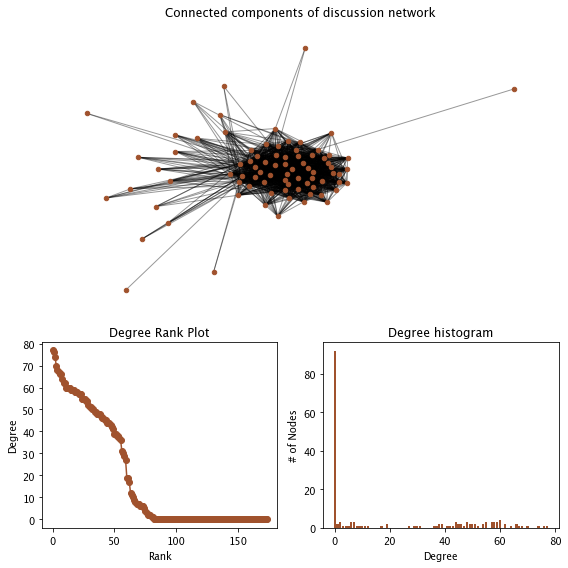

In [1515]:
Gu = GU

degree_sequence = sorted([d for n, d in Gu.degree()], reverse=True)
dmax = max(degree_sequence)

fig = plt.figure("Degree of a random graph", figsize=(8, 8))
# Create a gridspec for adding subplots of different sizes
axgrid = fig.add_gridspec(5, 4)

ax0 = fig.add_subplot(axgrid[0:3, :])
Gcc = Gu.subgraph(sorted(nx.connected_components(GU), key=len, reverse=True)[0])
pos = nx.spring_layout(Gcc, seed=10396953)
nx.draw_networkx_nodes(Gcc, pos, ax=ax0, node_size=20, node_color = 'sienna')
nx.draw_networkx_edges(Gcc, pos, ax=ax0, alpha=0.4)
ax0.set_title("Connected components of discussion network")
ax0.set_axis_off()

ax1 = fig.add_subplot(axgrid[3:, :2])
ax1.plot(degree_sequence, "b-", marker="o", color = 'sienna')
ax1.set_title("Degree Rank Plot")
ax1.set_ylabel("Degree")
ax1.set_xlabel("Rank")

ax2 = fig.add_subplot(axgrid[3:, 2:])
ax2.bar(*np.unique(degree_sequence, return_counts=True), color = 'sienna')
ax2.set_title("Degree histogram")
ax2.set_xlabel("Degree")
ax2.set_ylabel("# of Nodes")

fig.tight_layout()
#plt.show()
plt.savefig('degree_plots_GU.png')

In [1378]:
#disclaimer whe it comes to node importance calculation channels are at disadvantage as there is only one user present 
#as opposed to chats where more users can be in the same chat, increasing the influence of the node
{k: v for k, v in sorted(nx.betweenness_centrality(GU).items(), key=lambda item: item[1])}
#'nederlandsverzet21': 0.0227967323286068

{k: v for k, v in sorted(nx.closeness_centrality(GU).items(), key=lambda item: item[1])}
#'nederlandsverzet21': 0.4791853848457622

{k: v for k, v in sorted(nx.eigenvector_centrality(GU).items(), key=lambda item: item[1])}
#'klokkenchat': 0.15261899003541246

{'zorgmedewerkersverenigd': 1.149655228647308e-13,
 'DeDagelijkseStandaard': 1.149655228647308e-13,
 'FVDNL': 1.149655228647308e-13,
 'FuckAvondKlok': 1.149655228647308e-13,
 'FvDMedia': 1.149655228647308e-13,
 'GeleHesjesCentraal': 1.149655228647308e-13,
 'JongerenFVD': 1.149655228647308e-13,
 'Juiste': 1.149655228647308e-13,
 'Liefdespioniers': 1.149655228647308e-13,
 'PolitiekBIJ1': 1.149655228647308e-13,
 'QanonNederland': 1.149655228647308e-13,
 'Qnld_2020': 1.149655228647308e-13,
 'RechtsVerbonden': 1.149655228647308e-13,
 'RedPillJournal': 1.149655228647308e-13,
 'SpiritualiteitOpHollandseBodem': 1.149655228647308e-13,
 'Waarheid': 1.149655228647308e-13,
 'Waarheid_Eindtijd_Profetie': 1.149655228647308e-13,
 'Wakker2020': 1.149655228647308e-13,
 'WakkerWezen': 1.149655228647308e-13,
 'XRNLbroadcast': 1.149655228647308e-13,
 'artsenvoorvrijheid': 1.149655228647308e-13,
 'avondklok': 1.149655228647308e-13,
 'avondklokamsterdam': 1.149655228647308e-13,
 'avondklokn': 1.149655228647

In [1379]:
print('Overlapping links Telegram network')
print("\nLouvain")
clusterl = community.best_partition(GL)
print(f"Length: {float(len(set(clusterl.values())))}")
print(f"Modularity: {community.modularity(clusterl, GL):.2f}")
#print(f"Membership: {clusterl}")


print("\nPropagating label: ")
clusterl2 = nxcom.asyn_lpa_communities(GL)
c_2 = sorted(clusterl2, key=len, reverse=True)
print("Length: ", len(c_2))
print(f"Modularity: {nxcom.modularity(GL, c_2):.2f}")
#print("Membership: ", c_2)


print('\nOverlapping users Telegram network')
print("\nLouvain")
clusteru = community.best_partition(GU)
print(f"Length: {float(len(set(clusteru.values())))}")
print(f"Modularity: {community.modularity(clusteru, GU):.2f}")
#print(f"Membership: {clusteru}")


print("\nPropagating label: ")
clusteru2 = nxcom.asyn_lpa_communities(GU)
cu2 = sorted(clusteru2, key=len, reverse=True)
print("Length: ", len(cu2))
print(f"Modularity: {nxcom.modularity(GU, cu2):.2f}")
#print("Membership: ", cu2)


Overlapping links Telegram network

Louvain
Length: 35.0
Modularity: 0.10

Propagating label: 
Length:  34
Modularity: 0.00

Overlapping users Telegram network

Louvain
Length: 95.0
Modularity: 0.08

Propagating label: 
Length:  93
Modularity: 0.00


In [1380]:
size_map_l = nx.get_node_attributes(GL, "size")
size_l = list(size_map_l.values())

In [1381]:
size_map_u = nx.get_node_attributes(GU, "size")
size_u = list(size_map_u.values())

In [1382]:
size_u = [0 if x != x else x for x in size_u]
    

import math
clean = [x for x in size_u if math.isnan(x) == False]
print(len(clean))

mean = sum(clean) / len(clean)
#mean
variance = sum([((x - mean) ** 2) for x in clean]) / len(clean)
res = variance ** 0.5
res

In [731]:
{k: v for k, v in sorted(size_map_u.items(), key=lambda item: item[1])}

{'avondkloknl': 6.0,
 'GeleHesjesCentraal': 8.0,
 'SpiritualiteitOpHollandseBodem': 10.0,
 'QanonNederland': 14.0,
 'PartijDeNieuweMens_chat': 15.0,
 'FvDgroup': 19.0,
 'Liefdespioniers': 21.0,
 'Qnld_2020': 24.0,
 'NatuurlijkVrijOnderwijsGO': 26.0,
 'PartijDeNieuweMens': 26.0,
 'Waarheid': 27.0,
 'avondklokamsterdam': 28.0,
 'FuckAvondKlok': 33.0,
 'PolitiekBIJ1': 34.0,
 'FvDMedia': 37.0,
 'Forumvoordemocratiefvd': 48.0,
 'avondklokn': 51.0,
 'RechtsVerbonden': 59.0,
 'GeweldTegenWakkeren': 80.0,
 'NLPolitiek': 96.0,
 'BewustmakendNEWSNOW': 110.0,
 'SpoedWet': 172.0,
 'Kletschat_burgers_tegen_onrecht': 181.0,
 'Waarheid_Eindtijd_Profetie': 221.0,
 'avondklok': 329.0,
 'QPatriotsEindhoven': 342.0,
 'VechtVoorRechtt': 393.0,
 'Juiste': 429.0,
 'Wakker2020': 524.0,
 'JongerenFVD': 548.0,
 'DeKoffieClub': 585.0,
 'Nederland_in_het_verzet': 700.0,
 'zorgmedewerkersverenigd': 949.0,
 'InfoAvondklok': 1120.0,
 'XRNLbroadcast': 1347.0,
 'WijZijnDeVrijheid': 1651.0,
 'NederlandWorldWideDemonst

#### Remove nodes that are not in the link overlap graph so that the two graphs can be compared as multiplex

gulist = []

for e in GU.nodes():
    gulist.append(e)
    
gllist = []

for e in GL.nodes():
    gllist.append(e)
    
#funciton to look for nodes that are not in the node list of GL
def intersection(lst1, lst2):
    lst3 = [value for value in lst1 if value not in lst2]
    return lst3
#list of nodes not in GL
remove = intersection(gulist,gllist)

#remove the node in the list specified above
for x in remove:
    GU.remove_node(x)
    
#new len of GU nodes is 160 (used to be 173)
len(GU.nodes())

In [607]:
#list of nodes that are going to be removed

['PolitiekBIJ1',
 'Qnld_2020',
 'avondklokamsterdam',
 'avondklokzeeland',
 'finaciele/',
 'joumij',
 'liefde_en_verbinding',
 'natuurlijkegezondheid',
 'optochtliefdeenlichtRotterdam',
 'rellen3',
 'viruswaanzinbe',
 'viruswaarheid_zooms',
 'viruswaarheidvideos',
 'vrijheids']

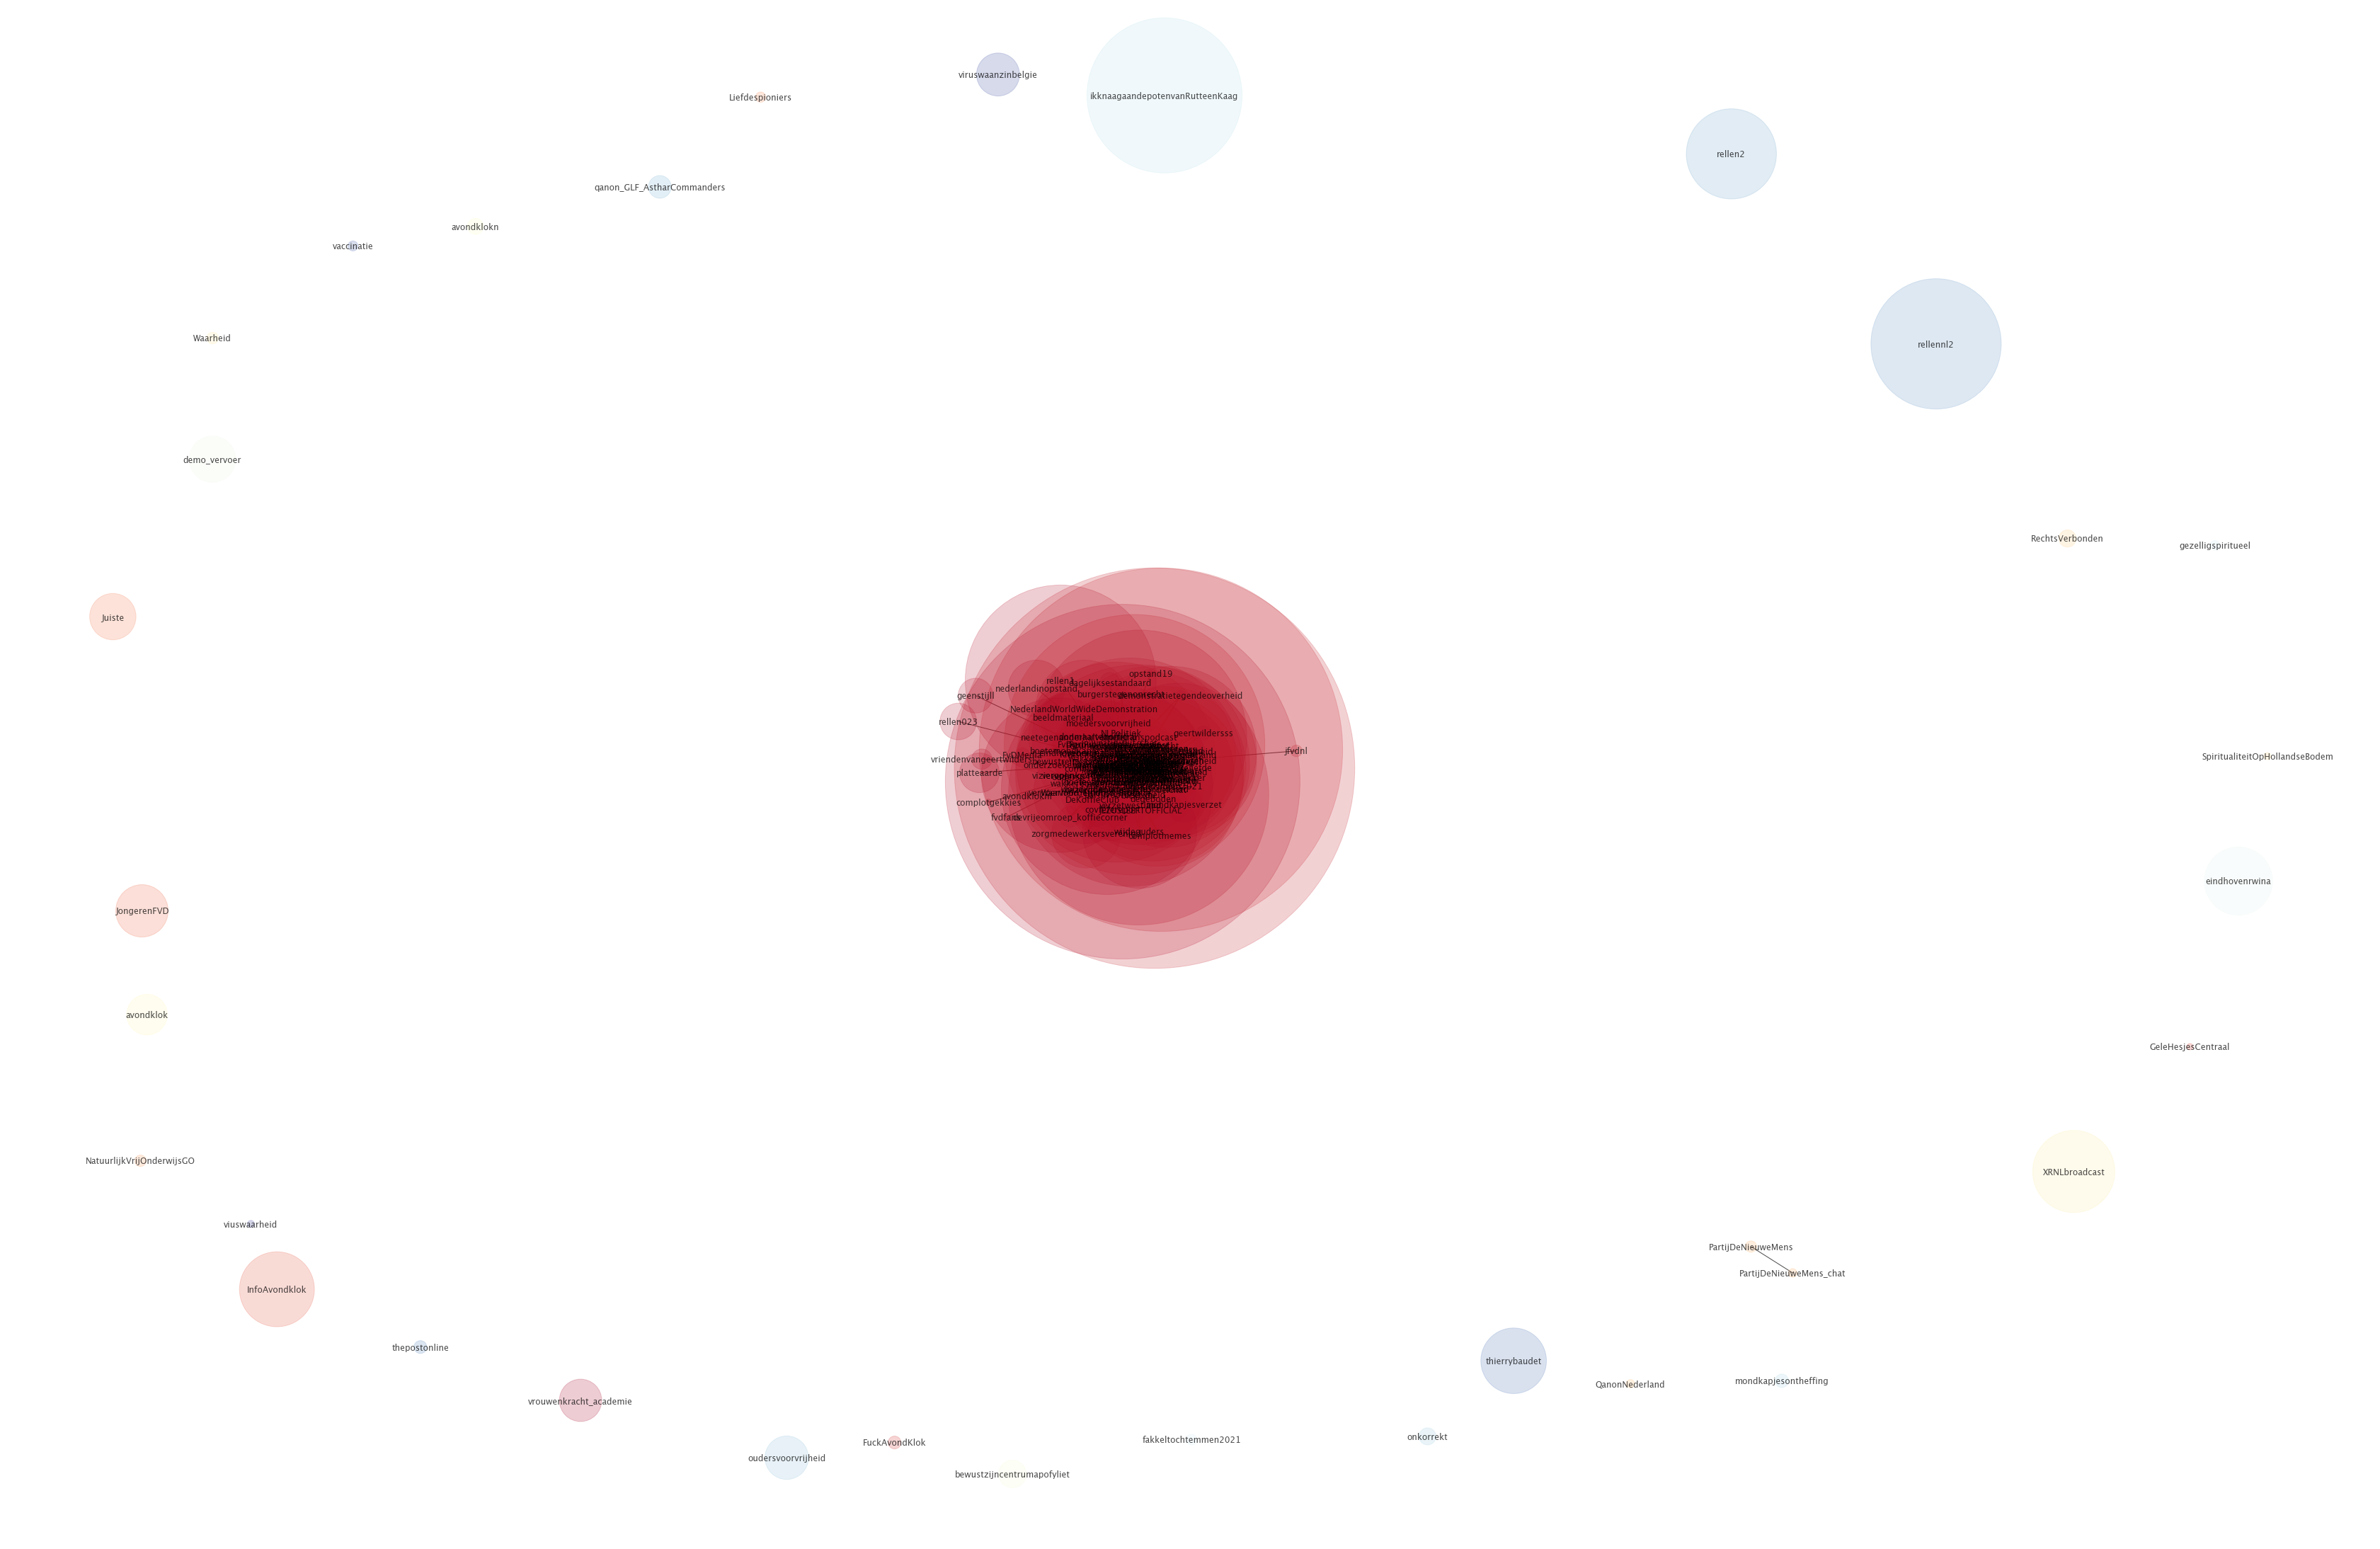

In [1383]:
#Plot with Louvain algortihm Link overlap
pos = nx.spring_layout(GL)
plt.figure(figsize=(60,40))
plt.axis('off')
nx.draw_networkx_labels(GL,pos,font_size=12, font_family = "sans-serif", font_color = "k", alpha = 0.7)
nx.draw_networkx_nodes(GL, pos, cmap=plt.cm.RdYlBu, node_color=list(clusterl.values()), node_size = [x * 10 for x in size_l], alpha = 0.2)
nx.draw_networkx_edges(GL, pos, alpha=0.7, edge_color = "k")
plt.show(GL)

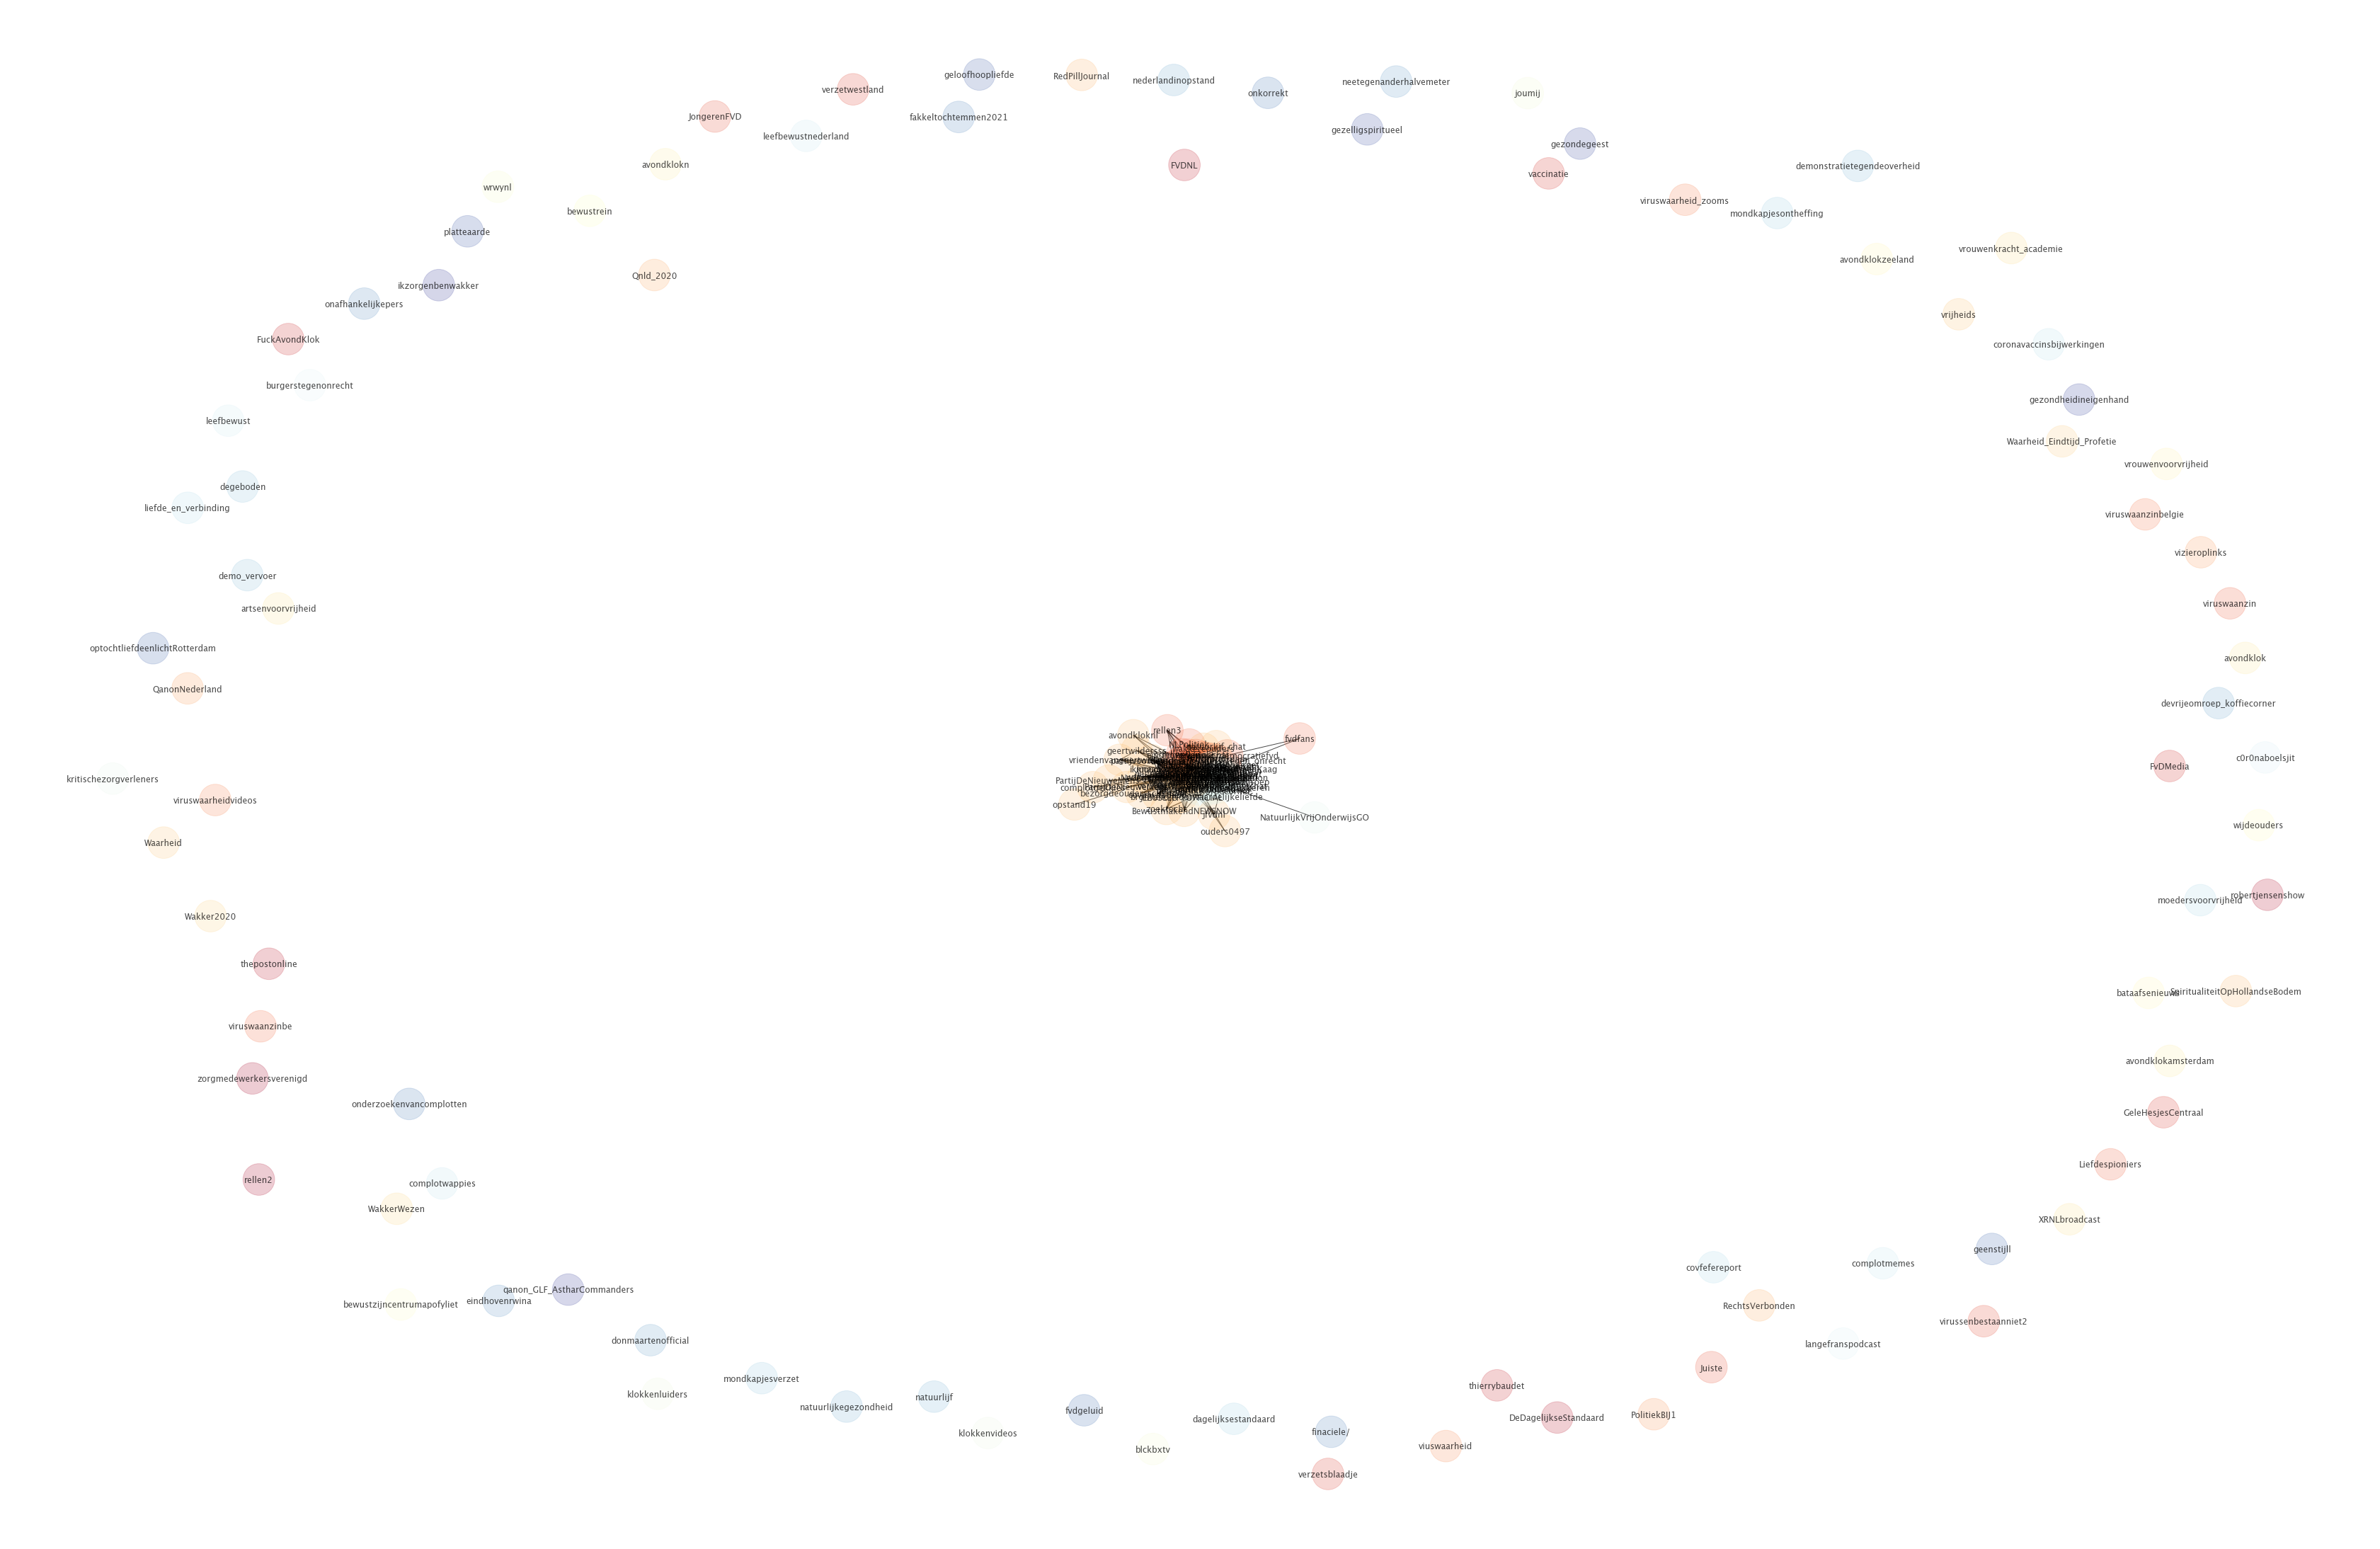

In [1103]:
#Plot with Louvain algortihm Link overlap
pos = nx.spring_layout(GU)
plt.figure(figsize=(60,40))
plt.axis('off')
nx.draw_networkx_labels(GU,pos,font_size=12, font_family = "sans-serif", font_color = "k", alpha = 0.7)
nx.draw_networkx_nodes(GU, pos, cmap=plt.cm.RdYlBu, node_color=list(clusteru.values()), node_size = 2000, alpha = 0.2)
nx.draw_networkx_edges(GU, pos, alpha=0.7, edge_color = "k")
plt.show(GU)

In [1104]:
#igraph
gl = ig.Graph.from_networkx(GL)
gu = ig.Graph.from_networkx(GU)
gl.vs["id"] = gl.vs["_nx_name"]
gu.vs["id"] = gu.vs["_nx_name"]

In [1105]:
del(gl.vs['_nx_name'])
del(gu.vs['_nx_name'])
gl.es["weight"] = gl.es["no_common_links"]
gu.es["weight"] = gu.es["no_common_users"]

In [1106]:
for e in gu.vs():
    print(e)

igraph.Vertex(<igraph.Graph object at 0x7f91f2288c70>, 0, {'type': 'channel', 'size': 949.0, 'id': 'zorgmedewerkersverenigd'})
igraph.Vertex(<igraph.Graph object at 0x7f91f2288c70>, 1, {'type': 'chat', 'size': 110.0, 'id': 'BewustmakendNEWSNOW'})
igraph.Vertex(<igraph.Graph object at 0x7f91f2288c70>, 2, {'type': 'chat', 'size': 7989.0, 'id': 'DeBataafseRepubliek'})
igraph.Vertex(<igraph.Graph object at 0x7f91f2288c70>, 3, {'type': 'channel', 'size': 3048.0, 'id': 'DeDagelijkseStandaard'})
igraph.Vertex(<igraph.Graph object at 0x7f91f2288c70>, 4, {'type': 'chat', 'size': 585.0, 'id': 'DeKoffieClub'})
igraph.Vertex(<igraph.Graph object at 0x7f91f2288c70>, 5, {'type': 'channel', 'size': 26346.0, 'id': 'FVDNL'})
igraph.Vertex(<igraph.Graph object at 0x7f91f2288c70>, 6, {'type': 'chat', 'size': 48.0, 'id': 'Forumvoordemocratiefvd'})
igraph.Vertex(<igraph.Graph object at 0x7f91f2288c70>, 7, {'type': 'channel', 'size': 33.0, 'id': 'FuckAvondKlok'})
igraph.Vertex(<igraph.Graph object at 0x7f91

In [1257]:
print('Overlapping link Telegram network:')
print(f"Number of chats/channels in biggest connected compenent within link overlap network: {len(gl.clusters().giant().vs['id'])}")
print(f"List of chats/channels in biggest connected compenent within link overlap network: \n{gl.clusters().giant().vs['id']}")

Overlapping link Telegram network:
Number of chats/channels in biggest connected compenent within link overlap network: 126
List of chats/channels in biggest connected compenent within link overlap network: 
['zorgmedewerkersverenigd', 'DeBataafseRepubliek', 'nederlandsverzet21', 'coronavaccinsbijwerkingen', 'klokkenchat', 'QPatriotsEindhoven', 'gewoonvrij', 'ikzorgenbenwakker', 'wakkerAmsterdam', 'wakkerenchat', 'bronvanonvoorwaardelijkeliefde', 'coronavaccinschatgroep', 'dvo_open_koffiecorner', 'fvdgeluid', 'neetegen15meter', 'onafhankelijkepers', 'oudersmetzorgen', 'samen1voornl', 'sameninactie', 'vaccinatiewaarheid', 'virussenbestaanniet2', 'vrouwenvoorvrijheid', 'BewustmakendNEWSNOW', 'DeDagelijkseStandaard', 'DeKoffieClub', 'FVDNL', 'Forumvoordemocratiefvd', 'FvDMedia', 'FvDgroup', 'GeweldTegenWakkeren', 'JEZUSLEEFTOFFICIAL', 'Kletschat_burgers_tegen_onrecht', 'NLPolitiek', 'NederlandWorldWideDemonstration', 'Nederland_in_het_verzet', 'RedPillJournal', 'SpoedWet', 'VechtVoorRecht

In [1258]:
print('Overlapping user Telegram network:')
print(f"Number of chats/channels in biggest connected compenent within user overlap network: {len(gu.clusters().giant().vs['id'])}")
print(f"List of chats/channels in biggest connected compenent within user overlap network: \n{gu.clusters().giant().vs['id']}")

Overlapping user Telegram network:
Number of chats/channels in biggest connected compenent within user overlap network: 82
List of chats/channels in biggest connected compenent within user overlap network: 
['BewustmakendNEWSNOW', 'DeBataafseRepubliek', 'DeKoffieClub', 'Forumvoordemocratiefvd', 'FvDgroup', 'GeweldTegenWakkeren', 'InfoAvondklok', 'JEZUSLEEFTOFFICIAL', 'Kletschat_burgers_tegen_onrecht', 'NLPolitiek', 'NatuurlijkVrijOnderwijsGO', 'NederlandWorldWideDemonstration', 'Nederland_in_het_verzet', 'PartijDeNieuweMens', 'PartijDeNieuweMens_chat', 'QPatriotsEindhoven', 'SpoedWet', 'VechtVoorRechtt', 'WijZijnDeVrijheid', 'avondkloknl', 'beeldmateriaal', 'bezorgdeoudersschijndelchat', 'boereninopstand', 'boereninopstand2_0', 'boete_avondklok', 'boetemondkapje', 'bronvanonvoorwaardelijkeliefde', 'burgerwachtNio', 'cafeweltschmerz', 'complotgekkies', 'coronavaccinschatgroep', 'covidwaarheid', 'deelwatjeweet', 'defendrotterdam', 'denhaaginopstand', 'deparallellemaatschappij', 'deredact

In [1766]:
nx.write_graphml_lxml(GL, "GL.graphml")
nx.write_graphml_lxml(GU, "GU.graphml")

### Run Leiden algorithm and return clustering element containing graph, communities and subgraphs

In [1764]:
def leiden(graph):
    graphname = f'{graph=}'.split('=')[0]
    #use built in igraph leiden solution
    community = graph.community_leiden(objective_function='modularity', weights='weight', resolution_parameter=0.02, initial_membership=None, n_iterations=-1)
    print('modularity =', community.modularity)
    # print summary of communites and largest communities
    print(community.summary(verbosity=0))
    a = community.sizes()
    a.sort(reverse=True)
    print("Top 5 biggest clusters:" ,a[0:5])
    graph.vs['community'] = community.membership
    return(community)

In [1765]:
print('Overlapping links Telegram network')
leiden(gl)
print('\nOverlapping users Telegram network')
leiden(gu)

Overlapping links Telegram network
modularity = 0.0001017472779969445
Clustering with 160 elements and 34 clusters
Top 5 biggest clusters: [126, 2, 1, 1, 1]

Overlapping users Telegram network
modularity = 0.0
Clustering with 174 elements and 93 clusters
Top 5 biggest clusters: [82, 1, 1, 1, 1]


In [1265]:
print(f'Share of nodes of biggest connected component in overlapping links Telegram network is {126/160*100} percent')
print(f'\nShare of nodes of biggest connected component in overlapping user Telegram network is {82/174*100} percent')

Share of nodes of biggest connected component in overlapping links Telegram network is 78.75 percent

Share of nodes of biggest connected component in overlapping user Telegram network is 47.12643678160919 percent


## Create time slices based on significant events within the timeline of data set

T1 = from the first data point (2017/03/18) till a day before the WHO declared COVID-19 as a pandemic (2020/03/10)
T2 = From the date WHO declares COVID-19 as a pandemic (2020/03/11) till a day before the Dutch government introduces the hard lockdown that included a curfew (2021/01/19)
T3 = From the day of the curfew (2021/01/20) till the last datapoint in dataset (2021/06/18)

In [1109]:
df_T1 =df['2017-03-18':'2020-03-10'] #covid is a pandemic according to the who 11/3/2020
df_T1 #55,309 rows
df_T1.to_csv('/Users/m.simonuva.nl/GitHub/Telegram-scraper/Telegram-scraper/T1_data.csv')

In [1110]:
df_T2 = df['2020-03-11': '2021-01-19'] #T2 = before the introduction of the curfew measure
df_T2 #486,181 rows
df_T2.to_csv('/Users/m.simonuva.nl/GitHub/Telegram-scraper/Telegram-scraper/T2_data.csv')

In [1111]:
df_T3 = df['2021-01-20': '2021-06-18'] #T3 = after the introduction of the curfew measure until last datapoint
df_T3 #1,492,171 rows 
df_T3.to_csv('/Users/m.simonuva.nl/GitHub/Telegram-scraper/Telegram-scraper/T3_data.csv')

In [1112]:
#drop unnecessary columns
df_T1.reset_index().drop(['url','user_data', 'link_frequency', 'text', 'nolink_text', 'noemoji_text', 'spaced_text'], axis = 1)
df_T2.reset_index().drop(['url','user_data', 'link_frequency', 'text', 'nolink_text', 'noemoji_text', 'spaced_text'], axis = 1)
df_T3.reset_index().drop(['url','user_data', 'link_frequency', 'text', 'nolink_text', 'noemoji_text', 'spaced_text'], axis = 1)

date                  source     type  \
0       2021-01-20 00:00:04+00:00             klokkenchat     chat   
1       2021-01-20 00:00:05+00:00            wakkerenchat     chat   
2       2021-01-20 00:00:31+00:00            wakkerenchat     chat   
3       2021-01-20 00:00:48+00:00      nederlandsverzet21     chat   
4       2021-01-20 00:00:55+00:00            wwncommunity     chat   
...                           ...                     ...      ...   
1492166 2021-06-18 16:34:19+00:00   mondkapjesverzetgroep     chat   
1492167 2021-06-18 16:43:29+00:00  coronavaccinschatgroep  channel   
1492168 2021-06-18 16:45:11+00:00  coronavaccinschatgroep  channel   
1492169 2021-06-18 16:45:19+00:00   mondkapjesverzetgroep     chat   
1492170 2021-06-18 16:49:57+00:00  coronavaccinschatgroep  channel   

                  ids  message_id  \
0        9.192846e+08     40885.0   
1        1.236872e+09    189834.0   
2        1.236872e+09    189835.0   
3        5.872321e+08      9733.0   
4        8.393439e+08     11440.0   
...               ...         ...   
1492166  1.373812e+09     52303.0   
1492167  1.187005e+09      8070.0   
1492168  1.187005e+09      8071.0   
1492169  1.067769e+09     52304.0   
1492170  1.757394e+09      8072.0   

                                                text_clean links  \
0        niets van het coronabeleid is logisch als je n...   NaN   
1        en ja 1e lijn 2e lijn zijn pillen verkopers va...   NaN   
2                                       is nu de prepp act   NaN   
3                                                      NaN   NaN   
4        hey tommy je hebt helemaal gelijk de maatregel...   NaN   
...                                                    ...   ...   
1492166                                                NaN   NaN   
1492167  the new hippocratic oath\n\nUnited_States  tme...   NaN   
1492168             truth\n\nyellow_circle  tmehopenotfear   NaN   
1492169                                                NaN   NaN   
1492170                                                NaN   NaN   

                                                text_lower  
0        niets van het corona-beleid is logisch als je ...  
1        en ja 1e lijn 2e lijn zijn pillen verkopers va...  
2                                       is nu de prepp act  
3                                                      NaN  
4        hey tommy je hebt helemaal gelijk de maatregel...  
...                                                    ...  
1492166                                                NaN  
1492167   the new hippocratic oath\n\n🇺🇸 t.me/theghostezra  
1492168                       truth!\n\n🟡 t.me/hopenotfear  
1492169                                                NaN  
1492170                                                NaN  

[1492171 rows x 8 columns]

## Remove NANs on links and users for input for two kinds of temporal network models

One is meant is based on overlapping unique links as edges, while the other one on overlapping users as edges.
Each input will be used for temporal community detection using the Leiden algorithm. 

### Input for temporal community detection in network models using overlapping links as edges

In [1113]:
df_T1L = df_T1[df_T1['links'].notna()]  #23,046 rows
df_T1L.to_csv('/Users/m.simonuva.nl/GitHub/Telegram-scraper/Telegram-scraper/T1_link_data.csv')
df_T2L = df_T2[df_T2['links'].notna()]  #94,738 rows 
df_T2L.to_csv('/Users/m.simonuva.nl/GitHub/Telegram-scraper/Telegram-scraper/T2_link_data.csv')
df_T3L = df_T3[df_T3['links'].notna()]  #245,053 rows
df_T3L.to_csv('/Users/m.simonuva.nl/GitHub/Telegram-scraper/Telegram-scraper/T3_link_data.csv')

#### Group each slice by source, type, message_id and links

In [1114]:
df1_T1L= pd.DataFrame(df_T1L.groupby([pd.Grouper(key = 'source'), 'type', 'message_id'])['links'].agg(lambda x: "  ".join(x))) #urls per channel/chat
df1_T2L= pd.DataFrame(df_T2L.groupby([pd.Grouper(key = 'source'), 'type', 'message_id'])['links'].agg(lambda x: "  ".join(x))) #urls per channel/chat
#df1_T2L['links'].iloc[108]
df1_T3L= pd.DataFrame(df_T3L.groupby([pd.Grouper(key = 'source'), 'type', 'message_id'])['links'].agg(lambda x: "  ".join(x))) #urls per channel/chat
#df1_T3L['links'].iloc[108]

#### Create wide tables for each time slice

In [1115]:
T1L_wide = df1_T1L.reset_index().pivot("message_id", "source", "links")
T1L_wide.fillna(0)
T2L_wide = df1_T2L.reset_index().pivot("message_id", "source", "links")
T2L_wide.fillna(0)
T3L_wide = df1_T3L.reset_index().pivot("message_id", "source", "links")
T3L_wide.fillna(0)

source             BewustmakendNEWSNOW  \
message_id                               
2.0                                  0   
3.0                                  0   
4.0         https://t.me/hsretoucher17   
5.0         https://t.me/hsretoucher17   
6.0                                  0   
...                                ...   
454667.0                             0   
454669.0                             0   
454673.0                             0   
454674.0                             0   
454679.0                             0   

source                                    DeBataafseRepubliek  \
message_id                                                      
2.0                                                         0   
3.0                                                         0   
4.0                                                         0   
5.0                                                         0   
6.0                                                         0   
...                                                       ...   
454667.0                         https://youtu.be/nQqGmV8CelI   
454669.0      https://www.facebook.com/events/963571347783909   
454673.0                        https://youtu.be/59RgW5GirtE)   
454674.0    https://rumble.com/vinunl-gene-decode-intervie...   
454679.0                  https://file.wikileaks.org/file/...   

source     DeDagelijkseStandaard DeKoffieClub FVDNL Forumvoordemocratiefvd  \
message_id                                                                   
2.0                            0            0     0                      0   
3.0                            0            0     0                      0   
4.0                            0            0     0                      0   
5.0                            0            0     0                      0   
6.0                            0            0     0                      0   
...                          ...          ...   ...                    ...   
454667.0                       0            0     0                      0   
454669.0                       0            0     0                      0   
454673.0                       0            0     0                      0   
454674.0                       0            0     0                      0   
454679.0                       0            0     0                      0   

source                   FuckAvondKlok FvDMedia FvDgroup GeweldTegenWakkeren  \
message_id                                                                     
2.0                                  0        0        0                   0   
3.0                                  0        0        0                   0   
4.0                                  0        0        0                   0   
5.0         https://t.me/FuckAvondKlok        0        0                   0   
6.0                                  0        0        0                   0   
...                                ...      ...      ...                 ...   
454667.0                             0        0        0                   0   
454669.0                             0        0        0                   0   
454673.0                             0        0        0                   0   
454674.0                             0        0        0                   0   
454679.0                             0        0        0                   0   

source      ... wakkergroningen whereWeGo1WeGoAlll  \
message_id  ...                                      
2.0         ...               0                  0   
3.0         ...               0                  0   
4.0         ...               0                  0   
5.0         ...               0                  0   
6.0         ...               0                  0   
...         ...             ...                ...   
454667.0    ...               0                  0   
454669.0    ...               0                  0   
454673.0   

#### Create intersection between two groups(chat/channel) per time slice

Using sets to put the values into two list (col, oCol) the intersection fucntion looks at unique matches between the two lists.
#set([1,1,2,3,4]) keep in mind that sets only look at unique values in a list
Look at both the number of unique values between two lists and the percentage of unique values between two lists 
Divide the total number of unique values shared by the total number of unique values in col
Append the new column to a dataframe where each group is compared to another group one by one
no_common_links and percentage_common_links shows the overlap of link sharing between groups

In [1116]:
T1L_out = pd.DataFrame()

for col in T1L_wide.columns:
    # making a list of all column which has to be compared with col 
    other_col = [x for x in T1L_wide.columns if x!=col]
   #print(other_col)
    for oCol in other_col:
        #print(oCol)
        #using a set to find a intersection between 2 list and count them
        count = len(set(T1L_wide[col].values.tolist()).intersection(T1L_wide[oCol].values.tolist()))#these are unique links 
        normalized = count/len(T1L_wide[col].values)*100
        #storing all count with their respective column in separate df
        T1L_out = T1L_out.append([(col,oCol,count,normalized)],sort=True,ignore_index=True)


T1L_out.columns = ['group','compared_to','no_common_links', 'percentage_common_links']

T1L_out.sort_values(by=['group','no_common_links'],ascending=[False,False],inplace=True)
T1L_out

group                      compared_to  no_common_links  \
361  vrijheid                         FvDgroup                1   
362  vrijheid               GeleHesjesCentraal                1   
363  vrijheid  Kletschat_burgers_tegen_onrecht                1   
364  vrijheid                       NLPolitiek                1   
365  vrijheid                         Waarheid                1   
..        ...                              ...              ...   
14   FvDgroup       qanon_GLF_AstharCommanders                1   
15   FvDgroup                    thepostonline                1   
16   FvDgroup                    thierrybaudet                1   
17   FvDgroup                   verzetwestland                1   
18   FvDgroup                         vrijheid                1   

     percentage_common_links  
361                 0.008453  
362                 0.008453  
363                 0.008453  
364                 0.008453  
365                 0.008453  
..                       ...  
14                  0.008453  
15                  0.008453  
16                  0.008453  
17                  0.008453  
18                  0.008453  

[380 rows x 4 columns]

In [1117]:
T2L_out = pd.DataFrame()

for col in T2L_wide.columns:
    # making a list of all column which has to be compared with col 
    other_col = [x for x in T2L_wide.columns if x!=col]
   #print(other_col)
    for oCol in other_col:
        #print(oCol)
        #using a set to find a intersection between 2 list and count them
        count = len(set(T2L_wide[col].values.tolist()).intersection(T2L_wide[oCol].values.tolist()))#these are unique links 
        normalized = count/len(T2L_wide[col].values)*100
        #storing all count with their respective column in separate df
        T2L_out = T2L_out.append([(col,oCol,count,normalized)],sort=True,ignore_index=True)


T2L_out.columns = ['group','compared_to','no_common_links', 'percentage_common_links']

T2L_out.sort_values(by=['group','no_common_links'],ascending=[False,False],inplace=True)
T2L_out

group         compared_to  no_common_links  \
7977              zoektocht  nederlandsverzet21              102   
8007              zoektocht  whereWeGo1WeGoAlll               19   
7986              zoektocht        samen1voornl               17   
8009              zoektocht        wwncommunity               14   
7966              zoektocht         klokkenchat               13   
...                     ...                 ...              ...   
84    DeDagelijkseStandaard     wakkergroningen                1   
85    DeDagelijkseStandaard  whereWeGo1WeGoAlll                1   
86    DeDagelijkseStandaard          wilderspvv                1   
87    DeDagelijkseStandaard        wwncommunity                1   
88    DeDagelijkseStandaard           zoektocht                1   

      percentage_common_links  
7977                 0.188005  
8007                 0.035020  
7986                 0.031334  
8009                 0.025805  
7966                 0.023961  
...                       ...  
84                   0.001843  
85                   0.001843  
86                   0.001843  
87                   0.001843  
88                   0.001843  

[8010 rows x 4 columns]

In [1118]:
T3L_out = pd.DataFrame()

for col in T3L_wide.columns:
    # making a list of all column which has to be compared with col 
    other_col = [x for x in T3L_wide.columns if x!=col]
   #print(other_col)
    for oCol in other_col:
        #print(oCol)
        #using a set to find a intersection between 2 list and count them
        count = len(set(T3L_wide[col].values.tolist()).intersection(T3L_wide[oCol].values.tolist()))#these are unique links 
        normalized = count/len(T3L_wide[col].values)*100
        #storing all count with their respective column in separate df
        T3L_out = T3L_out.append([(col,oCol,count,normalized)],sort=True,ignore_index=True)


T3L_out.columns = ['group','compared_to','no_common_links', 'percentage_common_links']

T3L_out.sort_values(by=['group','no_common_links'],ascending=[False,False],inplace=True)
T3L_out

group                compared_to  no_common_links  \
21610  zorgmedewerkersverenigd        DeBataafseRepubliek                6   
21706  zorgmedewerkersverenigd         nederlandsverzet21                5   
21660  zorgmedewerkersverenigd  coronavaccinsbijwerkingen                4   
21693  zorgmedewerkersverenigd                klokkenchat                4   
21631  zorgmedewerkersverenigd         QPatriotsEindhoven                3   
...                        ...                        ...              ...   
123        BewustmakendNEWSNOW               viruswaanzin                1   
124        BewustmakendNEWSNOW         viruswaanzinbelgie                1   
125        BewustmakendNEWSNOW              vizieroplinks                1   
141        BewustmakendNEWSNOW       worldwidenetherlands                1   
146        BewustmakendNEWSNOW    zorgmedewerkersverenigd                1   

       percentage_common_links  
21610                 0.003983  
21706                 0.003319  
21660                 0.002655  
21693                 0.002655  
21631                 0.001991  
...                        ...  
123                   0.000664  
124                   0.000664  
125                   0.000664  
141                   0.000664  
146                   0.000664  

[21756 rows x 4 columns]

In [1119]:
#Remove duplicate pairs
res_T1L = T1L_out[~T1L_out[['group', 'compared_to']].apply(frozenset, axis=1).duplicated()] #remove duplicates
res_T2L = T2L_out[~T2L_out[['group', 'compared_to']].apply(frozenset, axis=1).duplicated()] #remove duplicates
res_T3L = T3L_out[~T3L_out[['group', 'compared_to']].apply(frozenset, axis=1).duplicated()] #remove duplicates

##### Max number of common links per intersection 

In [1120]:
#T1
res_T1L['no_common_links'].max()
res_T1L[res_T1L['no_common_links'] == 244]

group compared_to  no_common_links  percentage_common_links
279  natuurlijf_chat  natuurlijf              244                 2.062553

In [1121]:
#T2
res_T2L['no_common_links'].max()
res_T2L[res_T2L['no_common_links'] == 1956]

group      compared_to  no_common_links  percentage_common_links
7558  wakkerenchat  wakkerAmsterdam             1956                 3.605264

In [1122]:
#T3
res_T3L['no_common_links'].max()
res_T3L[res_T3L['no_common_links'] == 4040]

group          compared_to  no_common_links  \
14260  nederlandsverzet21  DeBataafseRepubliek             4040   

       percentage_common_links  
14260                 2.681855

In [1123]:
res_T1L.sort_values(by='percentage_common_links', ascending=False)

group                      compared_to  no_common_links  \
279      natuurlijf_chat                       natuurlijf              244   
209           geenstijll                         FvDgroup                8   
174  dagelijksestandaard                       NLPolitiek                5   
116       beeldmateriaal  Kletschat_burgers_tegen_onrecht                4   
315        thepostonline                       geenstijll                3   
..                   ...                              ...              ...   
314        thepostonline               donmaartenofficial                1   
316        thepostonline                       leefbewust                1   
317        thepostonline                       natuurlijf                1   
318        thepostonline                  natuurlijf_chat                1   
19    GeleHesjesCentraal                         FvDgroup                1   

     percentage_common_links  
279                 2.062553  
209                 0.067625  
174                 0.042265  
116                 0.033812  
315                 0.025359  
..                       ...  
314                 0.008453  
316                 0.008453  
317                 0.008453  
318                 0.008453  
19                  0.008453  

[190 rows x 4 columns]

In [1124]:
res_T2L.sort_values(by='percentage_common_links', ascending=False)

group            compared_to  no_common_links  \
7558     wakkerenchat        wakkerAmsterdam             1956   
7541     wakkerenchat           samen1voornl             1570   
7363  wakkerAmsterdam           samen1voornl              833   
7521     wakkerenchat            klokkenchat              751   
7630  wakkergroningen           samen1voornl              731   
...               ...                    ...              ...   
6194       vaccinatie             natuurlijf                1   
6195       vaccinatie        natuurlijf_chat                1   
6196       vaccinatie     nederlandinopstand                1   
6197       vaccinatie     nederlandsverzet21                1   
89              FVDNL  DeDagelijkseStandaard                1   

      percentage_common_links  
7558                 3.605264  
7541                 2.893796  
7363                 1.535371  
7521                 1.384230  
7630                 1.347366  
...                       ...  
6194                 0.001843  
6195                 0.001843  
6196                 0.001843  
6197                 0.001843  
89                   0.001843  

[4005 rows x 4 columns]

In [1125]:
res_T3L.sort_values(by='percentage_common_links', ascending=False)

group             compared_to  no_common_links  \
14260        nederlandsverzet21     DeBataafseRepubliek             4040   
12349               klokkenchat     DeBataafseRepubliek             3918   
20126              wakkerenchat         wakkerAmsterdam             2573   
3235         QPatriotsEindhoven     DeBataafseRepubliek             2237   
5293             bataafsenieuws     DeBataafseRepubliek             2208   
...                         ...                     ...              ...   
16078                   rellen1     dagelijksestandaard                1   
16077                   rellen1           covidwaarheid                1   
16076                   rellen1           covfefereport                1   
16075                   rellen1  coronavaccinschatgroep                1   
14867  onderzoekenvancomplotten      PartijDeNieuweMens                1   

       percentage_common_links  
14260                 2.681855  
12349                 2.600868  
20126                 1.708023  
3235                  1.484978  
5293                  1.465727  
...                        ...  
16078                 0.000664  
16077                 0.000664  
16076                 0.000664  
16075                 0.000664  
14867                 0.000664  

[10878 rows x 4 columns]

### Create network models for time slices

In [1774]:
GT1L = nx.from_pandas_edgelist(res_T1L, 'group', 'compared_to', ['no_common_links', 'percentage_common_links'])
GT2L = nx.from_pandas_edgelist(res_T2L, 'group', 'compared_to', ['no_common_links', 'percentage_common_links'])
GT3L = nx.from_pandas_edgelist(res_T3L, 'group', 'compared_to', ['no_common_links', 'percentage_common_links'])

In [1775]:
print("Link Overlap Graph properties T1:")
print("Nodes:", GT1L.number_of_nodes(), "Edges: ", GT1L.
number_of_edges())
print("\nLink Overlap Graph properties T2:")
print("Nodes:", GT2L.number_of_nodes(), "Edges: ", GT2L.
number_of_edges())
print("\nLink Overlap Graph properties T3:")
print("Nodes:", GT3L.number_of_nodes(), "Edges: ", GT3L.
number_of_edges())

Link Overlap Graph properties T1:
Nodes: 20 Edges:  190

Link Overlap Graph properties T2:
Nodes: 90 Edges:  4005

Link Overlap Graph properties T3:
Nodes: 148 Edges:  10878


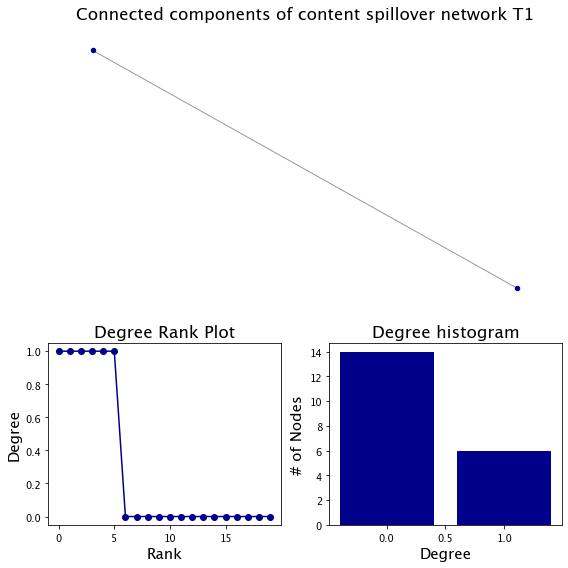

In [1797]:
gt1l = GT1L

degree_sequence = sorted([d for n, d in gt1l.degree()], reverse=True)
dmax = max(degree_sequence)

fig = plt.figure("Degree of a random graph", figsize=(8, 8))
# Create a gridspec for adding subplots of different sizes
axgrid = fig.add_gridspec(5, 4)

ax0 = fig.add_subplot(axgrid[0:3, :])
Gcc = gt1l.subgraph(sorted(nx.connected_components(GT1L), key=len, reverse=True)[0])
pos = nx.spring_layout(Gcc, seed=10396953)
nx.draw_networkx_nodes(Gcc, pos, ax=ax0, node_size=20, node_color = 'darkblue')
nx.draw_networkx_edges(Gcc, pos, ax=ax0, alpha=0.4)
ax0.set_title("Connected components of content spillover network T1", fontsize = 17)
ax0.set_axis_off()

ax1 = fig.add_subplot(axgrid[3:, :2])
ax1.plot(degree_sequence, "b-", marker="o", color = 'darkblue')
ax1.set_title("Degree Rank Plot", fontsize = 17)
ax1.set_ylabel("Degree", fontsize = 15)
ax1.set_xlabel("Rank", fontsize = 15)

ax2 = fig.add_subplot(axgrid[3:, 2:])
ax2.bar(*np.unique(degree_sequence, return_counts=True), color = 'darkblue')
ax2.set_title("Degree histogram", fontsize = 17)
ax2.set_xlabel("Degree", fontsize = 15)
ax2.set_ylabel("# of Nodes", fontsize = 15)

fig.tight_layout()
#plt.show()
plt.savefig('/Users/m.simonuva.nl/Dropbox/Apps/Overleaf/FYP/chapters/Images/degree_plots_GT1L.png')

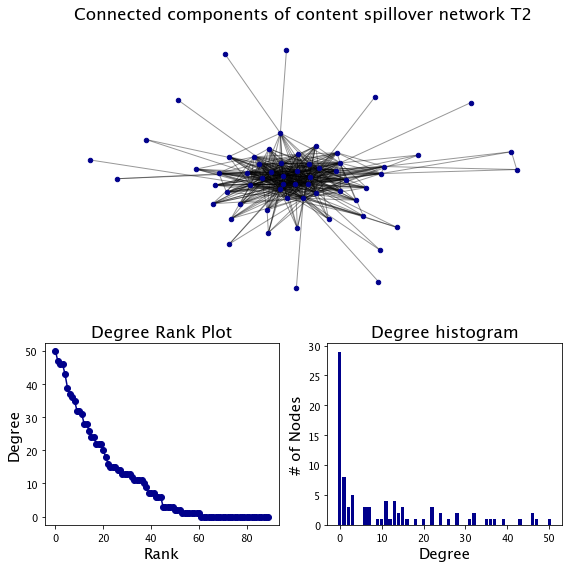

In [1798]:
gt2l = GT2L

degree_sequence = sorted([d for n, d in gt2l.degree()], reverse=True)
dmax = max(degree_sequence)

fig = plt.figure("Degree of a random graph", figsize=(8, 8))
# Create a gridspec for adding subplots of different sizes
axgrid = fig.add_gridspec(5, 4)

ax0 = fig.add_subplot(axgrid[0:3, :])
Gcc = gt2l.subgraph(sorted(nx.connected_components(GT2L), key=len, reverse=True)[0])
pos = nx.spring_layout(Gcc, seed=10396953)
nx.draw_networkx_nodes(Gcc, pos, ax=ax0, node_size=20, node_color = 'darkblue')
nx.draw_networkx_edges(Gcc, pos, ax=ax0, alpha=0.4)
ax0.set_title("Connected components of content spillover network T2", fontsize = 17)
ax0.set_axis_off()

ax1 = fig.add_subplot(axgrid[3:, :2])
ax1.plot(degree_sequence, "b-", marker="o", color = 'darkblue')
ax1.set_title("Degree Rank Plot", fontsize = 17)
ax1.set_ylabel("Degree", fontsize = 15)
ax1.set_xlabel("Rank", fontsize = 15)

ax2 = fig.add_subplot(axgrid[3:, 2:])
ax2.bar(*np.unique(degree_sequence, return_counts=True), color = 'darkblue')
ax2.set_title("Degree histogram",fontsize = 17 )
ax2.set_xlabel("Degree", fontsize = 15)
ax2.set_ylabel("# of Nodes", fontsize = 15)

fig.tight_layout()
#plt.show()
plt.savefig('/Users/m.simonuva.nl/Dropbox/Apps/Overleaf/FYP/chapters/Images/degree_plots_GT2L.png')

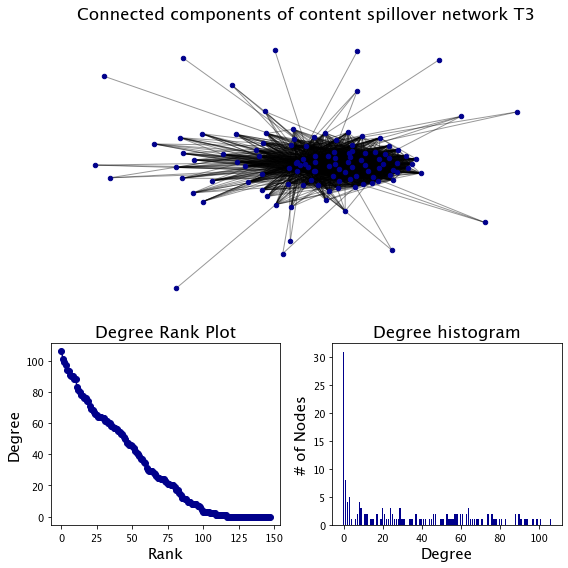

In [1799]:
gt3l = GT3L

degree_sequence = sorted([d for n, d in gt3l.degree()], reverse=True)
dmax = max(degree_sequence)

fig = plt.figure("Degree of a random graph", figsize=(8, 8))
# Create a gridspec for adding subplots of different sizes
axgrid = fig.add_gridspec(5, 4)

ax0 = fig.add_subplot(axgrid[0:3, :])
Gcc = gt3l.subgraph(sorted(nx.connected_components(GT3L), key=len, reverse=True)[0])
pos = nx.spring_layout(Gcc, seed=10396953)
nx.draw_networkx_nodes(Gcc, pos, ax=ax0, node_size=20, node_color = 'darkblue')
nx.draw_networkx_edges(Gcc, pos, ax=ax0, alpha=0.4)
ax0.set_title("Connected components of content spillover network T3", fontsize = 17)
ax0.set_axis_off()

ax1 = fig.add_subplot(axgrid[3:, :2])
ax1.plot(degree_sequence, "b-", marker="o", color = 'darkblue')
ax1.set_title("Degree Rank Plot", fontsize = 17)
ax1.set_ylabel("Degree", fontsize = 15)
ax1.set_xlabel("Rank", fontsize = 15)

ax2 = fig.add_subplot(axgrid[3:, 2:])
ax2.bar(*np.unique(degree_sequence, return_counts=True), color = 'darkblue')
ax2.set_title("Degree histogram", fontsize = 17)
ax2.set_xlabel("Degree", fontsize = 15)
ax2.set_ylabel("# of Nodes", fontsize = 15)

fig.tight_layout()
#plt.show()
plt.savefig('/Users/m.simonuva.nl/Dropbox/Apps/Overleaf/FYP/chapters/Images/degree_plots_GT3L.png')

#### Add node attributes from file

In [1128]:
#group_attr = test2[['source', 'type']].copy()
#group_attr = group_attr.drop_duplicates(subset=['source'])
#group_attr['theme'] = ""
#group_attr.to_csv('/Users/m.simonuva.nl/GitHub/Telegram-scraper/Telegram-scraper/group_themes.csv')
#len(group_attr['source'].unique())
#group_attr.to_csv('/Users/m.simonuva.nl/GitHub/Telegram-scraper/Telegram-scraper/node_attributes.csv')

In [1776]:
group_attr = pd.read_csv('/Users/m.simonuva.nl/GitHub/Telegram-scraper/Telegram-scraper/node_attributes.csv')
group_attr = group_attr.loc[:, ~group_attr.columns.str.contains('^Unnamed')]
#group_attr
node_attributes = group_attr.to_dict('records')
#node_attributes

In [1777]:
# We create a dictionary with node names as key and another dict as value. 
# The second-order dict contains a mapping of a feature name (such as "size")
# to the corresponding value for the specific node
# We then merge these features into the graphs

node2attributemap = {n['source']: {'type': n['type'], 'size':n['size']} for n in node_attributes}
# print(node2attributemap)
nx.set_node_attributes(GT1L, node2attributemap)
nx.set_node_attributes(GT2L, node2attributemap)
nx.set_node_attributes(GT3L, node2attributemap)
#GT3L.nodes(data=True)

In [1778]:
edge_weights1 = nx.get_edge_attributes(GT1L,'no_common_links')
edge_weights2 = nx.get_edge_attributes(GT2L,'no_common_links')
edge_weights3 = nx.get_edge_attributes(GT3L,'no_common_links')

In [1779]:
#Remove edges below certain thresholf
GT1L.remove_edges_from((e for e, w in edge_weights1.items() if w < 2)) #remove edges with less than 2 unique links in common
GT2L.remove_edges_from((e for e, w in edge_weights2.items() if w < 2)) #remove edges with less than 2 unique links in common 
GT3L.remove_edges_from((e for e, w in edge_weights3.items() if w < 2)) #remove edges with less than 2 unique links in common 

In [1133]:
print("Density in Overlapping link TELEGRAM network T1: ", nx.density(GT1L))
print("Transitivity in Overlapping link TELEGRAM network T1: ", nx.transitivity(GT1L))
print("\nDensity in Overlapping link TELEGRAM network T2: ", nx.density(GT2L))
print("Transitivity in Overlapping link TELEGRAM network T2: ", nx.transitivity(GT2L))
print("\nDensity in Overlapping link TELEGRAM network T3: ", nx.density(GT3L))
print("Transitivity in Overlapping link TELEGRAM network T3: ", nx.transitivity(GT3L))

Density in Overlapping link TELEGRAM network T1:  0.04736842105263158
Transitivity in Overlapping link TELEGRAM network T1:  0

Density in Overlapping link TELEGRAM network T2:  0.26042446941323344
Transitivity in Overlapping link TELEGRAM network T2:  0.6598860862489829

Density in Overlapping link TELEGRAM network T3:  0.3670711527854385
Transitivity in Overlapping link TELEGRAM network T3:  0.7243352099932139


In [1780]:
#Remove edges below certain thresholf
GT1L.remove_edges_from((e for e, w in edge_weights1.items() if w < 5)) #remove edges with less than 2 unique links in common
GT2L.remove_edges_from((e for e, w in edge_weights2.items() if w < 5)) #remove edges with less than 2 unique links in common 
GT3L.remove_edges_from((e for e, w in edge_weights3.items() if w < 5)) #remove edges with less than 2 unique links in common 

In [1674]:
print("Density in Overlapping link TELEGRAM network T1: ", nx.density(GT1L))
print("Transitivity in Overlapping link TELEGRAM network T1: ", nx.transitivity(GT1L))
print("\nDensity in Overlapping link TELEGRAM network T2: ", nx.density(GT2L))
print("Transitivity in Overlapping link TELEGRAM network T2: ", nx.transitivity(GT2L))
print("\nDensity in Overlapping link TELEGRAM network T3: ", nx.density(GT3L))
print("Transitivity in Overlapping link TELEGRAM network T3: ", nx.transitivity(GT3L))

Density in Overlapping link TELEGRAM network T1:  0.015789473684210527
Transitivity in Overlapping link TELEGRAM network T1:  0

Density in Overlapping link TELEGRAM network T2:  0.12384519350811486
Transitivity in Overlapping link TELEGRAM network T2:  0.5984842856081433

Density in Overlapping link TELEGRAM network T3:  0.21253906968192682
Transitivity in Overlapping link TELEGRAM network T3:  0.6915977084659453


In [1134]:
print("Closeness centrality of the Overlapping link Telegram network T1: \n", nx.closeness_centrality(GT1L))
print("Eigenvector centrality of the Overlapping link Telegram network T1): \n", nx.eigenvector_centrality(GT1L))
print("Betweenness centrality of the Telegram network T1: \n", nx.betweenness_centrality(GT1L))

print("\nNumber of cliques T1: ", nx.graph_number_of_cliques(GT1L))
print("Cliques: ", list(nx.find_cliques(GT1L)))

Closeness centrality of the Overlapping link Telegram network T1: 
 {'vrijheid': 0.0, 'FvDgroup': 0.13573407202216065, 'GeleHesjesCentraal': 0.0, 'Kletschat_burgers_tegen_onrecht': 0.19838056680161942, 'NLPolitiek': 0.2344497607655502, 'Waarheid': 0.0, 'XRNLbroadcast': 0.0, 'beeldmateriaal': 0.13573407202216065, 'burgerstegenonrecht': 0.13573407202216065, 'cafeweltschmerz': 0.0, 'dagelijksestandaard': 0.15170278637770895, 'donmaartenofficial': 0.0, 'geenstijll': 0.19838056680161942, 'leefbewust': 0.07017543859649122, 'natuurlijf': 0.07017543859649122, 'natuurlijf_chat': 0.10526315789473684, 'qanon_GLF_AstharCommanders': 0.0, 'thepostonline': 0.13573407202216065, 'thierrybaudet': 0.0, 'verzetwestland': 0.0}
Eigenvector centrality of the Overlapping link Telegram network T1): 
 {'vrijheid': 5.2589159968705244e-20, 'FvDgroup': 0.2175810731400853, 'GeleHesjesCentraal': 5.2589159968705244e-20, 'Kletschat_burgers_tegen_onrecht': 0.46470513142732434, 'NLPolitiek': 0.5573454099102039, 'Waarhei

In [1135]:
print("Closeness centrality of the Overlapping link Telegram network T2: \n", nx.closeness_centrality(GT2L))
print("Eigenvector centrality of the Overlapping link Telegram network T2): \n", nx.eigenvector_centrality(GT2L))
print("Betweenness centrality of the Telegram network T2: \n", nx.betweenness_centrality(GT2L))

print("\nNumber of cliques T2: ", nx.graph_number_of_cliques(GT2L))
print("Cliques: ", list(nx.find_cliques(GT2L)))

Closeness centrality of the Overlapping link Telegram network T2: 
 {'zoektocht': 0.523378035520116, 'nederlandsverzet21': 0.5954025358210494, 'whereWeGo1WeGoAlll': 0.7054225696140694, 'samen1voornl': 0.7131744659834548, 'wwncommunity': 0.6690605814896328, 'klokkenchat': 0.6904135787712168, 'mondkapjesverzetgroep': 0.6622334326989222, 'wakkerenchat': 0.7635161929940516, 'QPatriotsEindhoven': 0.6240276577355228, 'wakkerAmsterdam': 0.729200858477465, 'WakkerWezen': 0.6065315551821905, 'neetegen15meter': 0.6690605814896328, 'Kletschat_burgers_tegen_onrecht': 0.6489887640449438, 'Nederland_in_het_verzet': 0.6425631327177661, 'SpoedWet': 0.5899897854954035, 'boereninopstand': 0.6300861786844114, 'geloofhoopliefde': 0.48796147672552165, 'klokkenluiders': 0.5276331414999543, 'onafhankelijkepers': 0.519191011235955, 'onderzoekenvancomplotten': 0.4916581545795029, 'sameninactie': 0.6180845371856607, 'viruswaanzin': 0.6065315551821905, 'wakkergroningen': 0.6760299625468165, 'Forumvoordemocratief

In [1136]:
print("Closeness centrality of the Overlapping link Telegram network T3: \n", nx.closeness_centrality(GT3L))
print("Eigenvector centrality of the Overlapping link Telegram network T3): \n", nx.eigenvector_centrality(GT1L))
print("Betweenness centrality of the Telegram network T3: \n", nx.betweenness_centrality(GT3L))

print("Number of cliques T3: ", nx.graph_number_of_cliques(GT3L))
print("Cliques: ", list(nx.find_cliques(GT3L)))

Closeness centrality of the Overlapping link Telegram network T3: 
 {'zorgmedewerkersverenigd': 0.4968103973106753, 'DeBataafseRepubliek': 0.8991568458369263, 'nederlandsverzet21': 0.8081029880306553, 'coronavaccinsbijwerkingen': 0.6977064049663582, 'klokkenchat': 0.8400017901897601, 'QPatriotsEindhoven': 0.7980017006802721, 'gewoonvrij': 0.7296015549076773, 'ikzorgenbenwakker': 0.6198071461594347, 'wakkerAmsterdam': 0.8400017901897601, 'wakkerenchat': 0.8132501408206595, 'bronvanonvoorwaardelijkeliefde': 0.7423271634235089, 'coronavaccinschatgroep': 0.7213574695414889, 'dvo_open_koffiecorner': 0.7296015549076773, 'fvdgeluid': 0.6384013605442178, 'neetegen15meter': 0.7555045686913819, 'onafhankelijkepers': 0.6720014321518082, 'oudersmetzorgen': 0.7555045686913819, 'samen1voornl': 0.8132501408206595, 'sameninactie': 0.769158265715925, 'vaccinatiewaarheid': 0.6901636330207759, 'virussenbestaanniet2': 0.6384013605442178, 'vrouwenvoorvrijheid': 0.6022654344756772, 'BewustmakendNEWSNOW': 0.

Cliques:  [['eindhovenrwina', 'eindhovenrwinachat'], ['avondklok'], ['fakkeltochtemmen2021'], ['NatuurlijkVrijOnderwijsGO'], ['rellen2', 'rellen1'], ['XRNLbroadcast'], ['Juiste'], ['gezelligspiritueel'], ['FuckAvondKlok'], ['demo_vervoer', 'vervoervoordemonstranten', 'WijZijnDeVrijheid', 'deparallellemaatschappij', 'verzetsblaadje'], ['RechtsVerbonden'], ['bewustzijncentrumapofyliet'], ['DeBataafseRepubliek', 'InfoAvondklok', 'wakkerAmsterdam', 'wrwynl', 'mondkapjesverzetgroep', 'FVDNL'], ['DeBataafseRepubliek', 'Liefdespioniers', 'bronvanonvoorwaardelijkeliefde'], ['DeBataafseRepubliek', 'ikknaagaandepotenvanRutteenKaag', 'wakkerAmsterdam', 'gewoonvrij', 'verzetsblaadje', 'bronvanonvoorwaardelijkeliefde', 'vervoervoordemonstrantenchat', 'viruswaanzinbelgie'], ['DeBataafseRepubliek', 'ikknaagaandepotenvanRutteenKaag', 'wakkerAmsterdam', 'gewoonvrij', 'verzetsblaadje', 'bronvanonvoorwaardelijkeliefde', 'vervoervoordemonstrantenchat', 'boereninopstand'], ['DeBataafseRepubliek', 'theposto

In [1137]:
GT3L["QPatriotsEindhoven"]["FVDNL"]

{'no_common_links': 119, 'percentage_common_links': 0.07899523373295629}

### Community Detection

In [1138]:
print('Overlapping link Telegram network T1')
print("\nLouvain")
cluster1 = community.best_partition(GT1L)
print(f"Length: {float(len(set(cluster1.values())))}")
print(f"Modularity: {community.modularity(cluster1, GT1L):.2f}")
#print(f"Membership: {cluster1}")


print("\nPropagating label: ")
cluster2 = nxcom.asyn_lpa_communities(GT1L)
c2 = sorted(cluster2, key=len, reverse=True)
print("Length: ", len(c2))
print(f"Modularity: {nxcom.modularity(GT1L, c2):.2f}")
#print("Membership: ", c2)


print('\nOverlapping link Telegram network T2')
print("\nLouvain")
cluster3 = community.best_partition(GT2L)
print(f"Length: {float(len(set(cluster3.values())))}")
print(f"Modularity: {community.modularity(cluster3, GT2L):.2f}")
#print(f"Membership: {cluster1}")


print("\nPropagating label: ")
cluster4 = nxcom.asyn_lpa_communities(GT2L)
c4 = sorted(cluster4, key=len, reverse=True)
print("Length: ", len(c4))
print(f"Modularity: {nxcom.modularity(GT2L, c4):.2f}")
#print("Membership: ", c4)

print('\nOverlapping link Telegram network T3')
print("\nLouvain")
cluster5 = community.best_partition(GT3L)
print(f"Length: {float(len(set(cluster5.values())))}")
print(f"Modularity: {community.modularity(cluster5, GT3L):.2f}")
#print(f"Membership: {cluster1}")


print("\nPropagating label: ")
cluster6 = nxcom.asyn_lpa_communities(GT3L)
c6 = sorted(cluster6, key=len, reverse=True)
print("Length: ", len(c6))
print(f"Modularity: {nxcom.modularity(GT3L, c6):.2f}")
#print("Membership: ", c6)


Overlapping link Telegram network T1

Louvain
Length: 13.0
Modularity: 0.52

Propagating label: 
Length:  12
Modularity: 0.51

Overlapping link Telegram network T2

Louvain
Length: 18.0
Modularity: 0.08

Propagating label: 
Length:  14
Modularity: 0.00

Overlapping link Telegram network T3

Louvain
Length: 15.0
Modularity: 0.05

Propagating label: 
Length:  11
Modularity: 0.00


#### Add partition to node properties before saving

for node in partition:
    G.nodes[node]["cluster"] = partition[node]
#save file
nx.write_gml(G, "path_to_save_file")
#load file
saved_graph = nx.read_gml("path_to_save_file")




In [1139]:
size_map1 = nx.get_node_attributes(GT1L, "size")
size1 = list(size_map1.values())
size_map2 = nx.get_node_attributes(GT2L, "size")
size2 = list(size_map2.values())
size_map3 = nx.get_node_attributes(GT3L, "size")
size3 = list(size_map3.values())

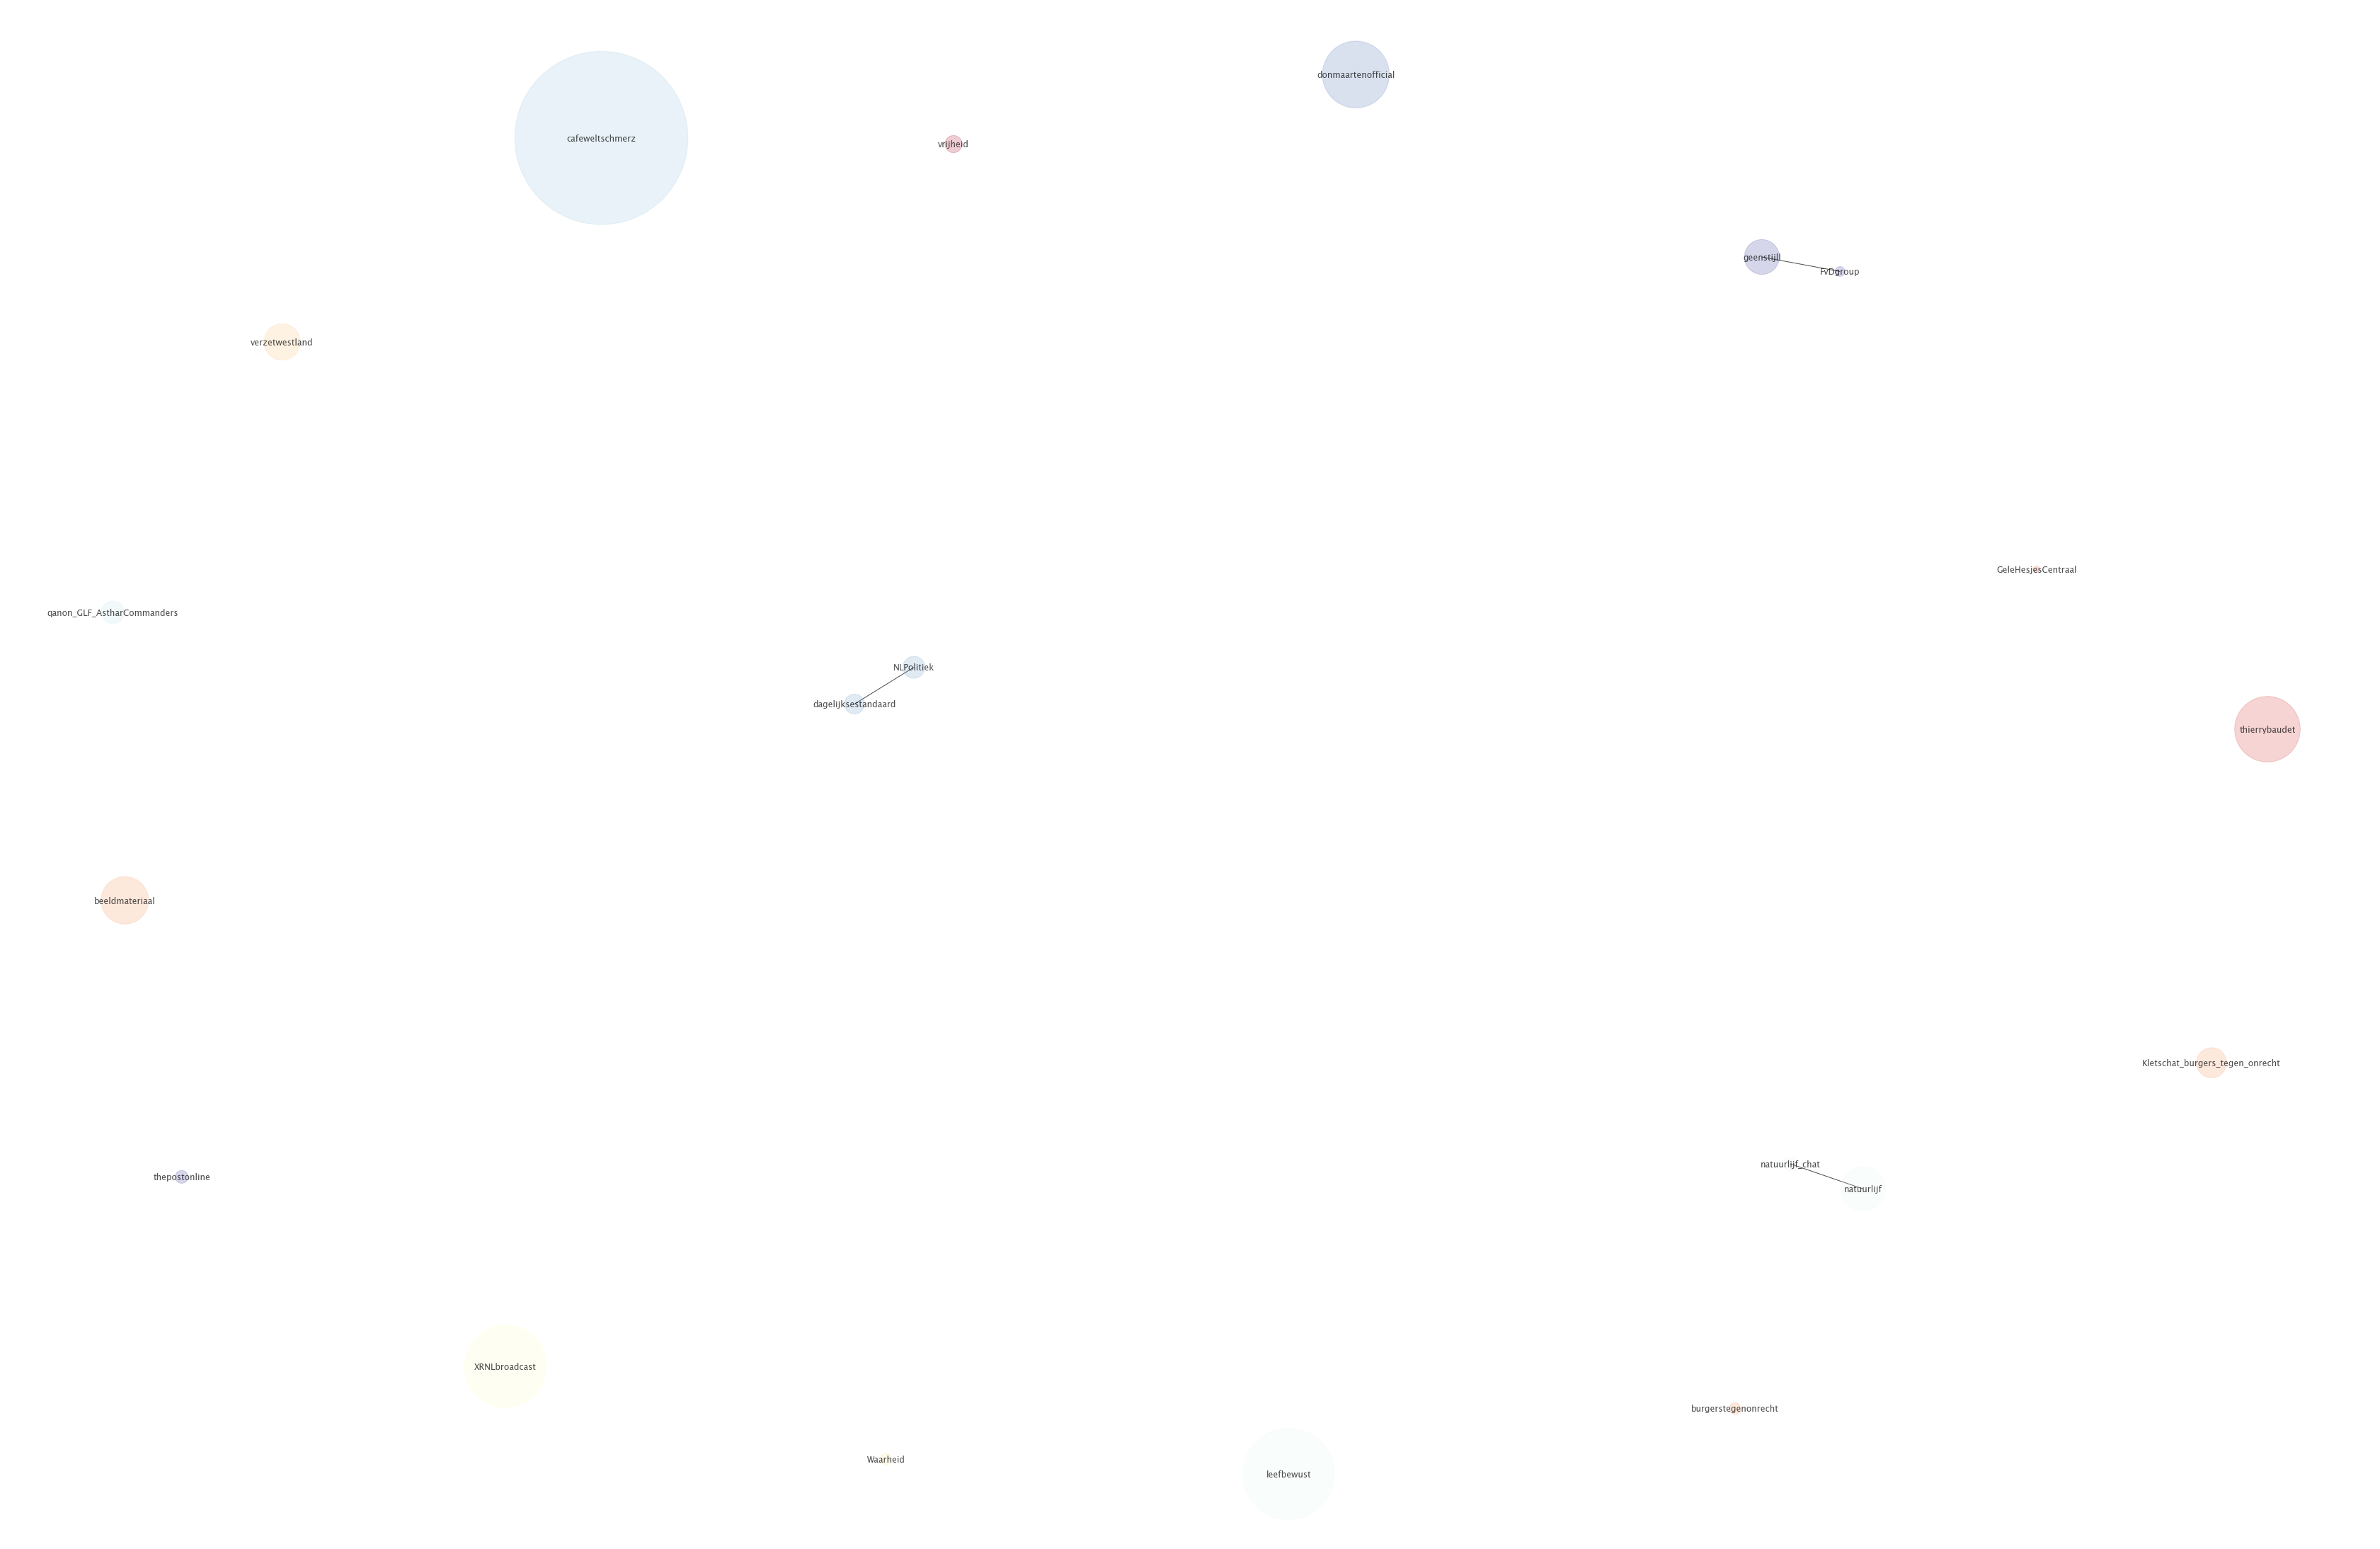

In [1675]:
#Plot with Louvain algortihm T1
pos = nx.spring_layout(GT1L)
plt.figure(figsize=(60,40))
plt.axis('off')
nx.draw_networkx_labels(GT1L,pos,font_size=12, font_family = "sans-serif", font_color = "k", alpha = 0.7)
nx.draw_networkx_nodes(GT1L, pos, cmap=plt.cm.RdYlBu, node_color=list(cluster1.values()), node_size = [x * 10 for x in size1], alpha = 0.2)
nx.draw_networkx_edges(GT1L, pos, alpha=0.7, edge_color = "k")
plt.show(GT1L)

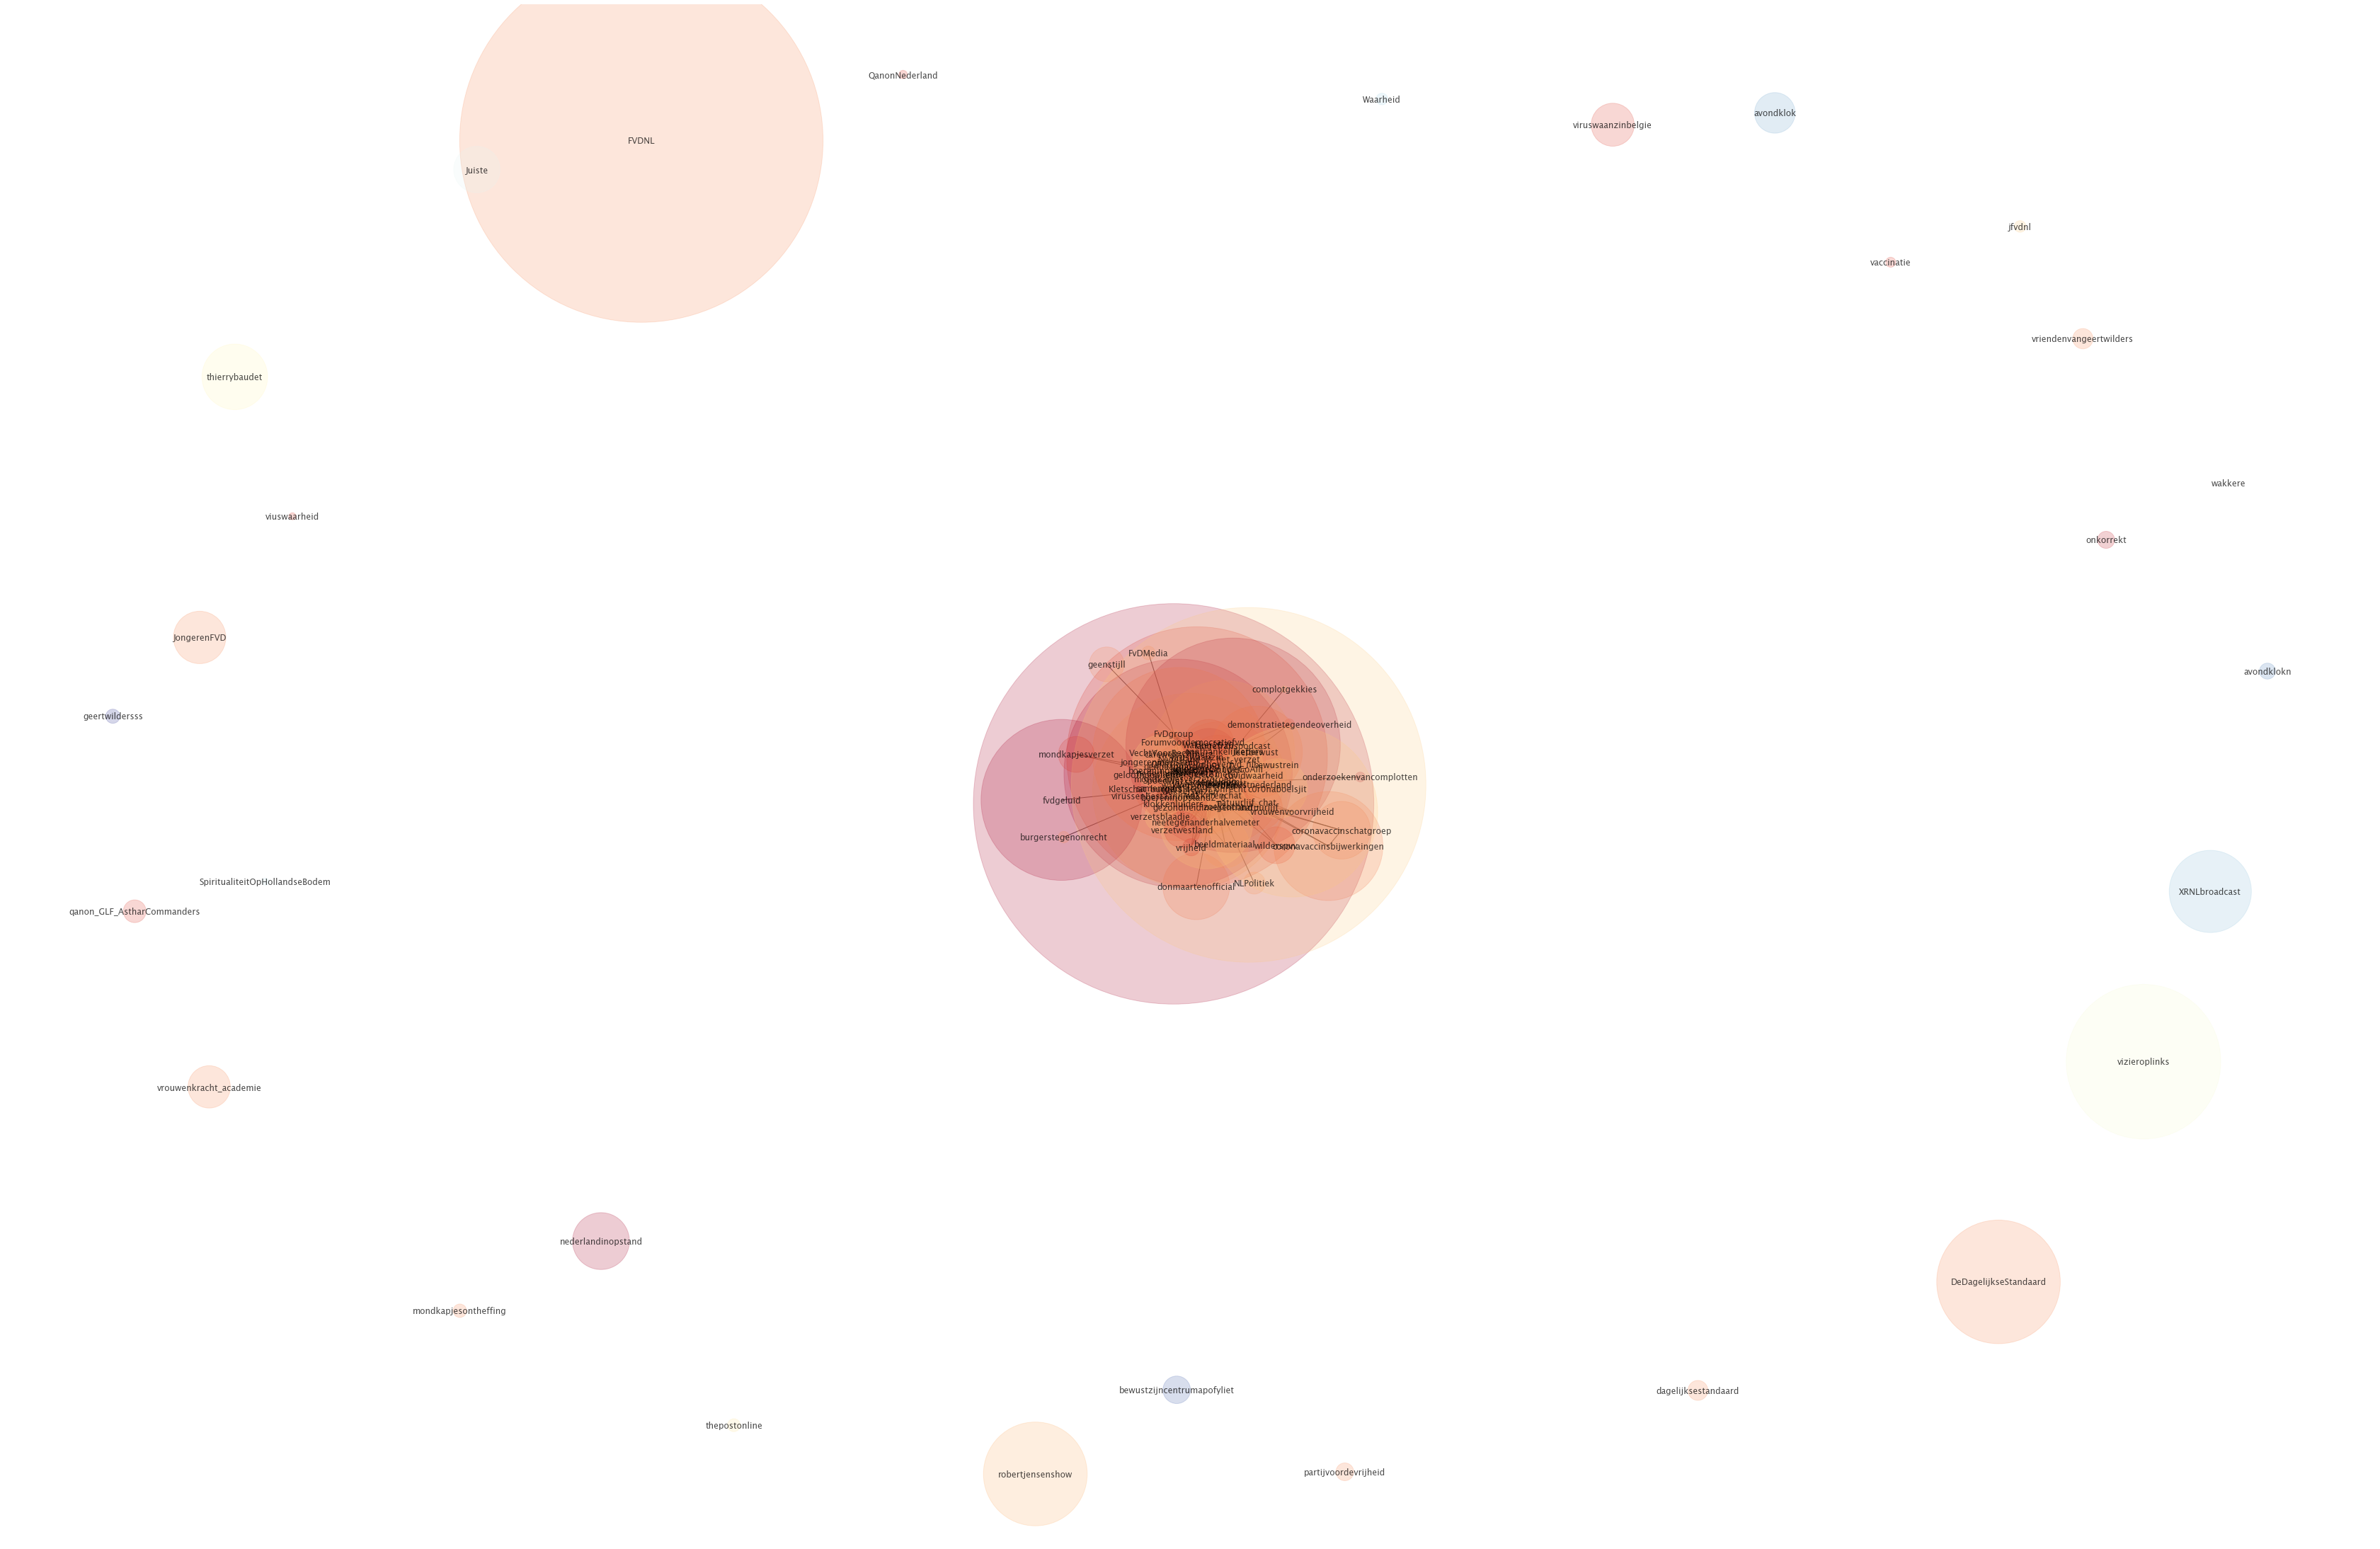

In [1676]:
#Plot with Louvain algortihm T2
pos = nx.spring_layout(GT2L)
plt.figure(figsize=(60,40))
plt.axis('off')
nx.draw_networkx_labels(GT2L,pos,font_size=12, font_family = "sans-serif", font_color = "k", alpha = 0.7)
nx.draw_networkx_nodes(GT2L, pos, cmap=plt.cm.RdYlBu, node_color=list(cluster3.values()), node_size = [x * 10 for x in size2], alpha = 0.2)
nx.draw_networkx_edges(GT2L, pos, alpha=0.7, edge_color = "k")
plt.show(GT2L)

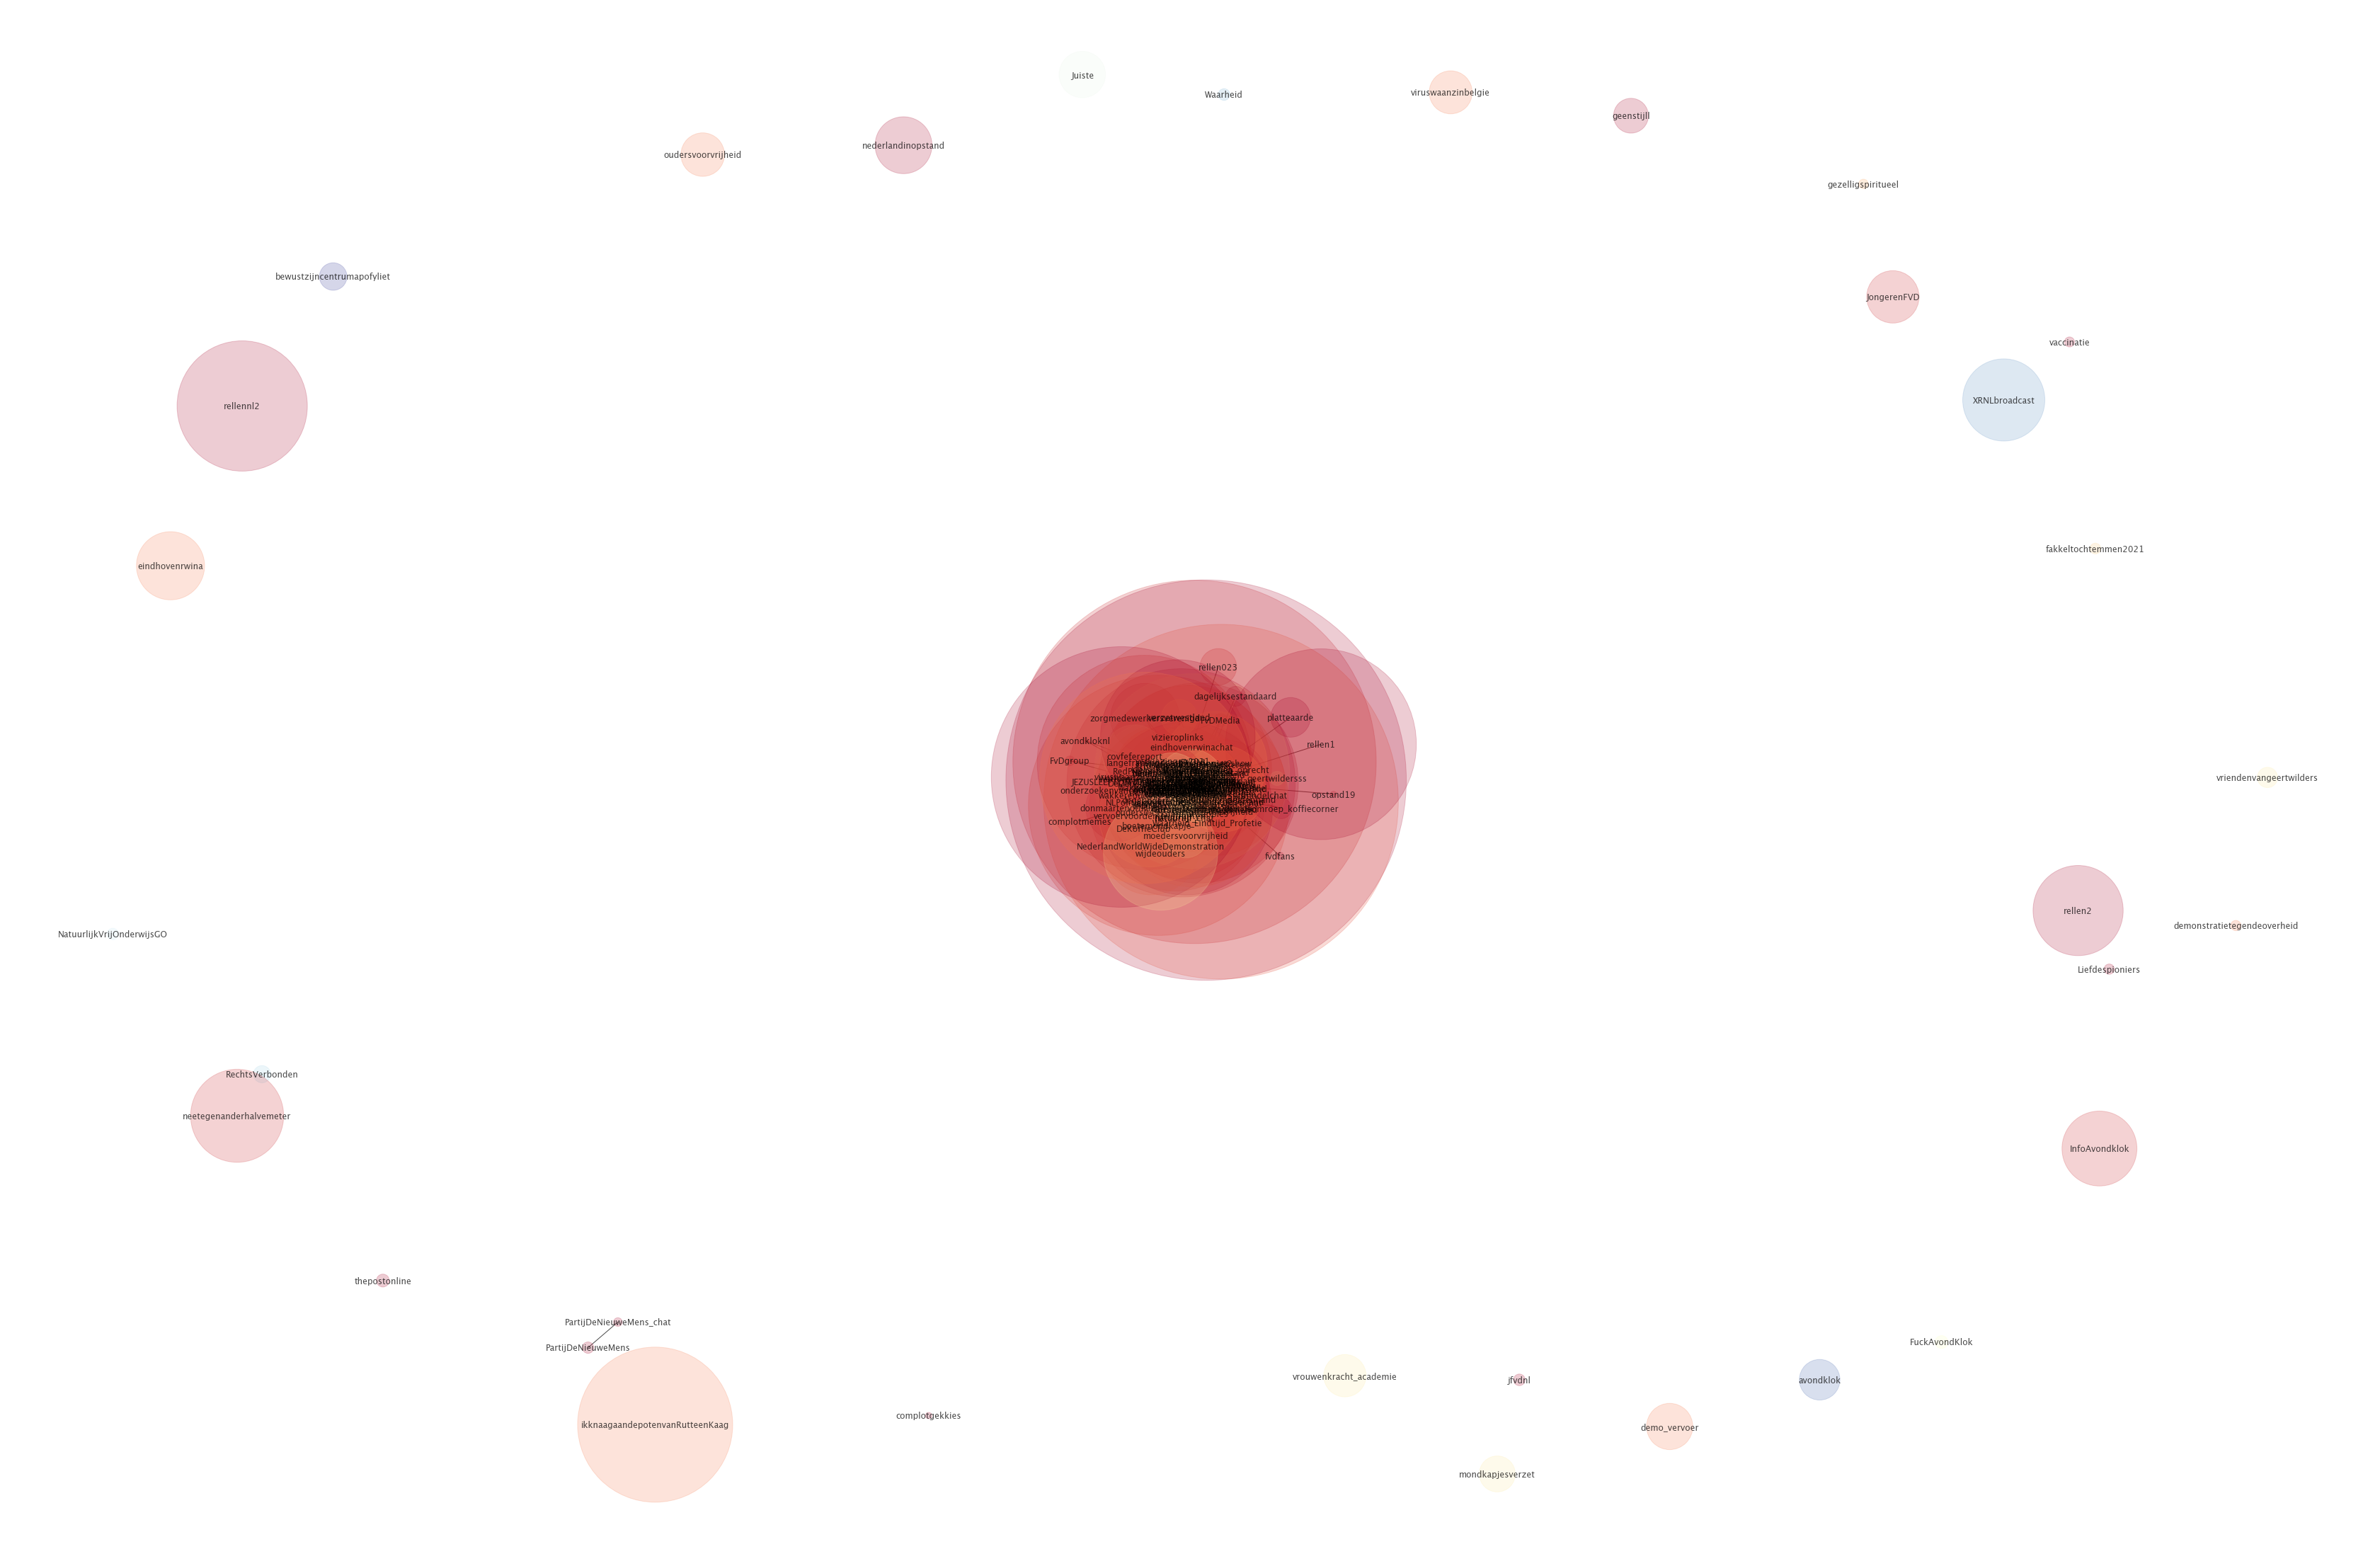

In [1677]:
#Plot with Louvain algortihm T3
pos = nx.spring_layout(GT3L)
plt.figure(figsize=(60,40))
plt.axis('off')
nx.draw_networkx_labels(GT3L,pos,font_size=12, font_family = "sans-serif", font_color = "k", alpha = 0.7)
nx.draw_networkx_nodes(GT3L, pos, cmap=plt.cm.RdYlBu, node_color=list(cluster5.values()), node_size = [x * 10 for x in size3], alpha = 0.2)
nx.draw_networkx_edges(GT3L, pos, alpha=0.7, edge_color = "k")
plt.show(GT3L)

### With Igraph

In [1708]:
g1l = ig.Graph.from_networkx(GT1L)
g2l = ig.Graph.from_networkx(GT2L)
g3l = ig.Graph.from_networkx(GT3L)
g1l.vs["id"] = g1l.vs["_nx_name"]
g2l.vs["id"] = g2l.vs["_nx_name"]
g3l.vs["id"] = g3l.vs["_nx_name"]
del(g1l.vs['_nx_name'])
del(g2l.vs['_nx_name'])
del(g3l.vs['_nx_name'])
g1l.es["weight"] = g1l.es["percentage_common_links"]
g2l.es["weight"] = g2l.es["percentage_common_links"]
g3l.es['weight'] = g3l.es["percentage_common_links"]

In [1712]:
#biggest connected components per time slice in link overlap network
print('Overlapping link Telegram network T1:')
print(f"Number of chats/channels in biggest connected compenent within link overlap network at T1: {len(g1l.clusters().giant().vs['id'])}")
print(f"List of chats/channels in biggest connected compenent within link overlap network at T1: \n{g1l.clusters().giant().vs['id']}")

print('\nOverlapping link Telegram network T2:')
print(f"Number of chats/channels in biggest connected compenent within link overlap network at T2: {len(g2l.clusters().giant().vs['id'])}")
print(f"List of chats/channels in biggest connected compenent within link overlap network at T2: \n{g2l.clusters().giant().vs['id']}")

print('\nOverlapping link Telegram network T3:')
print(f"Number of chats/channels in biggest connected compenent within link overlap network at T3: {len(g3l.clusters().giant().vs['id'])}")
print(f"List of chats/channels in biggest connected compenent within link overlap network at T3: \n{g3l.clusters().giant().vs['id']}")


Overlapping link Telegram network T1:
Number of chats/channels in biggest connected compenent within link overlap network at T1: 2
List of chats/channels in biggest connected compenent within link overlap network at T1: 
['FvDgroup', 'geenstijll']

Overlapping link Telegram network T2:
Number of chats/channels in biggest connected compenent within link overlap network at T2: 61
List of chats/channels in biggest connected compenent within link overlap network at T2: 
['zoektocht', 'nederlandsverzet21', 'whereWeGo1WeGoAlll', 'samen1voornl', 'wwncommunity', 'klokkenchat', 'mondkapjesverzetgroep', 'wakkerenchat', 'QPatriotsEindhoven', 'wakkerAmsterdam', 'WakkerWezen', 'neetegen15meter', 'Kletschat_burgers_tegen_onrecht', 'Nederland_in_het_verzet', 'SpoedWet', 'boereninopstand', 'geloofhoopliefde', 'klokkenluiders', 'onafhankelijkepers', 'onderzoekenvancomplotten', 'sameninactie', 'viruswaanzin', 'wakkergroningen', 'Forumvoordemocratiefvd', 'boereninopstand2_0', 'denhaaginopstand', 'fvdgelu

In [1698]:
#print modularity, clusters and biggest communities in each graph

print('Overlapping link Telegram network T1')
print("Leiden")
leiden(g1l)
print('\nOverlapping link Telegram network T2')
print("Leiden")
leiden(g2l)
print('\nOverlapping link Telegram network T3')
print("Leiden")
leiden(g3l)

Overlapping link Telegram network T1
Leiden
modularity = 0.0
Clustering with 20 elements and 1 clusters
Top 5 biggest communities: [20]

Overlapping link Telegram network T2
Leiden
modularity = 0.0
Clustering with 90 elements and 1 clusters
Top 5 biggest communities: [90]

Overlapping link Telegram network T3
Leiden
modularity = 0.0
Clustering with 148 elements and 1 clusters
Top 5 biggest communities: [148]


In [1713]:
print('Overlapping link Telegram network T1')
print("Leiden")
leiden(g1l)
print('\nOverlapping link Telegram network T2')
print("Leiden")
leiden(g2l)
print('\nOverlapping link Telegram network T3')
print("Leiden")
leiden(g3l)

Overlapping link Telegram network T1
Leiden
modularity = 0.09726112431679512
Clustering with 20 elements and 17 clusters
Top 5 biggest communities: [2, 2, 2, 1, 1]

Overlapping link Telegram network T2
Leiden
modularity = 0.0
Clustering with 90 elements and 30 clusters
Top 5 biggest communities: [61, 1, 1, 1, 1]

Overlapping link Telegram network T3
Leiden
modularity = 0.00012228812147521622
Clustering with 148 elements and 33 clusters
Top 5 biggest communities: [115, 2, 1, 1, 1]


### Temporal community detection

#temporal community detection & partition improvement in a multiplex graph
membership, improvement = la.find_partition_temporal([g1l, g2l, g3l],la.CPMVertexPartition,interslice_weight=0.1,resolution_parameter=0)
improvement

### Input for temporal community dectection in network models using overlapping users as edges

In [1150]:
df_T1U = df_T1[df_T1['ids'].notna()] #55,302 rows
#df_T1U.to_csv('/Users/m.simonuva.nl/GitHub/Telegram-scraper/Telegram-scraper/T1_user_data.csv')
df_T2U = df_T2[df_T2['ids'].notna()] #484,416 rows 
#df_T2U.to_csv('/Users/m.simonuva.nl/GitHub/Telegram-scraper/Telegram-scraper/T2_user_data.csv')
df_T3U = df_T3[df_T3['ids'].notna()] #1,481,377 rows
#df_T3U.to_csv('/Users/m.simonuva.nl/GitHub/Telegram-scraper/Telegram-scraper/T3_user_data.csv')

In [1151]:
#transform entries of column 'ids' to str
df_T1U['ids'] = df_T1U['ids'].astype(str)
df_T2U['ids'] = df_T2U['ids'].astype(str)
df_T3U['ids'] = df_T3U['ids'].astype(str)

<ipython-input-1151-5becabf63b34>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_T1U['ids'] = df_T1U['ids'].astype(str)
<ipython-input-1151-5becabf63b34>:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_T2U['ids'] = df_T2U['ids'].astype(str)
<ipython-input-1151-5becabf63b34>:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/

In [1152]:
df1_T1U= pd.DataFrame(df_T1U.groupby([pd.Grouper(key = 'source'), 'type', 'message_id'])['ids'].agg(lambda x: "  ".join(x))) #urls per channel/chat
df1_T2U= pd.DataFrame(df_T2U.groupby([pd.Grouper(key = 'source'), 'type', 'message_id'])['ids'].agg(lambda x: "  ".join(x))) #urls per channel/chat
#df1_T2L['links'].iloc[108]
df1_T3U= pd.DataFrame(df_T3U.groupby([pd.Grouper(key = 'source'), 'type', 'message_id'])['ids'].agg(lambda x: "  ".join(x))) #urls per channel/chat
#df1_T3L['links'].iloc[108]

#### Create wide tables per time slice fill NANs with 0

In [1153]:
T1U_wide = df1_T1U.reset_index().pivot("message_id", "source", "ids")
T1U_wide.fillna(0)
T2U_wide = df1_T2U.reset_index().pivot("message_id", "source", "ids")
T2U_wide.fillna(0)
T3U_wide = df1_T3U.reset_index().pivot("message_id", "source", "ids")
T3U_wide.fillna(0)

source     BewustmakendNEWSNOW DeBataafseRepubliek DeDagelijkseStandaard  \
message_id                                                                 
1.0                          0                   0                     0   
2.0               1545657347.0                   0                     0   
3.0               1460222733.0                   0                     0   
4.0               1460222733.0                   0                     0   
5.0               1460222733.0                   0                     0   
...                        ...                 ...                   ...   
454677.0                     0        1568977595.0                     0   
454678.0                     0        1482823488.0                     0   
454679.0                     0         448938535.0                     0   
454680.0                     0        1571822623.0                     0   
454681.0                     0        1443785553.0                     0   

source      DeKoffieClub FVDNL Forumvoordemocratiefvd FuckAvondKlok FvDMedia  \
message_id                                                                     
1.0                    0     0                      0  1181236877.0        0   
2.0         1540182723.0     0                      0  1181236877.0        0   
3.0         1540182723.0     0                      0  1181236877.0        0   
4.0         1540182723.0     0                      0  1181236877.0        0   
5.0         1527660506.0     0                      0  1181236877.0        0   
...                  ...   ...                    ...           ...      ...   
454677.0               0     0                      0             0        0   
454678.0               0     0                      0             0        0   
454679.0               0     0                      0             0        0   
454680.0               0     0                      0             0        0   
454681.0               0     0                      0             0        0   

source     FvDgroup GeweldTegenWakkeren  ... wakkergroningen  \
message_id                               ...                   
1.0               0                   0  ...               0   
2.0               0        1161905026.0  ...               0   
3.0               0                   0  ...               0   
4.0               0        1491037682.0  ...               0   
5.0               0                   0  ...               0   
...             ...                 ...  ...             ...   
454677.0          0                   0  ...               0   
454678.0          0                   0  ...               0   
454679.0          0                   0  ...               0   
454680.0          0                   0  ...               0   
454681.0          0                   0  ...               0   

source     whereWeGo1WeGoAlll   wijdeouders wilderspvv worldwidenetherlands  \
message_id                                                                    
1.0                         0  1257866807.0          0                    0   
2.0                         0  1257866807.0          0         1039056289.0   
3.0                         0  1257866807.0          0         1372762085.0   
4.0                         0  1257866807.0          0          845081482.0   
5.0                         0  1257866807.0          0          902942779.0   
...                       ...           ...        ...                  ...   
454677.0                    0             0          0                    0   
454678.0                    0             0          0                    0   
454679.0                    0             0          0                    0   
454680.0                    0             0          0                    0   
454681.0                    0             0          0                    0   

source            wrwynl wwncommunity zoektocht zondermondkapje  \
message_id                                

#### See explanation at overlapping link network input

In [1154]:
T1U_out = pd.DataFrame()

for col in T1U_wide.columns:
    # making a list of all column which has to be compared with col 
    other_col = [x for x in T1U_wide.columns if x!=col]
   #print(other_col)
    for oCol in other_col:
        #print(oCol)
        #using a set to find a intersection between 2 list and count them
        count = len(set(T1U_wide[col].values.tolist()).intersection(T1U_wide[oCol].values.tolist()))#these are unique links 
        normalized = count/len(T1U_wide[col].values)*100
        #storing all count with their respective column in separate df
        T1U_out = T1U_out.append([(col,oCol,count,normalized)],sort=True,ignore_index=True)


T1U_out.columns = ['group','compared_to','no_common_users', 'percentage_common_users']

T1U_out.sort_values(by=['group','no_common_users'],ascending=[False,False],inplace=True)
T1U_out

group                      compared_to  no_common_users  \
441  vrijheid                         FvDgroup                1   
442  vrijheid               GeleHesjesCentraal                1   
443  vrijheid                      JongerenFVD                1   
444  vrijheid  Kletschat_burgers_tegen_onrecht                1   
445  vrijheid                       NLPolitiek                1   
..        ...                              ...              ...   
16   FvDgroup       qanon_GLF_AstharCommanders                1   
17   FvDgroup                    thepostonline                1   
18   FvDgroup                    thierrybaudet                1   
19   FvDgroup                   verzetwestland                1   
20   FvDgroup                         vrijheid                1   

     percentage_common_users  
441                 0.004023  
442                 0.004023  
443                 0.004023  
444                 0.004023  
445                 0.004023  
..                       ...  
16                  0.004023  
17                  0.004023  
18                  0.004023  
19                  0.004023  
20                  0.004023  

[462 rows x 4 columns]

In [1155]:
T2U_out = pd.DataFrame()

for col in T2U_wide.columns:
    # making a list of all column which has to be compared with col 
    other_col = [x for x in T2U_wide.columns if x!=col]
   #print(other_col)
    for oCol in other_col:
        #print(oCol)
        #using a set to find a intersection between 2 list and count them
        count = len(set(T2U_wide[col].values.tolist()).intersection(T2U_wide[oCol].values.tolist()))#these are unique links 
        normalized = count/len(T2U_wide[col].values)*100
        #storing all count with their respective column in separate df
        T2U_out = T2U_out.append([(col,oCol,count,normalized)],sort=True,ignore_index=True)


T2U_out.columns = ['group','compared_to','no_common_users', 'percentage_common_users']

T2U_out.sort_values(by=['group','no_common_users'],ascending=[False,False],inplace=True)
T2U_out

group         compared_to  no_common_users  \
10884              zoektocht  nederlandsverzet21                8   
10851              zoektocht     cafeweltschmerz                4   
10915              zoektocht        wakkerenchat                4   
10919              zoektocht        wwncommunity                4   
10893              zoektocht        samen1voornl                3   
...                      ...                 ...              ...   
99     DeDagelijkseStandaard     wakkergroningen                1   
100    DeDagelijkseStandaard  whereWeGo1WeGoAlll                1   
101    DeDagelijkseStandaard          wilderspvv                1   
102    DeDagelijkseStandaard        wwncommunity                1   
103    DeDagelijkseStandaard           zoektocht                1   

       percentage_common_users  
10884                  0.00544  
10851                  0.00272  
10915                  0.00272  
10919                  0.00272  
10893                  0.00204  
...                        ...  
99                     0.00068  
100                    0.00068  
101                    0.00068  
102                    0.00068  
103                    0.00068  

[10920 rows x 4 columns]

In [1156]:
T3U_out = pd.DataFrame()

for col in T3U_wide.columns:
    # making a list of all column which has to be compared with col 
    other_col = [x for x in T3U_wide.columns if x!=col]
   #print(other_col)
    for oCol in other_col:
        #print(oCol)
        #using a set to find a intersection between 2 list and count them
        count = len(set(T3U_wide[col].values.tolist()).intersection(T3U_wide[oCol].values.tolist()))#these are unique links 
        normalized = count/len(T3U_wide[col].values)*100
        #storing all count with their respective column in separate df
        T3U_out = T3U_out.append([(col,oCol,count,normalized)],sort=True,ignore_index=True)


T3U_out.columns = ['group','compared_to','no_common_users', 'percentage_common_users']

T3U_out.sort_values(by=['group','no_common_users'],ascending=[False,False],inplace=True)
T3U_out

group              compared_to  no_common_users  \
26569  zorgmedewerkersverenigd      BewustmakendNEWSNOW                1   
26570  zorgmedewerkersverenigd      DeBataafseRepubliek                1   
26571  zorgmedewerkersverenigd    DeDagelijkseStandaard                1   
26572  zorgmedewerkersverenigd             DeKoffieClub                1   
26573  zorgmedewerkersverenigd                    FVDNL                1   
...                        ...                      ...              ...   
156        BewustmakendNEWSNOW               wilderspvv                1   
158        BewustmakendNEWSNOW                   wrwynl                1   
160        BewustmakendNEWSNOW                zoektocht                1   
161        BewustmakendNEWSNOW          zondermondkapje                1   
162        BewustmakendNEWSNOW  zorgmedewerkersverenigd                1   

       percentage_common_users  
26569                 0.000224  
26570                 0.000224  
26571                 0.000224  
26572                 0.000224  
26573                 0.000224  
...                        ...  
156                   0.000224  
158                   0.000224  
160                   0.000224  
161                   0.000224  
162                   0.000224  

[26732 rows x 4 columns]

In [1157]:
res_T1U = T1U_out[~T1U_out[['group', 'compared_to']].apply(frozenset, axis=1).duplicated()] #remove duplicates
res_T2U = T2U_out[~T2U_out[['group', 'compared_to']].apply(frozenset, axis=1).duplicated()] #remove duplicates
res_T3U = T3U_out[~T3U_out[['group', 'compared_to']].apply(frozenset, axis=1).duplicated()] #remove duplicates

#### Max number of overlapping users per time slice

In [1158]:
#T1
res_T1U['no_common_users'].max() 
res_T1U[res_T1U['no_common_users'] == 23]

group                      compared_to  no_common_users  \
150  beeldmateriaal  Kletschat_burgers_tegen_onrecht               23   

     percentage_common_users  
150                  0.09254

In [1159]:
#T2
res_T2U['no_common_users'].max()
res_T2U[res_T2U['no_common_users'] == 324]

group      compared_to  no_common_users  \
7107  nederlandsverzet21  cafeweltschmerz              324   

      percentage_common_users  
7107                  0.22032

In [1160]:
#T3
res_T3U['no_common_users'].max()
res_T3U[res_T3U['no_common_users'] == 2343]

group          compared_to  no_common_users  \
14834  klokkenchat  DeBataafseRepubliek             2343   

       percentage_common_users  
14834                 0.525835

In [1161]:
#test
res_T1U.sort_values(by='percentage_common_users', ascending=False)

group                      compared_to  \
150              beeldmateriaal  Kletschat_burgers_tegen_onrecht   
147              beeldmateriaal                         FvDgroup   
151              beeldmateriaal                       NLPolitiek   
87                   NLPolitiek  Kletschat_burgers_tegen_onrecht   
84                   NLPolitiek                         FvDgroup   
..                          ...                              ...   
359  qanon_GLF_AstharCommanders                      JongerenFVD   
360  qanon_GLF_AstharCommanders  Kletschat_burgers_tegen_onrecht   
361  qanon_GLF_AstharCommanders                       NLPolitiek   
362  qanon_GLF_AstharCommanders                         Waarheid   
21           GeleHesjesCentraal                         FvDgroup   

     no_common_users  percentage_common_users  
150               23                 0.092540  
147                6                 0.024141  
151                5                 0.020117  
87                 4                 0.016094  
84                 4                 0.016094  
..               ...                      ...  
359                1                 0.004023  
360                1                 0.004023  
361                1                 0.004023  
362                1                 0.004023  
21                 1                 0.004023  

[231 rows x 4 columns]

In [1162]:
res_T1U.sort_values(by='no_common_users', ascending=False)

group                      compared_to  \
150              beeldmateriaal  Kletschat_burgers_tegen_onrecht   
147              beeldmateriaal                         FvDgroup   
151              beeldmateriaal                       NLPolitiek   
87                   NLPolitiek  Kletschat_burgers_tegen_onrecht   
84                   NLPolitiek                         FvDgroup   
..                          ...                              ...   
359  qanon_GLF_AstharCommanders                      JongerenFVD   
360  qanon_GLF_AstharCommanders  Kletschat_burgers_tegen_onrecht   
361  qanon_GLF_AstharCommanders                       NLPolitiek   
362  qanon_GLF_AstharCommanders                         Waarheid   
21           GeleHesjesCentraal                         FvDgroup   

     no_common_users  percentage_common_users  
150               23                 0.092540  
147                6                 0.024141  
151                5                 0.020117  
87                 4                 0.016094  
84                 4                 0.016094  
..               ...                      ...  
359                1                 0.004023  
360                1                 0.004023  
361                1                 0.004023  
362                1                 0.004023  
21                 1                 0.004023  

[231 rows x 4 columns]

### Create user network models per time slice 

In [1714]:
GT1U = nx.from_pandas_edgelist(res_T1U, 'group', 'compared_to', ['no_common_users', 'percentage_common_users'])
GT2U = nx.from_pandas_edgelist(res_T2U, 'group', 'compared_to', ['no_common_users', 'percentage_common_users'])
GT3U = nx.from_pandas_edgelist(res_T3U, 'group', 'compared_to', ['no_common_users', 'percentage_common_users'])

#### Graph properties

In [1164]:
print("User Overlap Graph properties T1:")
print("Nodes:", GT1U.number_of_nodes(), "Edges: ", GT1U.
number_of_edges())
print("\nUser Overlap Graph properties T2:")
print("Nodes:", GT2U.number_of_nodes(), "Edges: ", GT2U.
number_of_edges())
print("\nUser Overlap Graph properties T3:")
print("Nodes:", GT3U.number_of_nodes(), "Edges: ", GT3U.
number_of_edges())

User Overlap Graph properties T1:
Nodes: 22 Edges:  231

User Overlap Graph properties T2:
Nodes: 105 Edges:  5460

User Overlap Graph properties T3:
Nodes: 164 Edges:  13366


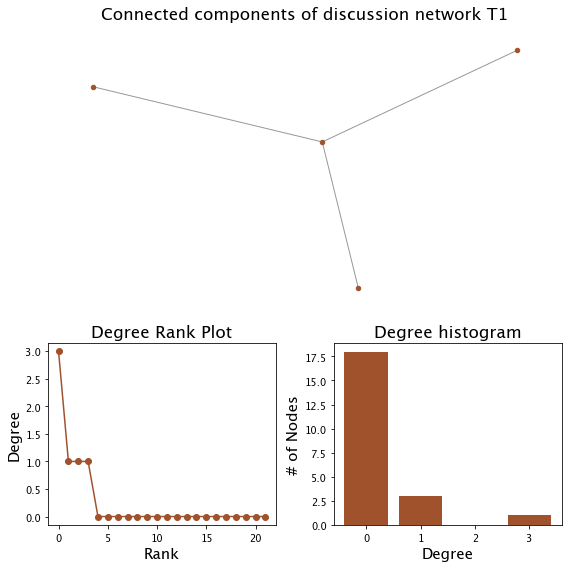

In [1800]:
gt1u = GT1U

degree_sequence = sorted([d for n, d in gt1u.degree()], reverse=True)
dmax = max(degree_sequence)

fig = plt.figure("Degree of a random graph", figsize=(8, 8))
# Create a gridspec for adding subplots of different sizes
axgrid = fig.add_gridspec(5, 4)

ax0 = fig.add_subplot(axgrid[0:3, :])
Gcc = gt1u.subgraph(sorted(nx.connected_components(GT1U), key=len, reverse=True)[0])
pos = nx.spring_layout(Gcc, seed=10396953)
nx.draw_networkx_nodes(Gcc, pos, ax=ax0, node_size=20, node_color = 'sienna')
nx.draw_networkx_edges(Gcc, pos, ax=ax0, alpha=0.4)
ax0.set_title("Connected components of discussion network T1", fontsize = 17)
ax0.set_axis_off()

ax1 = fig.add_subplot(axgrid[3:, :2])
ax1.plot(degree_sequence, "b-", marker="o", color = 'sienna')
ax1.set_title("Degree Rank Plot", fontsize = 17)
ax1.set_ylabel("Degree", fontsize = 15)
ax1.set_xlabel("Rank",fontsize = 15 )

ax2 = fig.add_subplot(axgrid[3:, 2:])
ax2.bar(*np.unique(degree_sequence, return_counts=True), color = 'sienna')
ax2.set_title("Degree histogram", fontsize = 17)
ax2.set_xlabel("Degree", fontsize = 15)
ax2.set_ylabel("# of Nodes",fontsize = 15 )

fig.tight_layout()
#plt.show()
plt.savefig('/Users/m.simonuva.nl/Dropbox/Apps/Overleaf/FYP/chapters/Images/degree_plots_GT1U.png')

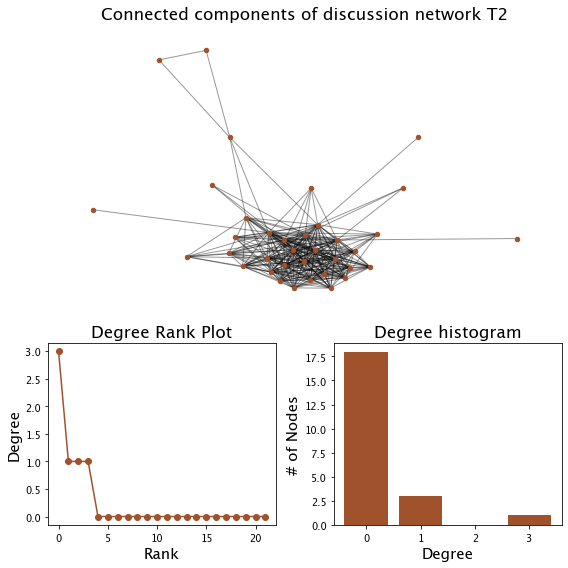

In [1802]:
gt2u = GT2U

degree_sequence = sorted([d for n, d in gt1u.degree()], reverse=True)
dmax = max(degree_sequence)

fig = plt.figure("Degree of a random graph", figsize=(8, 8))
# Create a gridspec for adding subplots of different sizes
axgrid = fig.add_gridspec(5, 4)

ax0 = fig.add_subplot(axgrid[0:3, :])
Gcc = gt2u.subgraph(sorted(nx.connected_components(GT2U), key=len, reverse=True)[0])
pos = nx.spring_layout(Gcc, seed=10396953)
nx.draw_networkx_nodes(Gcc, pos, ax=ax0, node_size=20, node_color = 'sienna')
nx.draw_networkx_edges(Gcc, pos, ax=ax0, alpha=0.4)
ax0.set_title("Connected components of discussion network T2", fontsize = 17)
ax0.set_axis_off()

ax1 = fig.add_subplot(axgrid[3:, :2])
ax1.plot(degree_sequence, "b-", marker="o", color = 'sienna')
ax1.set_title("Degree Rank Plot", fontsize = 17)
ax1.set_ylabel("Degree", fontsize = 15)
ax1.set_xlabel("Rank", fontsize = 15)

ax2 = fig.add_subplot(axgrid[3:, 2:])
ax2.bar(*np.unique(degree_sequence, return_counts=True), color = 'sienna')
ax2.set_title("Degree histogram",fontsize = 17 )
ax2.set_xlabel("Degree", fontsize = 15)
ax2.set_ylabel("# of Nodes", fontsize = 15)

fig.tight_layout()
#plt.show()
plt.savefig('/Users/m.simonuva.nl/Dropbox/Apps/Overleaf/FYP/chapters/Images/degree_plots_GT2U.png')

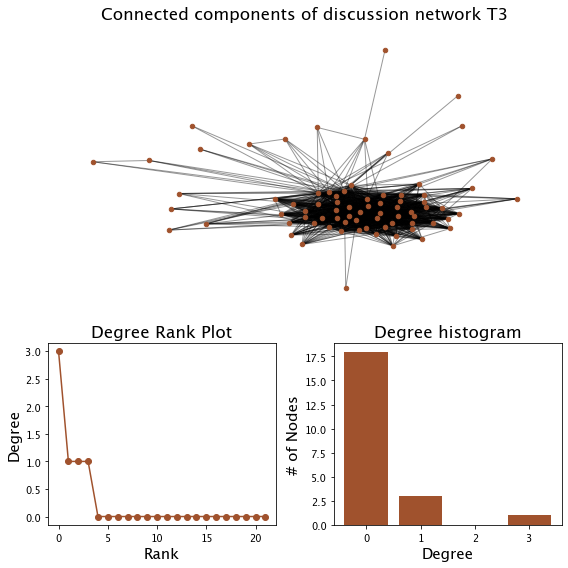

In [1803]:
gt3u = GT3U

degree_sequence = sorted([d for n, d in gt1u.degree()], reverse=True)
dmax = max(degree_sequence)

fig = plt.figure("Degree of a random graph", figsize=(8, 8))
# Create a gridspec for adding subplots of different sizes
axgrid = fig.add_gridspec(5, 4)

ax0 = fig.add_subplot(axgrid[0:3, :])
Gcc = gt3u.subgraph(sorted(nx.connected_components(GT3U), key=len, reverse=True)[0])
pos = nx.spring_layout(Gcc, seed=10396953)
nx.draw_networkx_nodes(Gcc, pos, ax=ax0, node_size=20, node_color = 'sienna')
nx.draw_networkx_edges(Gcc, pos, ax=ax0, alpha=0.4)
ax0.set_title("Connected components of discussion network T3", fontsize = 17)
ax0.set_axis_off()

ax1 = fig.add_subplot(axgrid[3:, :2])
ax1.plot(degree_sequence, "b-", marker="o", color = 'sienna')
ax1.set_title("Degree Rank Plot", fontsize = 17)
ax1.set_ylabel("Degree", fontsize = 15)
ax1.set_xlabel("Rank", fontsize = 15)

ax2 = fig.add_subplot(axgrid[3:, 2:])
ax2.bar(*np.unique(degree_sequence, return_counts=True), color = 'sienna')
ax2.set_title("Degree histogram", fontsize = 17)
ax2.set_xlabel("Degree", fontsize = 15)
ax2.set_ylabel("# of Nodes", fontsize = 15)

fig.tight_layout()
#plt.show()
plt.savefig('/Users/m.simonuva.nl/Dropbox/Apps/Overleaf/FYP/chapters/Images/degree_plots_GT3U.png')

In [1165]:
# We create a dictionary with node names as key and another dict as value. 
# The second-order dict contains a mapping of a feature name (such as "size")
# to the corresponding value for the specific node
# We then merge these features into the graphs

node2attributemap = {n['source']: {'type': n['type'], 'size':n['size']} for n in node_attributes}
# print(node2attributemap)
nx.set_node_attributes(GT1U, node2attributemap)
nx.set_node_attributes(GT2U, node2attributemap)
nx.set_node_attributes(GT3U, node2attributemap)
#GT3U.nodes(data=True)

In [1166]:
edge_weights4 = nx.get_edge_attributes(GT1U,'no_common_users')
edge_weights5 = nx.get_edge_attributes(GT2U,'no_common_users')
edge_weights6 = nx.get_edge_attributes(GT3U,'no_common_users')

In [1669]:
print("Density in Overlapping user TELEGRAM network T1: ", nx.density(GT1U))
print("Transitivity in Overlapping user TELEGRAM network T1: ", nx.transitivity(GT1U))
print("\nDensity in Overlapping user TELEGRAM network T2: ", nx.density(GT2U))
print("Transitivity in Overlapping user TELEGRAM network T2: ", nx.transitivity(GT2U))
print("\nDensity in Overlapping user TELEGRAM network T3: ", nx.density(GT3U))
print("Transitivity in Overlapping user TELEGRAM network T3: ", nx.transitivity(GT3U))

Density in Overlapping user TELEGRAM network T1:  0.030303030303030304
Transitivity in Overlapping user TELEGRAM network T1:  1.0

Density in Overlapping user TELEGRAM network T2:  0.09377289377289377
Transitivity in Overlapping user TELEGRAM network T2:  0.7608835513617842

Density in Overlapping user TELEGRAM network T3:  0.15726470148137064
Transitivity in Overlapping user TELEGRAM network T3:  0.7958383024221738


In [1742]:
#Remove edges below certain thresholf
GT1U.remove_edges_from((e for e, w in edge_weights4.items() if w < 5)) #remove edges with less than 5 unique users in common
GT2U.remove_edges_from((e for e, w in edge_weights5.items() if w < 5)) #remove edges with less than 5 unique users in common 
GT3U.remove_edges_from((e for e, w in edge_weights6.items() if w < 5)) #remove edges with less than 5 unique users in common 

In [1743]:
print("Density in Overlapping user TELEGRAM network T1: ", nx.density(GT1U))
print("Transitivity in Overlapping user TELEGRAM network T1: ", nx.transitivity(GT1U))
print("\nDensity in Overlapping user TELEGRAM network T2: ", nx.density(GT2U))
print("Transitivity in Overlapping user TELEGRAM network T2: ", nx.transitivity(GT2U))
print("\nDensity in Overlapping user TELEGRAM network T3: ", nx.density(GT3U))
print("Transitivity in Overlapping user TELEGRAM network T3: ", nx.transitivity(GT3U))

Density in Overlapping user TELEGRAM network T1:  0.012987012987012988
Transitivity in Overlapping user TELEGRAM network T1:  0

Density in Overlapping user TELEGRAM network T2:  0.05384615384615385
Transitivity in Overlapping user TELEGRAM network T2:  0.8013495720868993

Density in Overlapping user TELEGRAM network T3:  0.09965584318419872
Transitivity in Overlapping user TELEGRAM network T3:  0.7794011780104712


In [1744]:
print("Closeness centrality of the Overlapping user Telegram network T1: \n", nx.closeness_centrality(GT1U))
print("Eigenvector centrality of the Overlapping user Telegram network T1): \n", nx.eigenvector_centrality(GT1U))
print("Betweenness centrality of the overlapping user Telegram network T1: \n", nx.betweenness_centrality(GT1U))

print("\nNumber of cliques T1: ", nx.graph_number_of_cliques(GT1U))
print("Cliques: ", list(nx.find_cliques(GT1U)))

Closeness centrality of the Overlapping user Telegram network T1: 
 {'vrijheid': 0.0, 'FvDgroup': 0.0857142857142857, 'GeleHesjesCentraal': 0.0, 'JongerenFVD': 0.0, 'Kletschat_burgers_tegen_onrecht': 0.0857142857142857, 'NLPolitiek': 0.0857142857142857, 'Waarheid': 0.0, 'XRNLbroadcast': 0.0, 'beeldmateriaal': 0.14285714285714285, 'burgerstegenonrecht': 0.0, 'cafeweltschmerz': 0.0, 'dagelijksestandaard': 0.0, 'donmaartenofficial': 0.0, 'geenstijll': 0.0, 'leefbewust': 0.0, 'leefbewustnederland': 0.0, 'natuurlijf': 0.0, 'natuurlijf_chat': 0.0, 'qanon_GLF_AstharCommanders': 0.0, 'thepostonline': 0.0, 'thierrybaudet': 0.0, 'verzetwestland': 0.0}
Eigenvector centrality of the Overlapping user Telegram network T1): 
 {'vrijheid': 4.010360590530121e-07, 'FvDgroup': 0.4082482915390215, 'GeleHesjesCentraal': 4.010360590530121e-07, 'JongerenFVD': 4.010360590530121e-07, 'Kletschat_burgers_tegen_onrecht': 0.4082482915390215, 'NLPolitiek': 0.4082482915390215, 'Waarheid': 4.010360590530121e-07, 'XRN

In [1745]:
print("Closeness centrality of the Overlapping user Telegram network T2: \n", nx.closeness_centrality(GT2U))
print("Eigenvector centrality of the Overlapping user Telegram network T2): \n", nx.eigenvector_centrality(GT2U))
print("Betweenness centrality of the overlapping user Telegram network T2: \n", nx.betweenness_centrality(GT2U))

print("\nNumber of cliques T2: ", nx.graph_number_of_cliques(GT2U))
print("Cliques: ", list(nx.find_cliques(GT2U)))

Closeness centrality of the Overlapping user Telegram network T2: 
 {'zoektocht': 0.15705128205128208, 'nederlandsverzet21': 0.28728893058161353, 'cafeweltschmerz': 0.26175213675213677, 'wakkerenchat': 0.26770104895104896, 'wwncommunity': 0.24038461538461542, 'samen1voornl': 0.2506137479541735, 'boereninopstand': 0.24038461538461542, 'klokkenchat': 0.29447115384615385, 'wakkergroningen': 0.22651627218934914, 'whereWeGo1WeGoAlll': 0.24539262820512822, 'DeDagelijkseStandaard': 0.0, 'FVDNL': 0.0, 'Forumvoordemocratiefvd': 0.20664642375168693, 'FvDMedia': 0.0, 'FvDgroup': 0.21812678062678065, 'GeleHesjesCentraal': 0.0, 'JongerenFVD': 0.0, 'Juiste': 0.0, 'Kletschat_burgers_tegen_onrecht': 0.23557692307692307, 'NLPolitiek': 0.17580367393800228, 'Nederland_in_het_verzet': 0.23095776772247362, 'QPatriotsEindhoven': 0.22224238026124818, 'QanonNederland': 0.0, 'Qnld_2020': 0.0, 'RechtsVerbonden': 0.0, 'SpiritualiteitOpHollandseBodem': 0.0, 'SpoedWet': 0.24038461538461542, 'VechtVoorRechtt': 0.18

In [1746]:
print("Closeness centrality of the Overlapping user Telegram network T3: \n", nx.closeness_centrality(GT3U))
print("Eigenvector centrality of the Overlapping user Telegram network T3): \n", nx.eigenvector_centrality(GT3U))
print("Betweenness centrality of the overlapping user Telegram network T3: \n", nx.betweenness_centrality(GT3U))

print("\nNumber of cliques T3: ", nx.graph_number_of_cliques(GT3U))
print("Cliques: ", list(nx.find_cliques(GT3U)))

Closeness centrality of the Overlapping user Telegram network T3: 
 {'zorgmedewerkersverenigd': 0.0, 'BewustmakendNEWSNOW': 0.2443833298074889, 'DeBataafseRepubliek': 0.4374763311368628, 'DeDagelijkseStandaard': 0.0, 'DeKoffieClub': 0.35435582822085887, 'FVDNL': 0.0, 'Forumvoordemocratiefvd': 0.24608043626448534, 'FuckAvondKlok': 0.0, 'FvDMedia': 0.0, 'FvDgroup': 0.23942961366274246, 'GeweldTegenWakkeren': 0.30286822924859735, 'InfoAvondklok': 0.31923948488365667, 'JEZUSLEEFTOFFICIAL': 0.2624857986821177, 'JongerenFVD': 0.0, 'Juiste': 0.0, 'Kletschat_burgers_tegen_onrecht': 0.2880941692852511, 'Liefdespioniers': 0.0, 'NLPolitiek': 0.2316051164842215, 'NatuurlijkVrijOnderwijsGO': 0.0, 'NederlandWorldWideDemonstration': 0.3851693785009336, 'Nederland_in_het_verzet': 0.340726757904672, 'PartijDeNieuweMens': 0.23782270350393214, 'PartijDeNieuweMens_chat': 0.2331288343558282, 'PolitiekBIJ1': 0.0, 'QPatriotsEindhoven': 0.33429795115175365, 'RechtsVerbonden': 0.0, 'RedPillJournal': 0.0, 'Spir

In [1172]:
GT3U["QPatriotsEindhoven"]["vrijheid"]

{'no_common_users': 2, 'percentage_common_users': 0.00044885620218278774}

### Community detection

In [1747]:
print('Overlapping user Telegram network T1')
print("\nLouvain")
cluster7 = community.best_partition(GT1U)
print(f"Length: {float(len(set(cluster7.values())))}")
print(f"Modularity: {community.modularity(cluster7, GT1U):.2f}")


print("\nPropagating label: ")
cluster8 = nxcom.asyn_lpa_communities(GT1U)
c8 = sorted(cluster8, key=len, reverse=True)
print("Length: ", len(c8))
print(f"Modularity: {nxcom.modularity(GT1U, c8):.2f}")


print('\nOverlapping user Telegram network T2')
print("\nLouvain")
cluster9 = community.best_partition(GT2U)
print(f"Length: {float(len(set(cluster9.values())))}")
print(f"Modularity: {community.modularity(cluster9, GT2U):.2f}")


print("\nPropagating label: ")
cluster10 = nxcom.asyn_lpa_communities(GT2U)
c10 = sorted(cluster10, key=len, reverse=True)
print("Length: ", len(c10))
print(f"Modularity: {nxcom.modularity(GT2U, c10):.2f}")


print('\nOverlapping user Telegram network T3')
print("\nLouvain")
cluster11 = community.best_partition(GT3U)
print(f"Length: {float(len(set(cluster11.values())))}")
print(f"Modularity: {community.modularity(cluster11, GT3U):.2f}")


print("\nPropagating label: ")
cluster12 = nxcom.asyn_lpa_communities(GT3U)
c12 = sorted(cluster12, key=len, reverse=True)
print("Length: ", len(c12))
print(f"Modularity: {nxcom.modularity(GT3U, c12):.2f}")


Overlapping user Telegram network T1

Louvain
Length: 19.0
Modularity: 0.00

Propagating label: 
Length:  19
Modularity: 0.00

Overlapping user Telegram network T2

Louvain
Length: 73.0
Modularity: 0.09

Propagating label: 
Length:  71
Modularity: 0.01

Overlapping user Telegram network T3

Louvain
Length: 91.0
Modularity: 0.07

Propagating label: 
Length:  88
Modularity: 0.00


#### Add partition to node properties before saving

for node in partition:
    G.nodes[node]["cluster"] = partition[node]
#save file
nx.write_gml(G, "path_to_save_file")
#load file
saved_graph = nx.read_gml("path_to_save_file")

In [1174]:
size_map4 = nx.get_node_attributes(GT1U, "size")
size4 = list(size_map4.values())
size_map5 = nx.get_node_attributes(GT2U, "size")
size5 = list(size_map5.values())
size_map6 = nx.get_node_attributes(GT3U, "size")
size9 = list(size_map6.values())

In [1175]:
len(size_map6)

164

In [1176]:
len(nx.get_node_attributes(GT3U, 'size'))

164

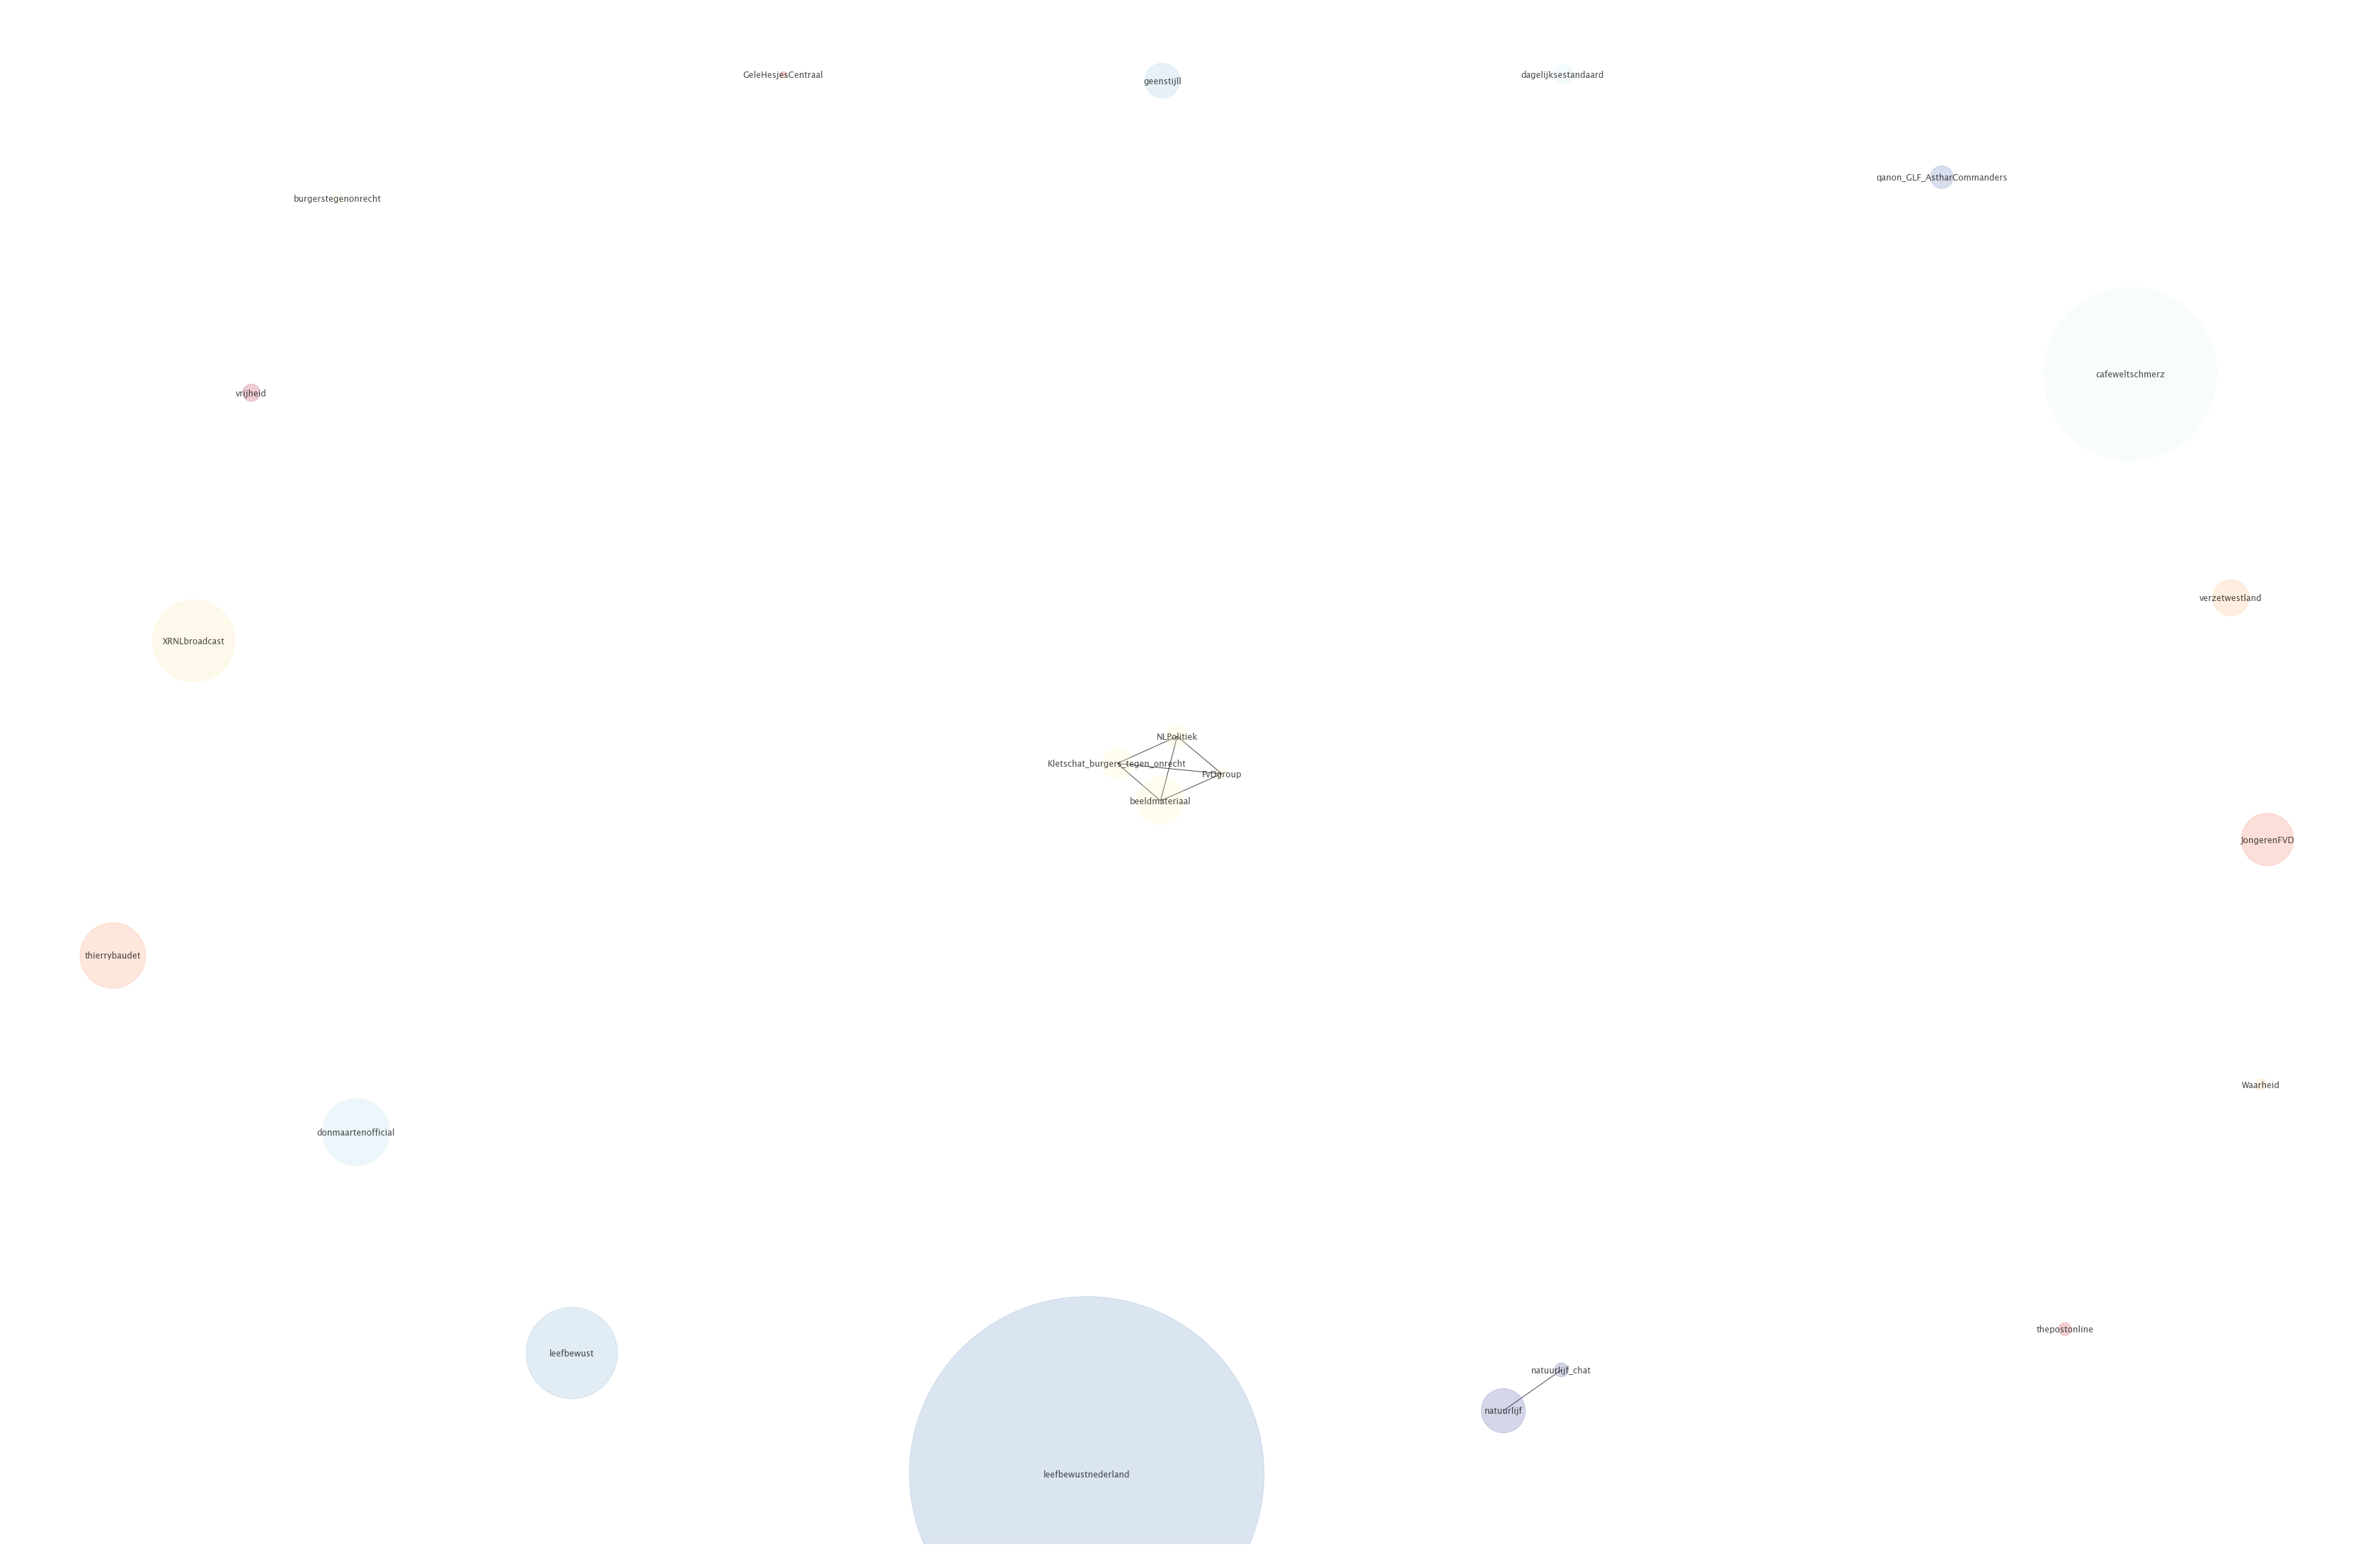

In [1177]:
#Plot with Louvain algortihm T1
pos = nx.spring_layout(GT1U)
plt.figure(figsize=(60,40))
plt.axis('off')
nx.draw_networkx_labels(GT1U,pos,font_size=12, font_family = "sans-serif", font_color = "k", alpha = 0.7)
nx.draw_networkx_nodes(GT1U, pos, cmap=plt.cm.RdYlBu, node_color=list(cluster7.values()), node_size = [x * 10 for x in size4], alpha = 0.2)
nx.draw_networkx_edges(GT1U, pos, alpha=0.7, edge_color = "k")
#plt.show(GT1U)
#plt.savefig("GT1U.png",facecolor=fig.get_facecolor(), edgecolor='none', dpi=360)

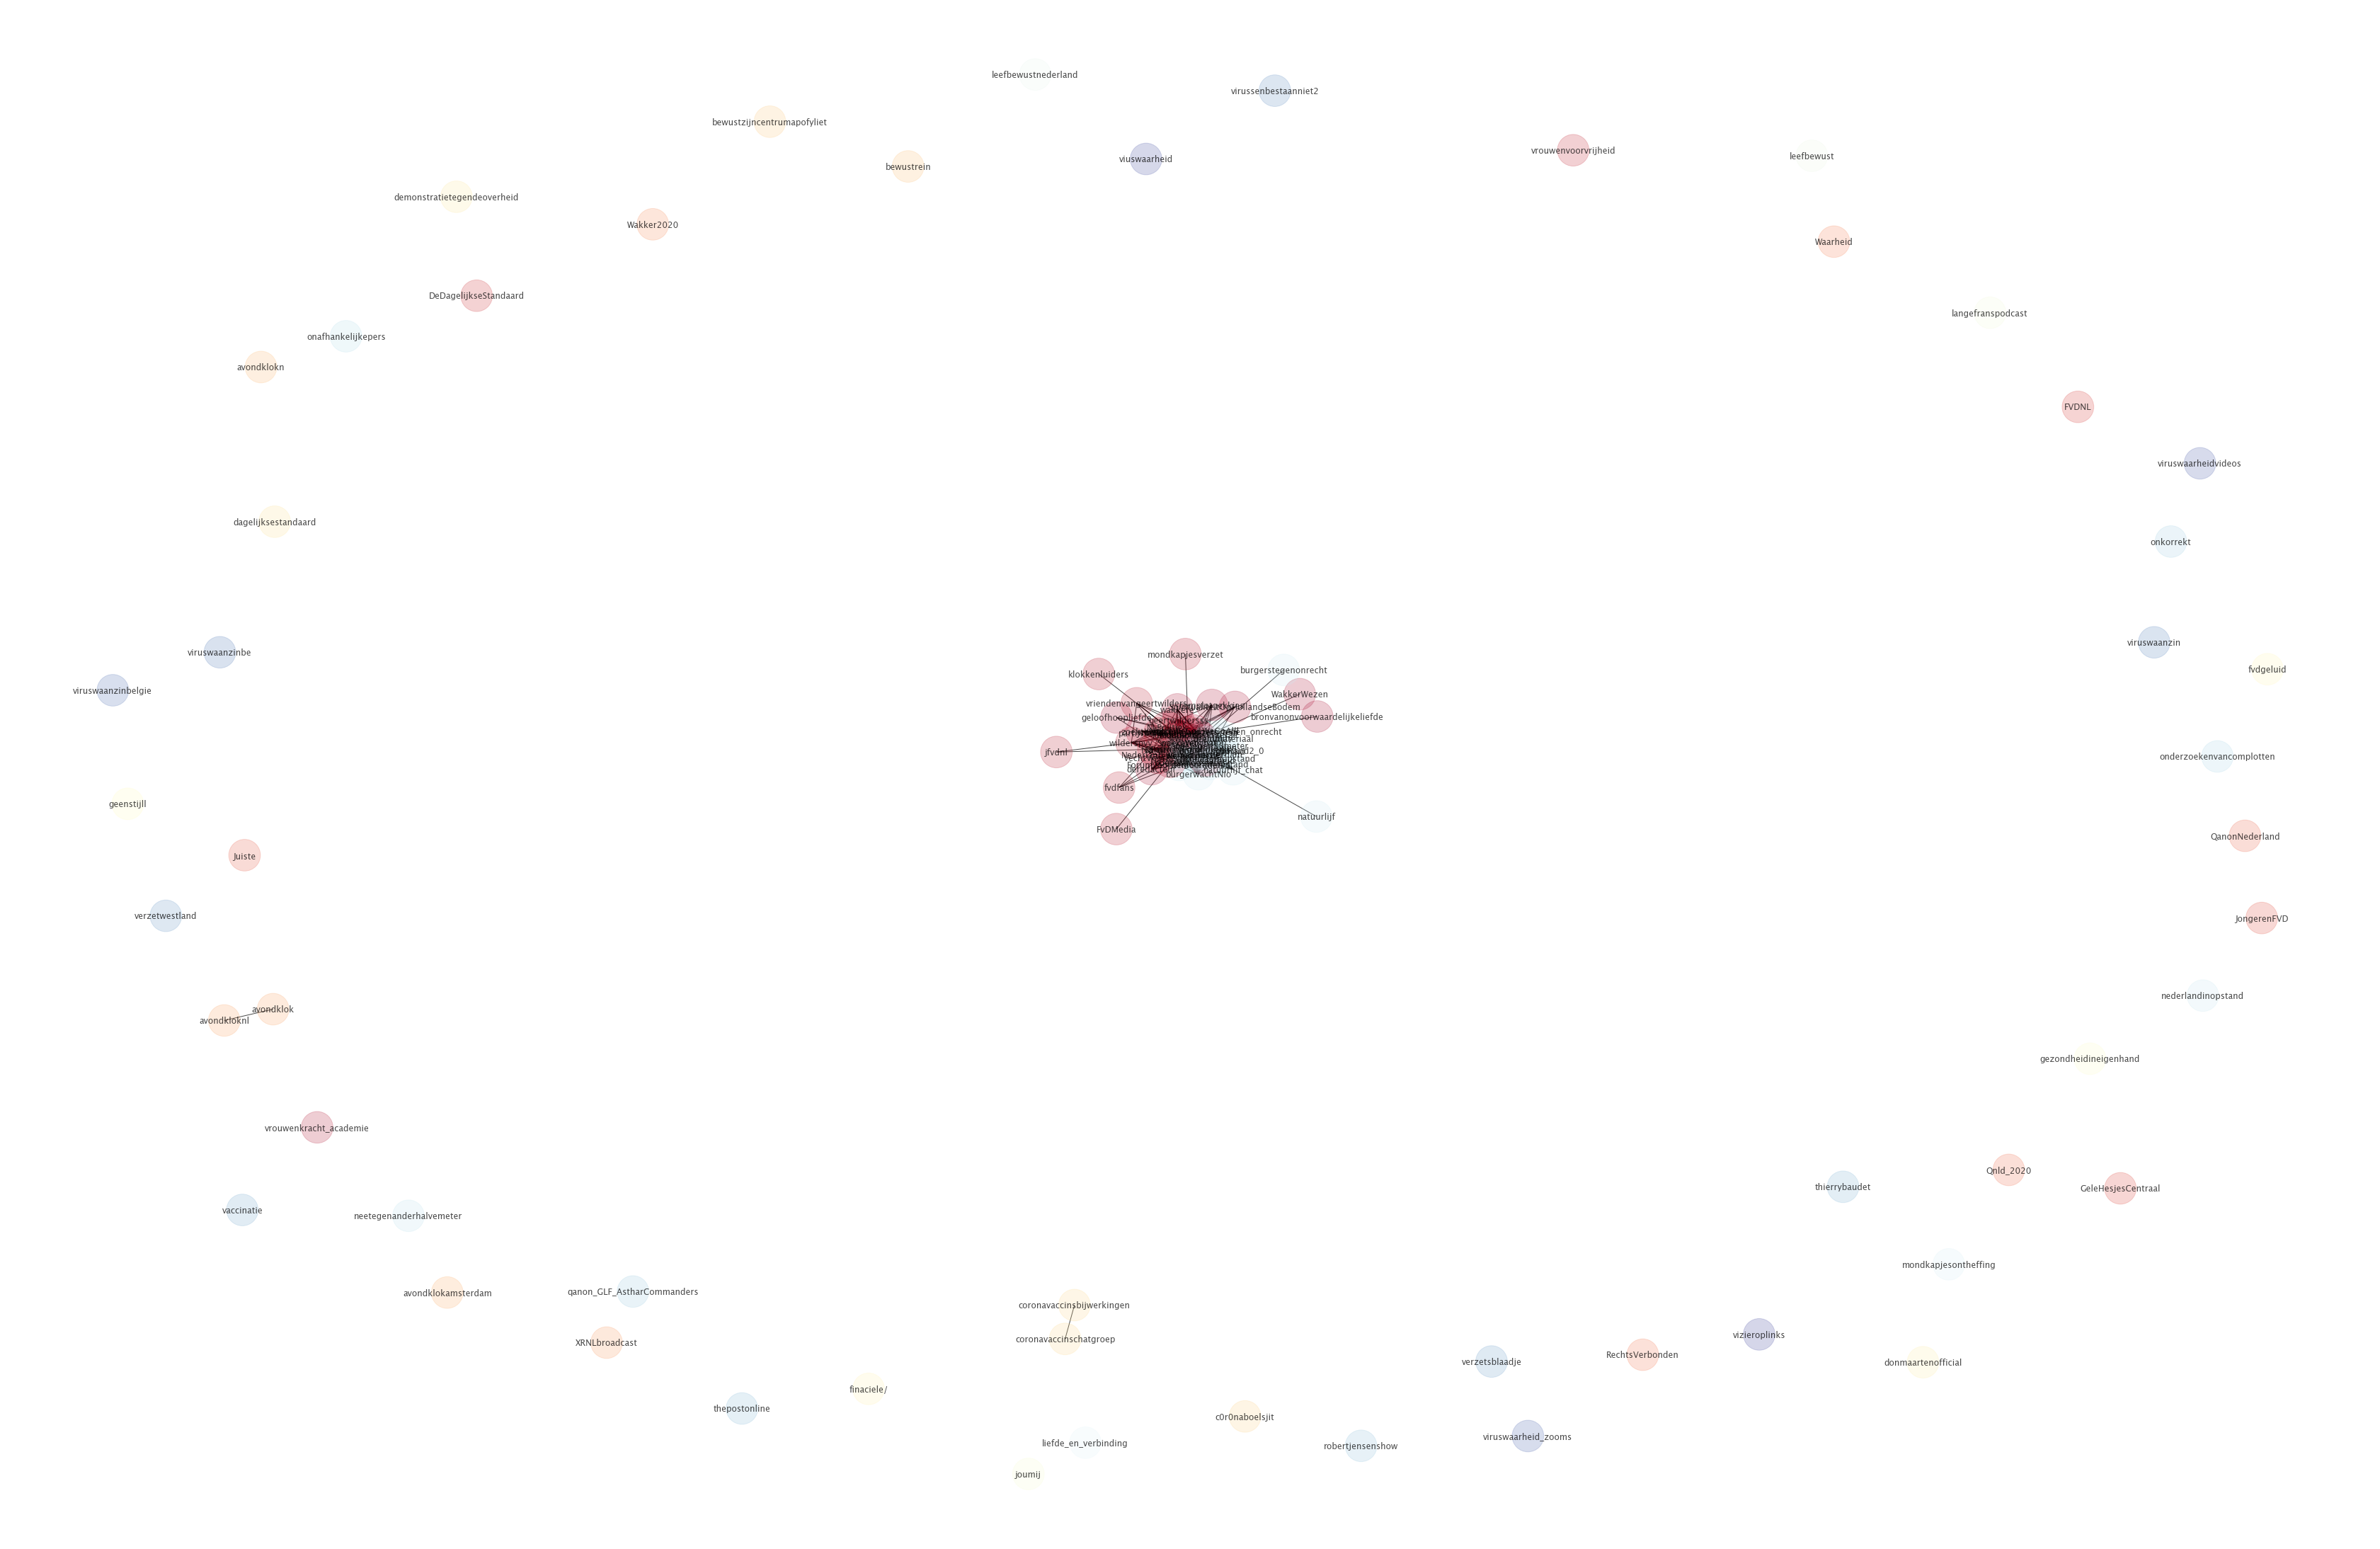

In [1178]:
#Plot with Louvain algortihm T2
pos = nx.spring_layout(GT2U)
plt.figure(figsize=(60,40))
plt.axis('off')
nx.draw_networkx_labels(GT2U,pos,font_size=12, font_family = "sans-serif", font_color = "k", alpha = 0.7)
nx.draw_networkx_nodes(GT2U, pos, cmap=plt.cm.RdYlBu, node_color=list(cluster9.values()), node_size = 2000, alpha = 0.2)
nx.draw_networkx_edges(GT2U, pos, alpha=0.7, edge_color = "k")
#plt.show(GT2U)
#plt.savefig("GT2U.png",facecolor=fig.get_facecolor(), edgecolor='none', dpi=360)

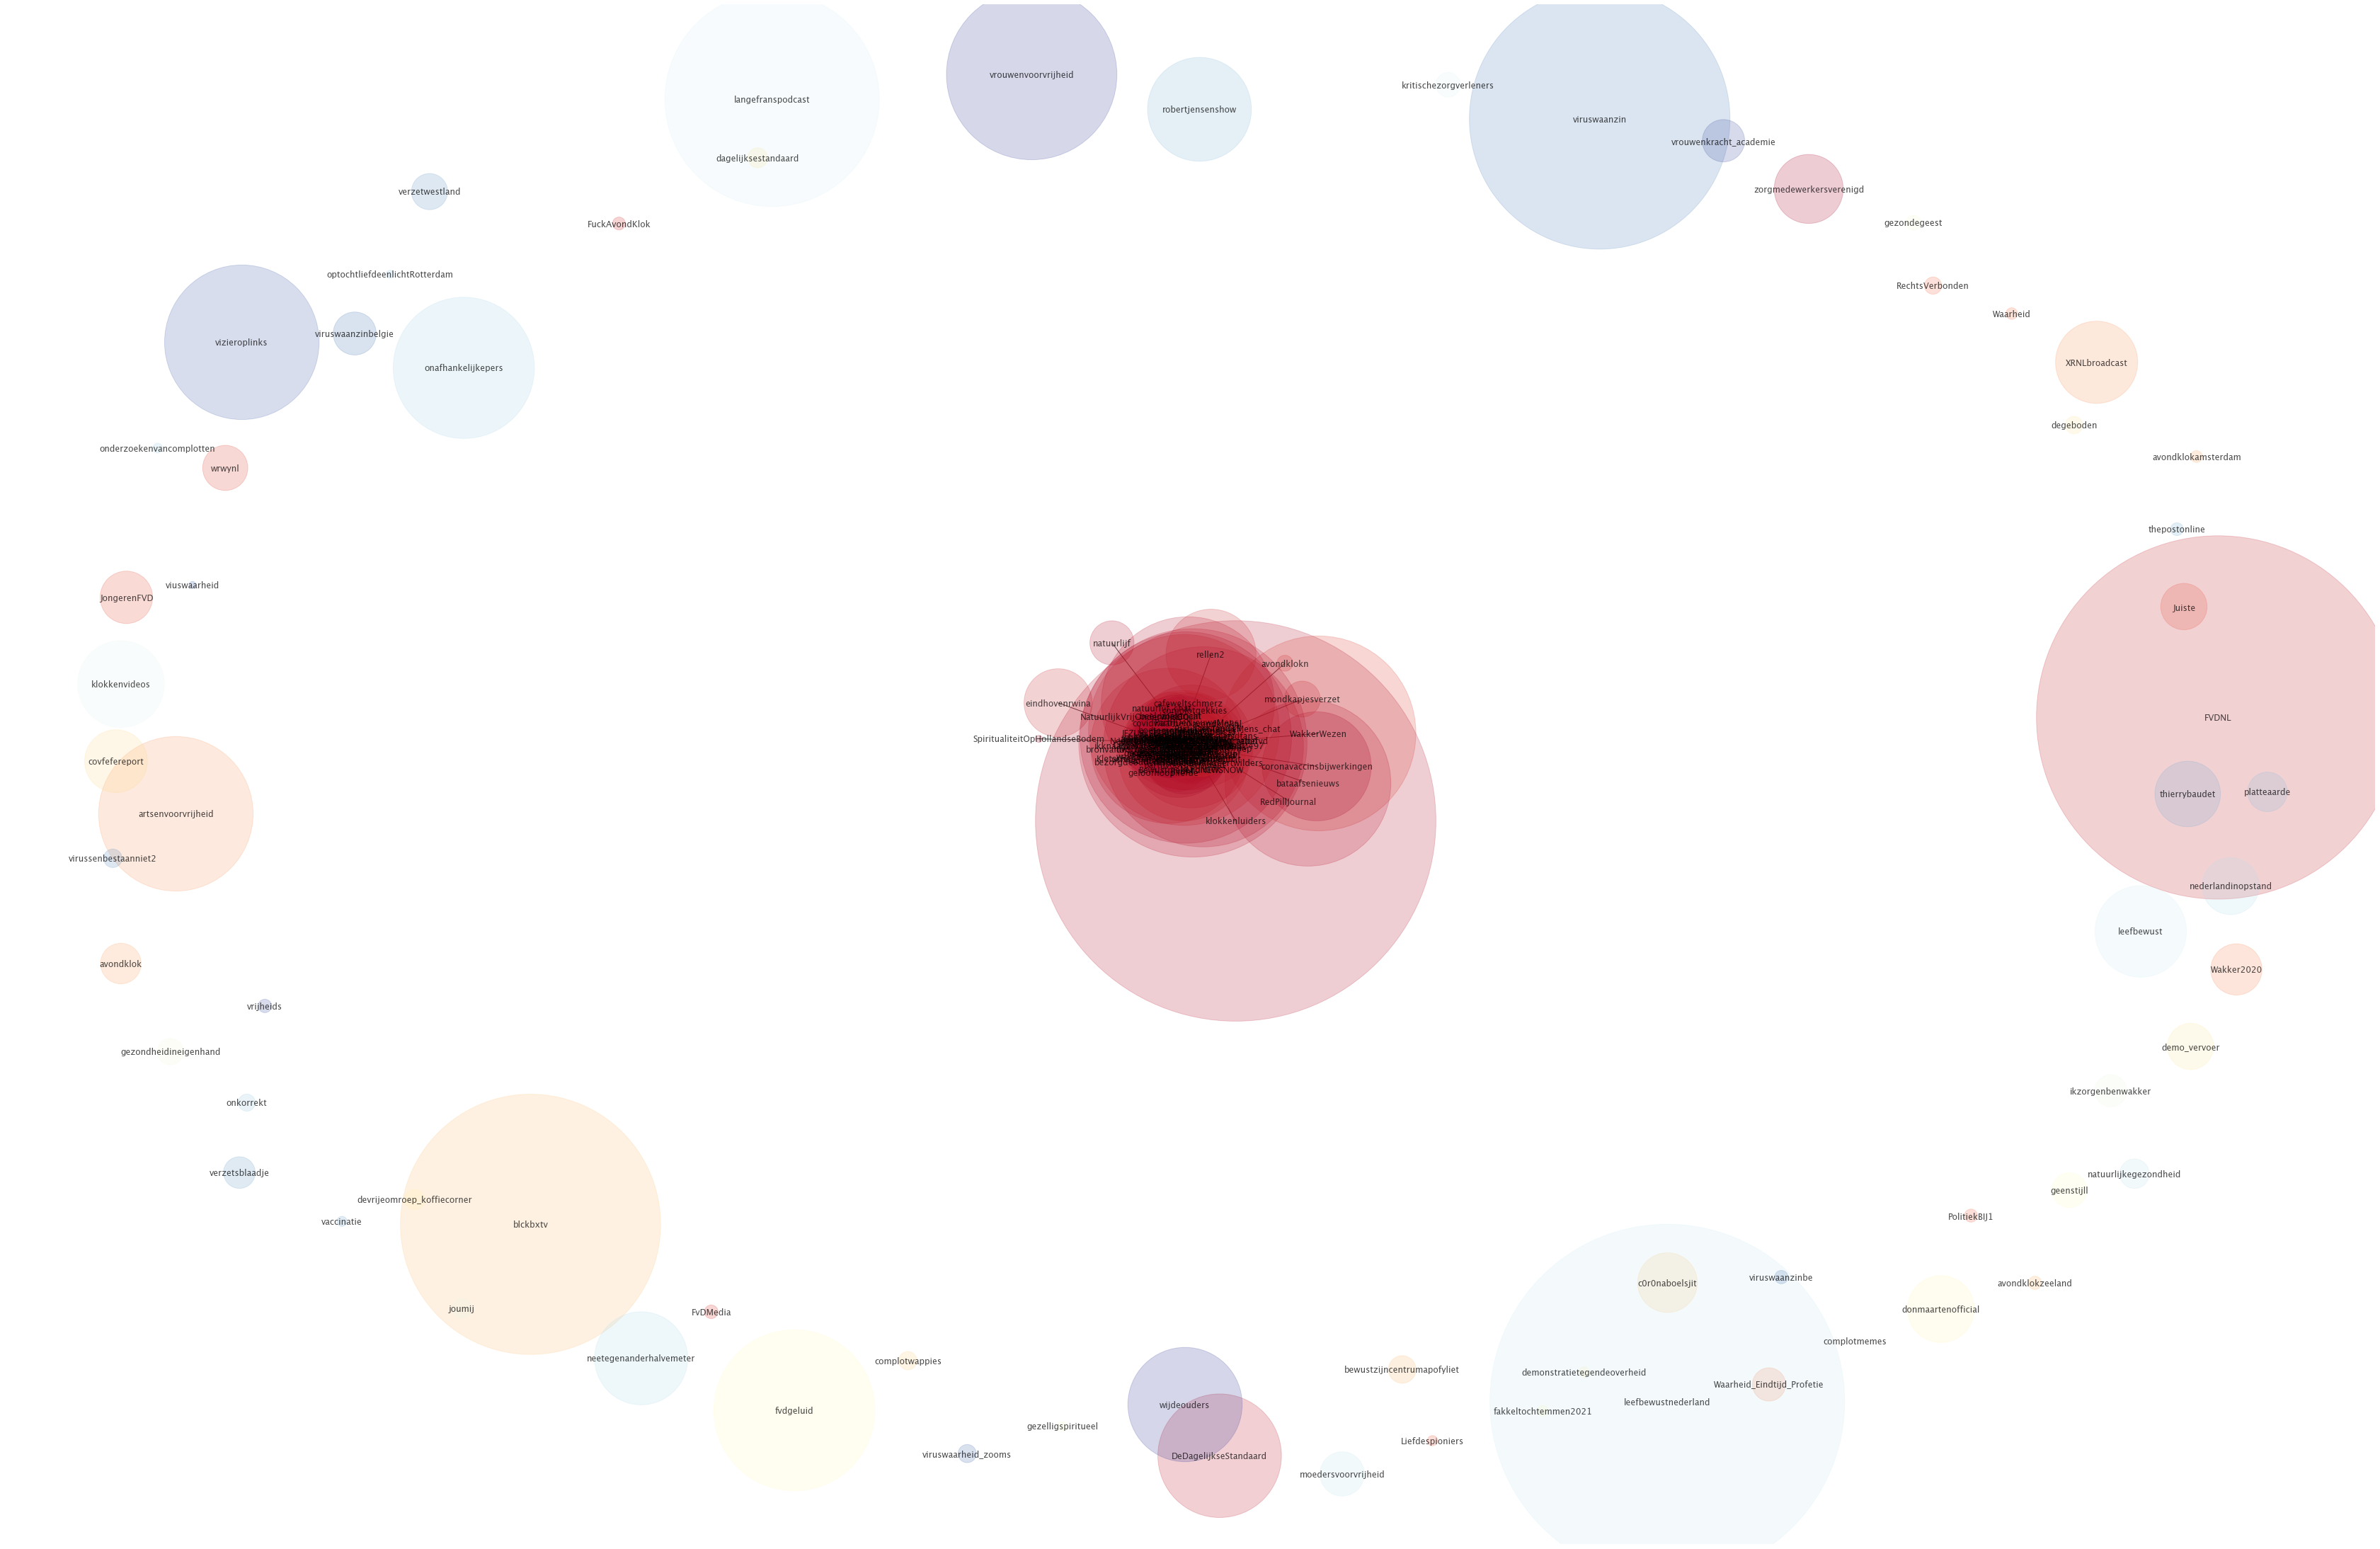

In [1179]:
#Plot with Louvain algortihm T3
pos = nx.spring_layout(GT3U)
plt.figure(figsize=(60,40))
plt.axis('off')
nx.draw_networkx_labels(GT3U,pos,font_size=12, font_family = "sans-serif", font_color = "k", alpha = 0.7)
nx.draw_networkx_nodes(GT3U, pos, cmap=plt.cm.RdYlBu, node_color=list(cluster11.values()), node_size = [x * 10 for x in size6], alpha = 0.2)
nx.draw_networkx_edges(GT3U, pos, alpha=0.7, edge_color = "k")
#plt.show(GT3U)
#plt.savefig("GT3U.png",facecolor=fig.get_facecolor(), edgecolor='none', dpi=360)

In [1767]:
nx.write_graphml_lxml(GT1L, "GT1L.graphml")

### Draw graph with PyVis Network

In [1180]:
net = Network(height='750px', width='100%', bgcolor='#222222', font_color='white', notebook = True)
net.barnes_hut()
sources = res_T1U['group']
targets = res_T1U['compared_to']
weights = res_T1U['percentage_common_users']

edge_data = zip(sources, targets, weights)

for e in edge_data:
    src = e[0]
    dst = e[1]
    w = e[2]

    net.add_node(src, src, title=src)
    net.add_node(dst, dst, title=dst)
    net.add_edge(src, dst, value=w)

neighbor_map = net.get_adj_list()

# add neighbor data to node hover data
for node in net.nodes:
    node['title'] += ' Neighbors:<br>' + '<br>'.join(neighbor_map[node['id']])
    node['value'] = len(neighbor_map[node['id']])
net.show('test.html')

In [1181]:
net = Network(height='750px', width='100%', bgcolor='#222222', font_color='white', notebook = True)
net.barnes_hut()
sources = res_T1L['group']
targets = res_T1L['compared_to']
weights = res_T1L['percentage_common_links']

edge_data = zip(sources, targets, weights)

for e in edge_data:
    src = e[0]
    dst = e[1]
    w = e[2]

    net.add_node(src, src, title=src)
    net.add_node(dst, dst, title=dst)
    net.add_edge(src, dst, value=w)

neighbor_map = net.get_adj_list()

# add neighbor data to node hover data
for node in net.nodes:
    node['title'] += ' Neighbors:<br>' + '<br>'.join(neighbor_map[node['id']])
    node['value'] = len(neighbor_map[node['id']])
net.show('test.html')

### With igraph

In [1748]:
g1u = ig.Graph.from_networkx(GT1U)
g2u = ig.Graph.from_networkx(GT2U)
g3u = ig.Graph.from_networkx(GT3U)
g1u.vs["id"] = g1u.vs["_nx_name"]
g2u.vs["id"] = g2u.vs["_nx_name"]
g3u.vs["id"] = g3u.vs["_nx_name"]
del(g1u.vs['_nx_name'])
del(g2u.vs['_nx_name'])
del(g3u.vs['_nx_name'])
g1u.es["weight"] = g1u.es["percentage_common_users"]
g2u.es["weight"] = g2u.es["percentage_common_users"]
g3u.es['weight'] = g3u.es["percentage_common_users"]

In [1749]:
#biggest connected components per time slice in user overlap network
print('Overlapping user Telegram network T1:')
print(f"Number of chats/channels in biggest connected compenent within user overlap network at T1: {len(g1u.clusters().giant().vs['id'])}")
print(f"List of chats/channels in biggest connected compenent within user overlap network at T1: \n{g1u.clusters().giant().vs['id']}")

print('\nOverlapping user Telegram network T2:')
print(f"Number of chats/channels in biggest connected compenent within user overlap network at T2: {len(g2u.clusters().giant().vs['id'])}")
print(f"List of chats/channels in biggest connected compenent within User Overlap network at T2: \n{g2u.clusters().giant().vs['id']}")

print('\nOverlapping user Telegram network T3:')
print(f"Number of chats/channels in biggest connected compenent within user overlap network at T3: {len(g3u.clusters().giant().vs['id'])}")
print(f"List of chats/channels in biggest connected compenent within user overlap network at T3: \n{g3u.clusters().giant().vs['id']}")


Overlapping user Telegram network T1:
Number of chats/channels in biggest connected compenent within user overlap network at T1: 4
List of chats/channels in biggest connected compenent within user overlap network at T1: 
['FvDgroup', 'Kletschat_burgers_tegen_onrecht', 'NLPolitiek', 'beeldmateriaal']

Overlapping user Telegram network T2:
Number of chats/channels in biggest connected compenent within user overlap network at T2: 36
List of chats/channels in biggest connected compenent within User Overlap network at T2: 
['zoektocht', 'nederlandsverzet21', 'cafeweltschmerz', 'wakkerenchat', 'wwncommunity', 'samen1voornl', 'boereninopstand', 'klokkenchat', 'wakkergroningen', 'whereWeGo1WeGoAlll', 'Forumvoordemocratiefvd', 'FvDgroup', 'Kletschat_burgers_tegen_onrecht', 'NLPolitiek', 'Nederland_in_het_verzet', 'QPatriotsEindhoven', 'SpoedWet', 'VechtVoorRechtt', 'beeldmateriaal', 'boereninopstand2_0', 'burgerwachtNio', 'covidwaarheid', 'denhaaginopstand', 'fvd_nl', 'geertwildersss', 'jongere

In [1751]:
#print modularity, clusters and biggest communities in each graph

print('Overlapping link Telegram network T1:')
print("Leiden")
leiden(g1l)
print('\nOverlapping link Telegram network T2:')
print("Leiden")
leiden(g2l)
print('\nOverlapping link Telegram network T3:')
print("Leiden")
leiden(g3l)
print('\nOverlapping user Telegram network T1:')
print("Leiden")
leiden(g1u)
print('\nOverlapping user Telegram network T2:')
print("Leiden")
leiden(g2u)
print('\nOverlapping user Telegram network T3:')
print("Leiden")
leiden(g3u)

Overlapping link Telegram network T1:
Leiden
modularity = 0.09726112431679512
Clustering with 20 elements and 17 clusters
Top 5 biggest communities: [2, 2, 2, 1, 1]

Overlapping link Telegram network T2:
Leiden
modularity = 0.0
Clustering with 90 elements and 30 clusters
Top 5 biggest communities: [61, 1, 1, 1, 1]

Overlapping link Telegram network T3:
Leiden
modularity = 0.00012228812147521622
Clustering with 148 elements and 33 clusters
Top 5 biggest communities: [115, 2, 1, 1, 1]

Overlapping user Telegram network T1:
Leiden
modularity = 0.0
Clustering with 22 elements and 19 clusters
Top 5 biggest communities: [4, 1, 1, 1, 1]

Overlapping user Telegram network T2:
Leiden
modularity = 0.0
Clustering with 105 elements and 70 clusters
Top 5 biggest communities: [36, 1, 1, 1, 1]

Overlapping user Telegram network T3:
Leiden
modularity = 0.0
Clustering with 164 elements and 88 clusters
Top 5 biggest communities: [77, 1, 1, 1, 1]


In [1755]:
105/20


5.25

In [1757]:
36/105*100

34.285714285714285

In [1758]:
61/90*100

67.77777777777779